In [2]:
import numpy as np
import matplotlib.pylab as plt
import matplotlib as mpl
#from set_haloMF import *
import matplotlib.colors as colors
import utils
from colossus.halo import concentration, mass_so
import colossus.cosmology.cosmology as cosmo
from scipy.integrate import cumtrapz
import pandas as pd
from multiprocessing import Pool

import matplotlib.ticker as tck
from scipy.interpolate import interp1d
from matplotlib.lines import Line2D
cosmol=cosmo.setCosmology('planck15')    #cosmology for colossus. By default hmf uses planck15
cosmo.setCurrent(cosmol)

%load_ext autoreload
%autoreload 2

plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=5
plt.rcParams['xtick.major.size'] =15
plt.rcParams['ytick.major.size'] =15
plt.rcParams['xtick.minor.size'] =10
plt.rcParams['ytick.minor.size'] =10
plt.rcParams['xtick.major.width'] =5
plt.rcParams['ytick.major.width'] =5
plt.rcParams['xtick.minor.width'] =5
plt.rcParams['ytick.minor.width'] =5
mpl.rcParams['axes.titlepad'] = 10

plt.rcParams['font.size']=55
plt.rcParams['figure.figsize']=(12,16)

def extract_catalog(N,M):
    f=interp1d(N,M)
    array_cumul=np.arange(min(N),max(N))
    cat=f(array_cumul)
    
    return cat

def compute_size_funct(R, Vol):
    Re=np.log10(R)
    bin_width=0.1
    bins=np.arange(0.5,4,bin_width)
    hist=np.histogram(Re,bins=bins)[0]
    bin_centre=bins+bin_width/2.
    centres=bin_centre[0:len(bin_centre)-1]

    hist=hist/Vol/bin_width  #size function   dN/ dlog10Re [Mpc^-3 dex^-1]

    return centres, hist


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
%reload_ext autoreload

# multiple cartoons 

In [3]:
class grylls19:  
    
    def __init__(self, gamma10=None, gamma11= None, beta10=None, beta11=None,\
                M10=None, SHMnorm10=None, M11=None, SHMnorm11=None,scatterevol=False):
        ''' If both gamma10 and gamma11 , are None it return grylls19 Pymorph. Otherwise 
        they are custom.
        '''
        self.scatterevol = scatterevol
        if gamma10 is not None:
            self.gamma10 = gamma10
        else:
            self.gamma10 = 0.53
            
        if gamma11 is not None:
            self.gamma11 = gamma11
        else:
            self.gamma11 = 0.03
            
        if M10 is not None:
            self.M10 = M10
        else:
            self.M10 = 11.92
            
        if SHMnorm10 is not None:
            self.SHMnorm10 = SHMnorm10
        else:
            self.SHMnorm10 = 0.032
            
        if SHMnorm11 is not None:
            self.SHMnorm11=SHMnorm11
        else:
            self.SHMnorm11=-0.014
        if M11 is not None:
            self.M11=M11
        else:
            self.M11 = 0.58
        if beta10 is not None:
            self.beta10 = beta10
        else:
            self.beta10 = 1.64
        if beta11 is not None:
            self.beta11 = beta11
        else:
            self.beta11 = -0.69
            
   
    def make(self, halos,z,scatter, scatterevol=False):
        zparameter = np.divide(z-0.1, z+1)   
       # zparameter = np.divide(z, z+1) 
        M = self.M10 + self.M11*zparameter
        N = self.SHMnorm10 + self.SHMnorm11*zparameter
        b = self.beta10 + self.beta11*zparameter
        g = self.gamma10 + self.gamma11*zparameter
        
      #  if self.orig:
      #      print('pymorph')
      #      gamma10 = 0.53~
      #      gamma11 = 0.03
      #      Scatter = 0.15
      #      g = gamma10 + gamma11*zparameter
            
        stars =  np.power(10, halos) * (2*N*np.power( (np.power(np.power(10,halos-M), -b) +\
                                                       np.power(np.power(10,halos-M), g)), -1))

        if scatterevol:
            scatt = np.sqrt( (0.1*(z-0.1))**2+scatter**2)
            
        else: 
            scatt = scatter
            
        stars = np.random.normal(np.log10(stars),scale=scatt)
            
        return stars
    
    def __call__(self, halos, z,scatter, scatterevol=False):
        return self.make(halos,z,scatter, scatterevol)

# make data

In [4]:
import pandas as pd
from astropy.stats import jackknife_stats
Header = ["galcount", "z", "Vmaxwt", "MsMendSerExp", "AbsMag", "logReSerExp", "BT", "n_bulge", "newLcentsat", "NewMCentSat", "newMhaloL", "probaE", "probaEll", "probaS0", "probaSab", "probaScd", "TType", "AbsMagCent", "MsCent", "veldisp", "veldisperr", "AbsModel_newKcorr", "LCentSat", "raSDSS7", "decSDSS7", "Z", "sSFR", "FLAGsSFR", "MEDIANsSFR", "P16sSFR", "P84sSRF", "SFR", "FLAGSFR", "MEDIANSFR", "P16SFR", "P84SRF", "RA_SDSS", "DEC_SDSS", "Z_2", "Seperation"]
df = pd.read_csv('~/PhD/data/SDSS/new_catalog_SFRs_Pip.dat', header = None, names = Header, delim_whitespace = True, skiprows = 1)
#df1 = pd.read_csv('/home/lz1f17/PhD/data/Catalog_SDSS_complete_NotTrunc.dat', delim_whitespace=True)
#
df.loc['MsMendSerExp'] = df['MsMendSerExp'].apply(lambda x: x+0.025)

In [108]:
df['sSFR_Serexp']  = df.apply(lambda x: x.SFR-x.MsMendSerExp, axis=1)

In [5]:
skycov=8000.
fracper = len(df)/670722
fracsky=(skycov*fracper)/(4*np.pi*(180./np.pi)**2.)


In [6]:
df_L = df.query('TType>0 & newLcentsat==1')
df_E = df.query('TType<=0 & newLcentsat==1')

In [8]:
Vol=(500.)**3
z = 0.1
halos = utils.get_halos(z, Vol,mdef='vir')

smhm = grylls19()
stars = smhm(halos, z, scatter=0.15)

In [9]:
SMF_BinWidth = 0.05
SMF_Bins = np.arange(9,12.5,SMF_BinWidth)
bins = np.append(SMF_Bins, np.max(SMF_Bins)+SMF_BinWidth)-(SMF_BinWidth/2)

model = np.histogram(stars,bins=SMF_Bins)[0]/Vol/SMF_BinWidth
LTGs_SDSS = np.histogram(df_L['MsMendSerExp'], weights=df_L['Vmaxwt'],bins=SMF_Bins)[0]/fracsky/SMF_BinWidth
ETGs_SDSS = np.histogram(df_E['MsMendSerExp'], weights=df_E['Vmaxwt'],bins=SMF_Bins)[0]/fracsky/SMF_BinWidth
#All_Pip = np.histogram(df.query('newLcentsat==1')['MsMendSerExp'], weights=df.query('newLcentsat==1')['Vmaxwt'], bins=bins)[0]/fracsky/0.1
All = np.histogram(df.query('newLcentsat==1')['MsMendSerExp'], weights=df.query('newLcentsat==1')['Vmaxwt'], bins=SMF_Bins)[0]/fracsky/SMF_BinWidth

In [29]:
#_,SMF,err = np.loadtxt('/home/lz1f17/PhD/data/SDSS/SMF_Bernardi_SerExp_Mendel.txt', unpack=True)
BB, SMF_G19, err = np.loadtxt('/home/lz1f17/PhD/data/SMF_used_in_G19.txt', unpack=True)

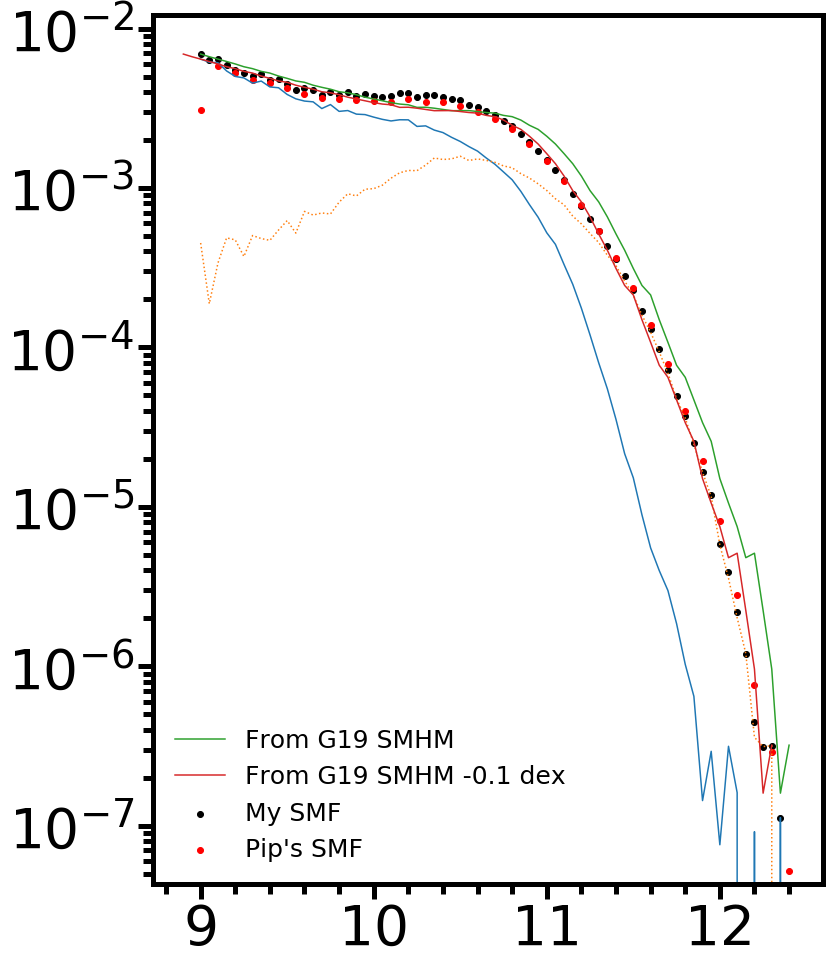

In [30]:
plt.plot(SMF_Bins[1:]-SMF_BinWidth,LTGs_SDSS,ls='-')

plt.plot(SMF_Bins[1:]-SMF_BinWidth, ETGs_SDSS, ls=':')
#plt.scatter(SMF_Bins[1:]-0.05, 10**SMF, color='red')
plt.plot(SMF_Bins[1:]-SMF_BinWidth,model,ls='-', label='From G19 SMHM')
plt.plot(SMF_Bins[1:]-SMF_BinWidth-0.1,model,ls='-', label='From G19 SMHM -0.1 dex')

plt.scatter(SMF_Bins[1:]-SMF_BinWidth, All, color='black', label='My SMF')
#plt.scatter(SMF_Bins[1:]-SMF_BinWidth, All, color='cyan')
plt.scatter(BB,10**SMF_G19, color='red', label="Pip's SMF")
plt.yscale('log')
plt.legend(fontsize=25, frameon=False)

In [10]:
B = SMF_Bins[1:]-SMF_BinWidth/2
mask = np.ma.masked_greater(B,11.2-SMF_BinWidth/2,12).mask   #in data we choose 11.2

n_LTGs_SDSS = cumtrapz(LTGs_SDSS[mask],B[mask])[-1]
n_ETGs_SDSS = cumtrapz(ETGs_SDSS[mask],B[mask])[-1]

n_SDSS = cumtrapz(All[mask],B[mask])[-1]

In [11]:
B = SMF_Bins[1:]-SMF_BinWidth/2
mask = np.ma.masked_greater(B,11.3-SMF_BinWidth/2,12.1).mask   #in model we choose 11.3
n_SDSS_cat = cumtrapz(model[mask],B[mask])[-1]

In [11]:
n_ETGs_SDSS, n_SDSS, n_LTGs_SDSS

(0.00018390742674422034, 0.0002165939809415441, 3.2686554197331335e-05)

In [12]:
n_davidzon_SF = np.loadtxt('/home/lz1f17/PhD/data/SMF/Number_density_percentiles_MGs/percentiles_Davidzon_star_forming.txt',unpack=True).T
n_davidzon_Q = np.loadtxt('/home/lz1f17/PhD/data/SMF/Number_density_percentiles_MGs/percentiles_Davidzon_quenched.txt',unpack=True).T
n_davidzon = np.loadtxt('/home/lz1f17/PhD/data/SMF/Number_density_percentiles_MGs/percentiles_Davidzon_total.txt',unpack=True).T
n_leja= np.loadtxt('/home/lz1f17/PhD/data/SMF/Number_density_percentiles_MGs/percentiles_Leja.txt',unpack=True).T
n_mcleod_SF = np.loadtxt('/home/lz1f17/PhD/data/SMF/Number_density_percentiles_MGs/percentiles_McLeod_star_forming.txt',unpack=True).T
n_mcleod_Q = np.loadtxt('/home/lz1f17/PhD/data/SMF/Number_density_percentiles_MGs/percentiles_McLeod_quenched.txt',unpack=True).T
n_mcleod = np.loadtxt('/home/lz1f17/PhD/data/SMF/Number_density_percentiles_MGs/percentiles_McLeod_total.txt',unpack=True).T

### important addition for the future! If LTGs are selected with TType>1 (i.e. more likely to be actual star forming disks) their size is huge (~17kpc).
### This masks the compacts at higher z since the normalization of SF galaxies is so big.

6668
9094


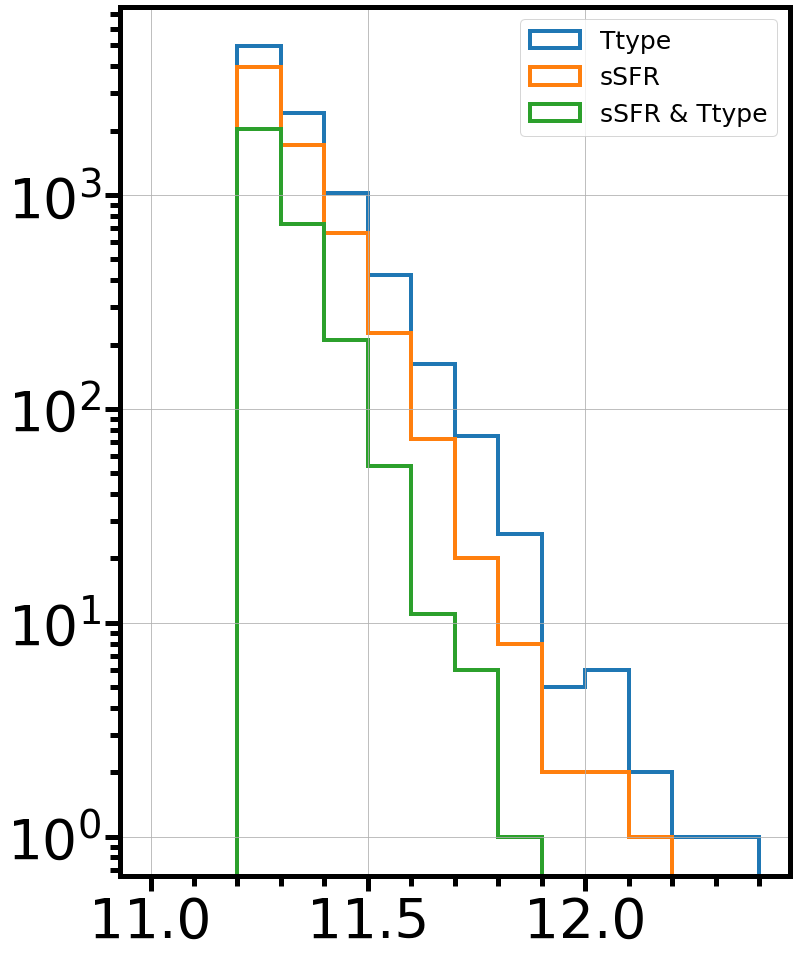

In [102]:
fig,a = plt.subplots()
df.query('TType>1 & MsMendSerExp>11.2')['MsMendSerExp'].hist(ax=a, histtype='step',lw=4, bins=np.arange(11,12.5,0.1), label='Ttype')
df.query('sSFR>-11 & MsMendSerExp>11.2')['MsMendSerExp'].hist(ax=a, histtype='step',lw=4, bins=np.arange(11,12.5,0.1), label='sSFR')
df.query('sSFR>-11 & TType>1 & MsMendSerExp>11.2')['MsMendSerExp'].hist(ax=a, histtype='step',lw=4, bins=np.arange(11,12.5,0.1), label='sSFR & Ttype')

plt.yscale('log')
plt.legend(fontsize=25)
print(len(df.query('sSFR>-11 & MsMendSerExp>11.2')))
print(len(df.query('TType>0 & MsMendSerExp>11.2')))

# prepare halo catalogs

In [13]:
Vol = 400**3
Halos_arr = []
for z in np.arange(0,3.5,0.5):
    halos = utils.get_halos(z, Vol, mdef='vir')
    halos = halos[halos>11.7]
    Halos_arr.append(halos)

# make HOD cartoons

In [14]:
orig = grylls19(gamma11=0, SHMnorm11=0, M11=0, gamma10=0.5)

new_gamma0 = grylls19(gamma10=0.7,gamma11=0, SHMnorm11=0, M11=0)


0
1
0.15
0.15811388300841897
0.18027756377319948
0.21213203435596428
0.25
0.291547594742265
0.33541019662496846
2
3
0.15
0.15811388300841897
0.18027756377319948
0.21213203435596428
0.25
0.291547594742265
0.33541019662496846


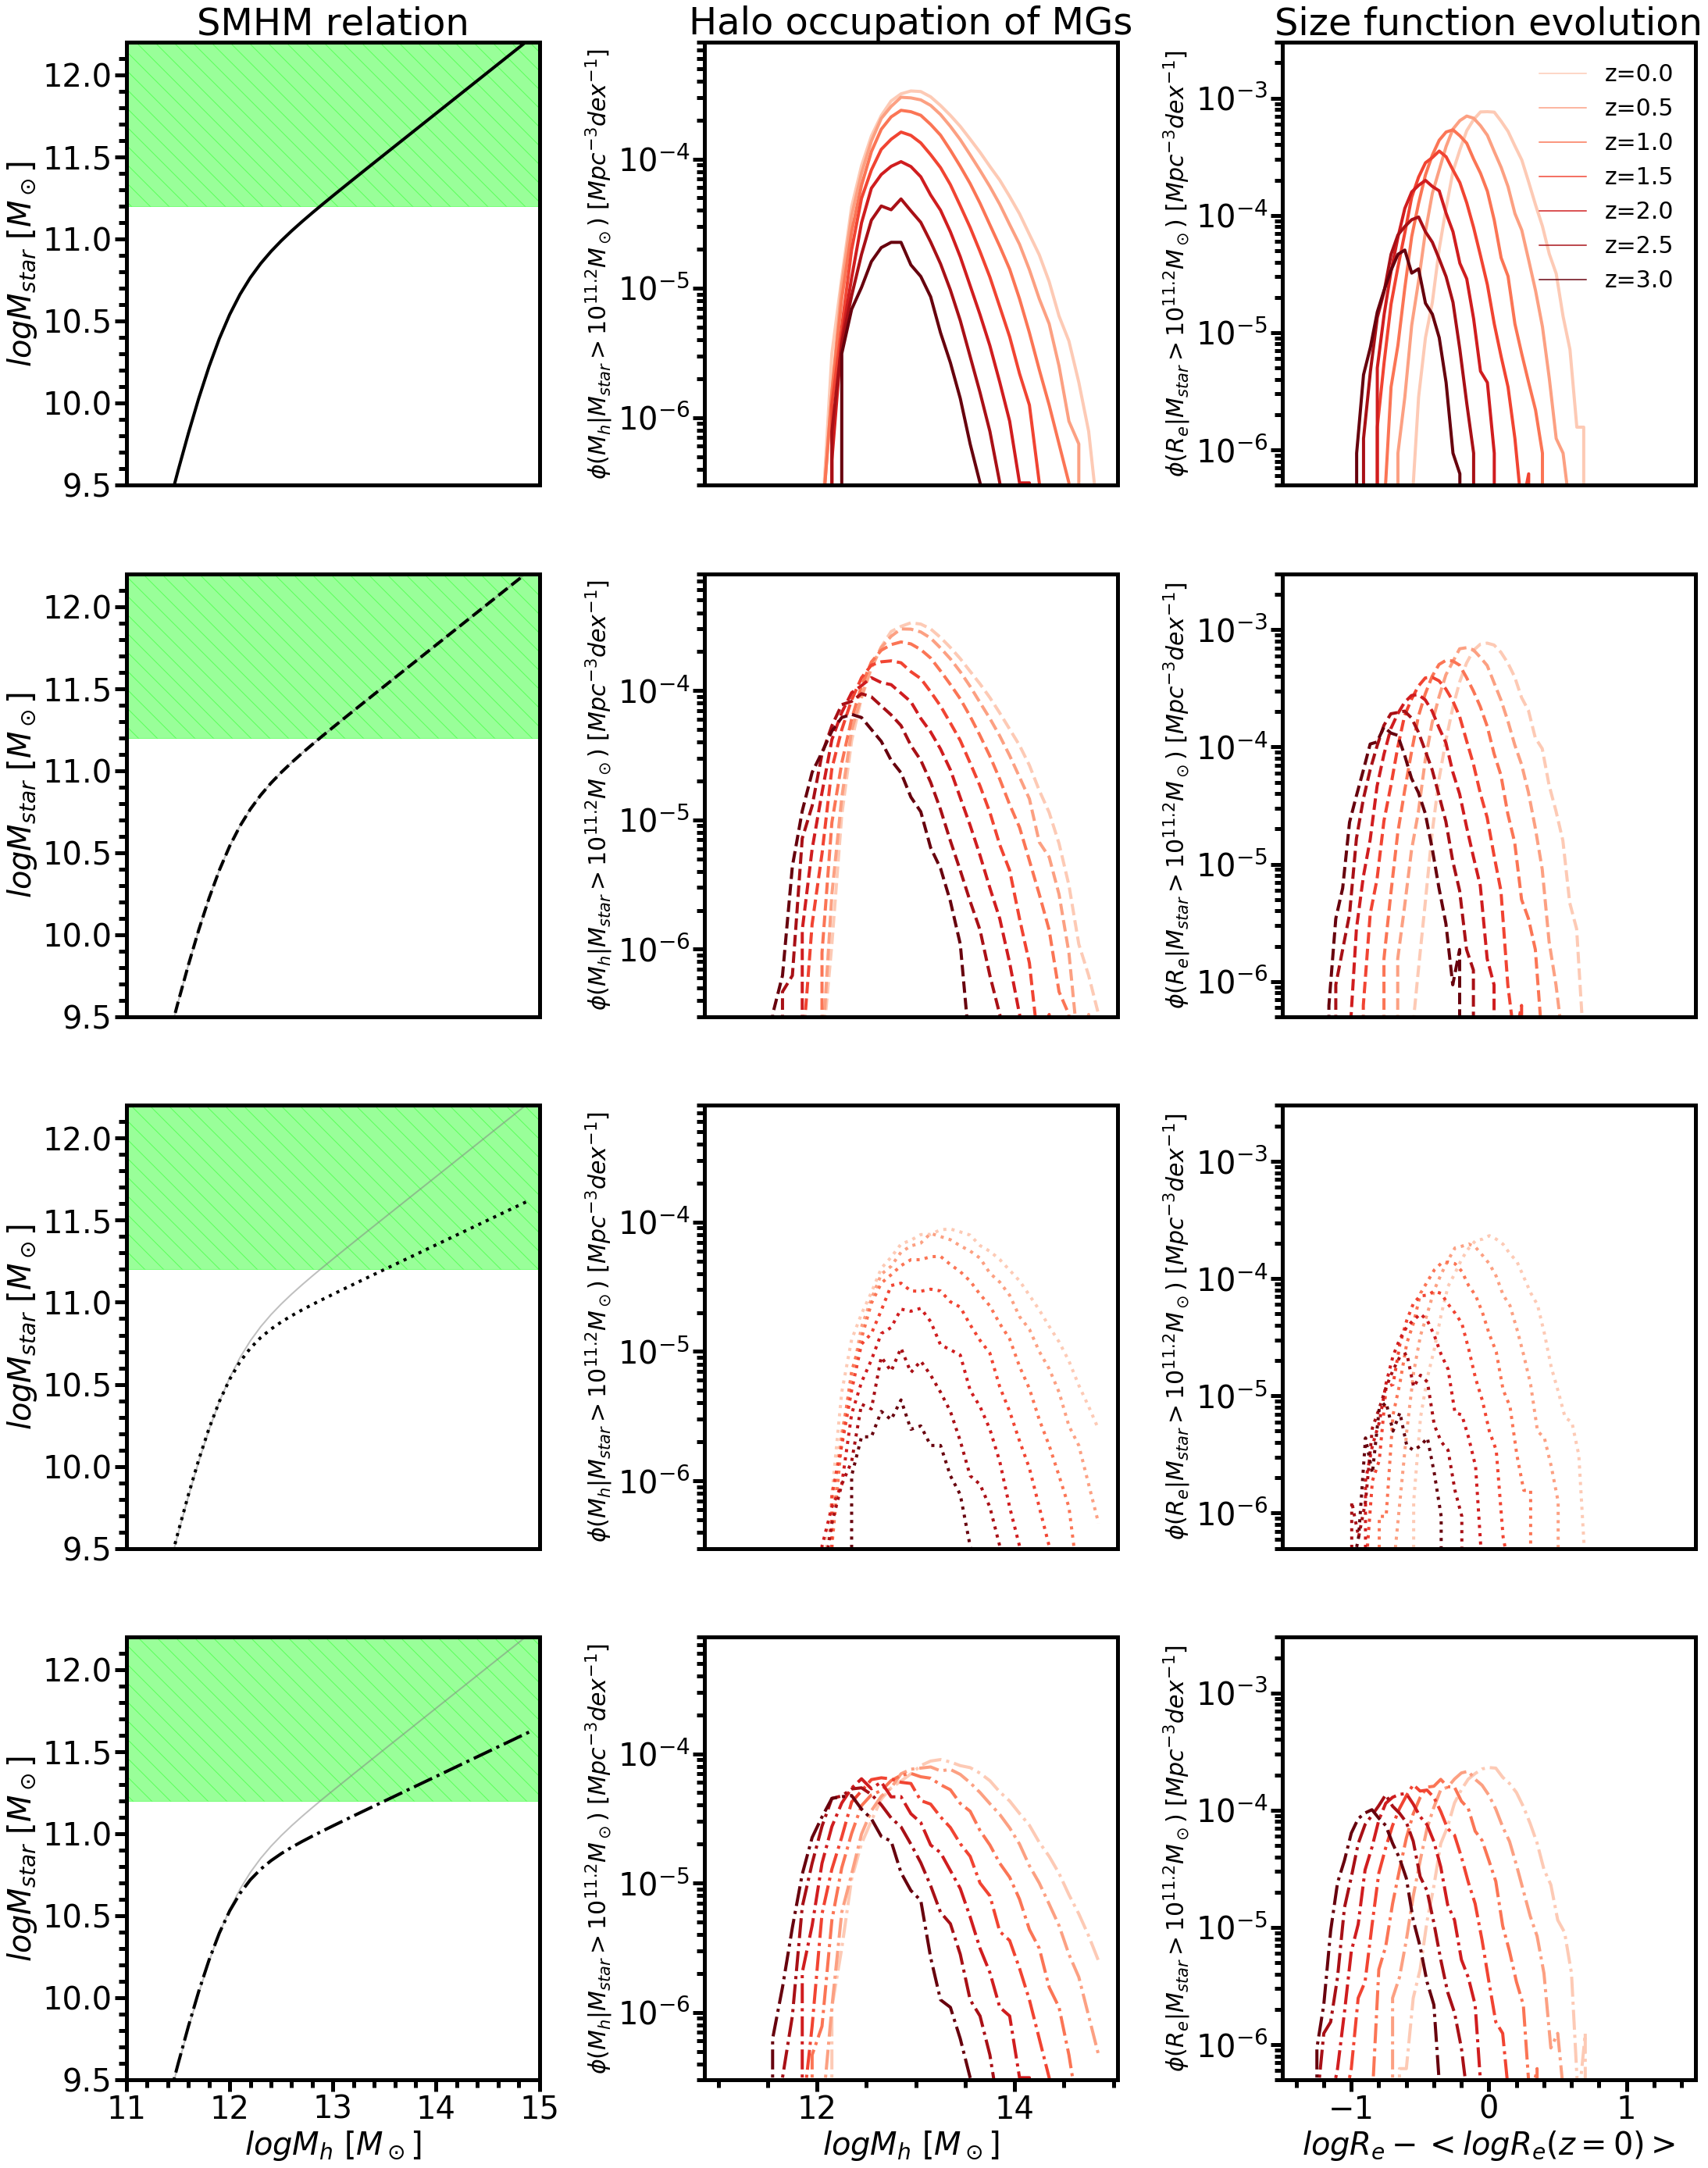

In [73]:
Vol=(400.)**3
z = 0.1
halos = utils.get_halos(z, Vol)
plt.rcParams['font.size'] = 40
models = [orig,orig,new_gamma0,new_gamma0]#orig_gammaz,orig,orig_M11, orig, orig_N11]


redshifts = np.arange(0,3.5,0.5)
linestyles = ['-','--',':','-.']
colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
fig, ax = plt.subplots(4,3, figsize=(36,48))
x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


for j, (m,a,ls) in enumerate(zip(models, ax.T[0].ravel(),linestyles)):
     
    #for i,(z,c) in enumerate(zip(redshifts,colors)):
    y = orig(x,z, scatter=0)
    a.plot(x,y,lw=2, ls='-', color='gray', alpha=0.5)
    
    y = m(x,z, scatter=0)
    a.plot(x,y, label=f'model {j+1}', color='black', ls=ls,lw=4)
        
        
    a.axhspan(11.2, 12.2, alpha=0.4, color='lime',hatch='\\')
    a.set_xlim(11,15)
    a.set_ylim(9.5,12.2)
    a.set_ylabel('$logM_{star} \ [M_\odot]$')
    

save_orig_hod = {}
save_orig_sizefunct = {}
for j,(m,a,a2, ls) in enumerate(zip(models,ax.T[1].ravel(),ax.T[2].ravel(), linestyles)):
    print(j)
    colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
    colors_black = iter(plt.cm.Greys(np.linspace(0.2,1,len(redshifts))))
    dict_new = {}

    for i,(z,c,cb) in enumerate(zip(redshifts,colors,colors_black)):
        halos = utils.get_halos(z, Vol)
        halos = halos[halos>11.5]
        
        if j==0 or j==2:
            stars = m(halos,z,scatter=0.15)
        else:
            stars = m(halos,z,scatter=0.15, scatterevol=True)
            
        mask = np.ma.masked_inside(stars,11.2,12).mask
        halos_ = halos[mask]
        bins_h = np.arange(11,15,0.1)
        h = np.histogram(halos_, bins=bins_h)[0]
        if j==0:
            save_orig_hod.update({str(i): z,f'h_{i}':h})
            a.plot(bins_h[1:]-0.05,h/Vol/0.1, lw=4, color=c,ls=ls)

        else:
            h1 = save_orig_hod[f'h_{i}']
          #  a.plot(bins_h[1:]-0.05,h1/Vol/0.1, lw=2, color=cb,ls='-')            
            a.plot(bins_h[1:]-0.05,h/Vol/0.1, lw=4, color=c, label="z={}".format(z),ls=ls)
            

        a.set_ylabel('$\phi(M_h|M_{star}>10^{11.2} M_\odot) \ [Mpc^{-3} dex^{-1}]$', fontsize=30)
        a.set_yscale('log')
        a.set_ylim(3.e-7,8.e-4)

        _, Re, sizefunct = utils.get_sizefunction(halos,  V=Vol,redshift=z,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
                
        if i==0:
            new_norm = np.median(Re)
            new_var = np.std(Re)
        
        sizefunct[0] -= new_norm        
        dict_new.update({str(z):sizefunct })
        bins_r = sizefunct[0]
        sizefunct = sizefunct[1]

        if j==0:
            save_orig_sizefunct.update({f'bins_{i}':bins_r,f'h_{i}':sizefunct})
            a2.plot(bins_r,sizefunct, lw=4, color=c,ls=ls)

        else:
            h1 = save_orig_sizefunct[f'h_{i}']
            bins_r1 = save_orig_sizefunct[f'bins_{i}']
           #  a2.plot(bins_r1,h1, lw=2, color=cb,ls='-')            
            a2.plot(bins_r,sizefunct, lw=4, color=c, label="z={}".format(z),ls=ls)
            
            
        a2.set_ylabel('$\phi(R_e|M_{star}>10^{11.2} M_\odot) \ [Mpc^{-3} dex^{-1}]$', fontsize=30)
      #  a.yaxis.set_label_position("right")
      #  a.yaxis.tick_right()
        a2.set_yscale('log')
        a2.set_xlim(-1.5,1.5)
        a2.set_ylim(5.e-7,3.e-3)
        
x = np.arange(10000,10000)
colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
for z,col in zip(redshifts,colors):
    ax[0][2].plot(x,x, color=col, label=f'z={z}')

for a1 in ax.T[2].ravel():

    a1.set_ylim(5.e-7,3.e-3)
    a1.set_xlim(-1.5,1.5)
ax[0][2].legend(frameon=False, fontsize=30)
        
for j,a in enumerate(ax[:3].ravel()):
    a.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False)
    
    
#ax[0][1].legend(frameon=False, loc='upper left')
ax[3][0].set_xlabel('$logM_h \ [M_\odot]$')
ax[3][1].set_xlabel('$logM_h \ [M_\odot]$')
ax[3][2].set_xlabel('$log R_e- <log R_e(z=0)>$')


ax[0][0].set_title('SMHM relation')
ax[0][1].set_title('Halo occupation of MGs')
ax[0][2].set_title('Size function evolution')
plt.subplots_adjust(wspace=0.4)
fig.savefig('cartoon_hod.pdf')



# cartoon size evo

Text(0.5, 1.0, 'Mean size evolution')

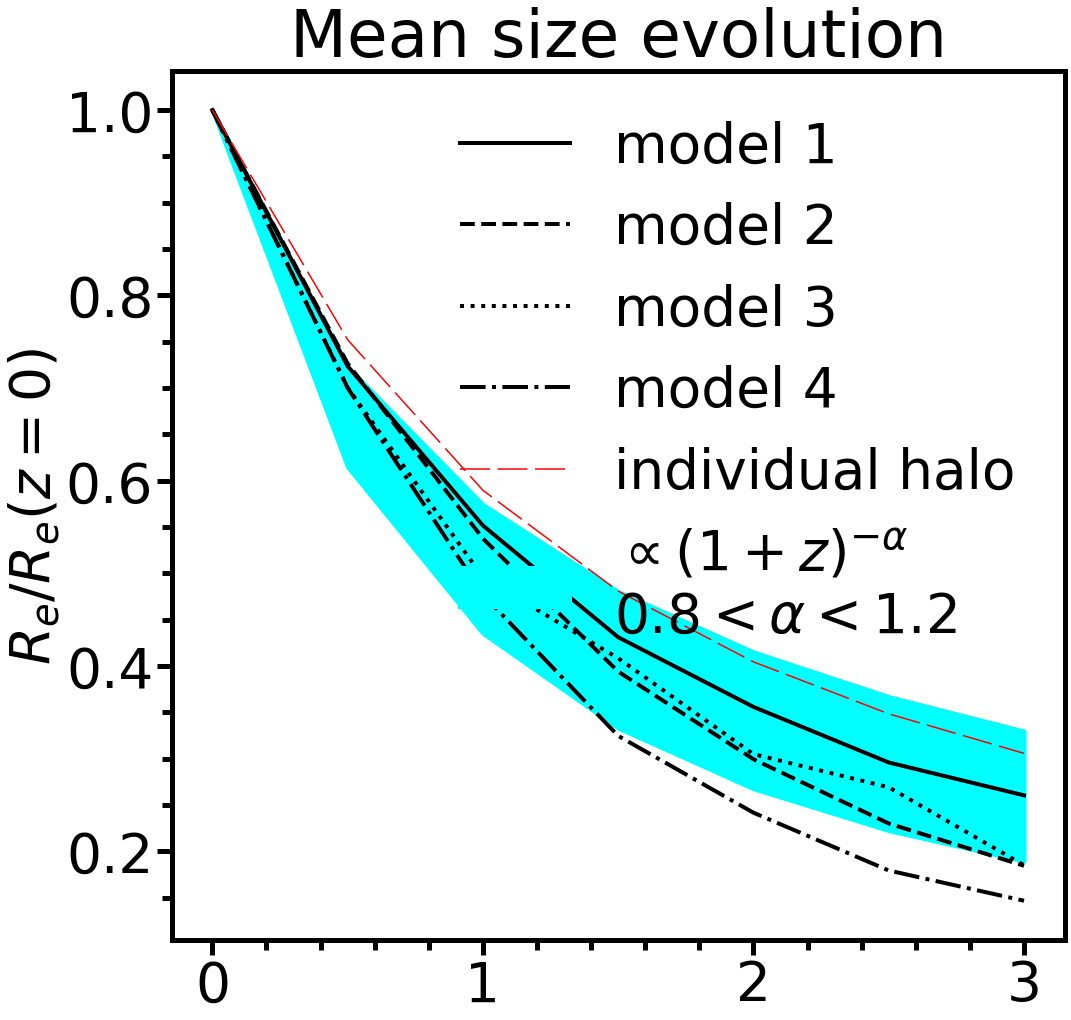

In [22]:
Vol=(200.)**3
z = 0.1
halos = utils.get_halos(z, Vol)

models = [orig,orig,new_gamma0,new_gamma0]#orig_gammaz,orig,orig_M11, orig, orig_N11]


redshifts = np.arange(0,3.5,0.5)
linestyles = ['-','--',':','-.']
colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
fig, ax = plt.subplots(1,1, figsize=(16,16))
x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


        
dict_0 = {}
dict_N_0 = {}

for j,(m,ls) in enumerate(zip(models,linestyles)):
    mean = []
    
    for i,z in enumerate(redshifts):
        halos = utils.get_halos(z, Vol)
        halos_ = halos[halos>11.5]
        if j==0 or j==2:
            stars = m(halos,z,scatter=0.15)
        else:
            stars = m(halos,z,scatter=0.15, scatterevol=True)
            
        _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        
        mean.append(10**np.median(Re))
    mean = np.array(mean)
    ax.plot(redshifts,mean/mean[0], color='black',ls=ls,lw=4, label='model {}'.format(j+1))
    ax.set_ylabel('$R_e/R_e(z=0)$')
    ax.legend(frameon=False)
f = (1+redshifts)**-0.8
f1 = (1+redshifts)**-1.2
ax.fill_between(redshifts,f1/f1[0],f/f[0], color='cyan',label=r'$\propto(1+z)^{-\alpha}$' '\n' r'$0.8< \alpha <1.2$', lw=4)
individual_halo = mass_so.M_to_R(10**12,mdef='vir', z=redshifts)
ax.plot(redshifts, individual_halo/individual_halo[0], color='red', dashes=[20,5,20,5],label='individual halo')
ax.legend(frameon=False)
ax.set_title('Mean size evolution')

#plt.savefig('cartoon_sizeevo_lowmass.pdf')

No handles with labels found to put in legend.


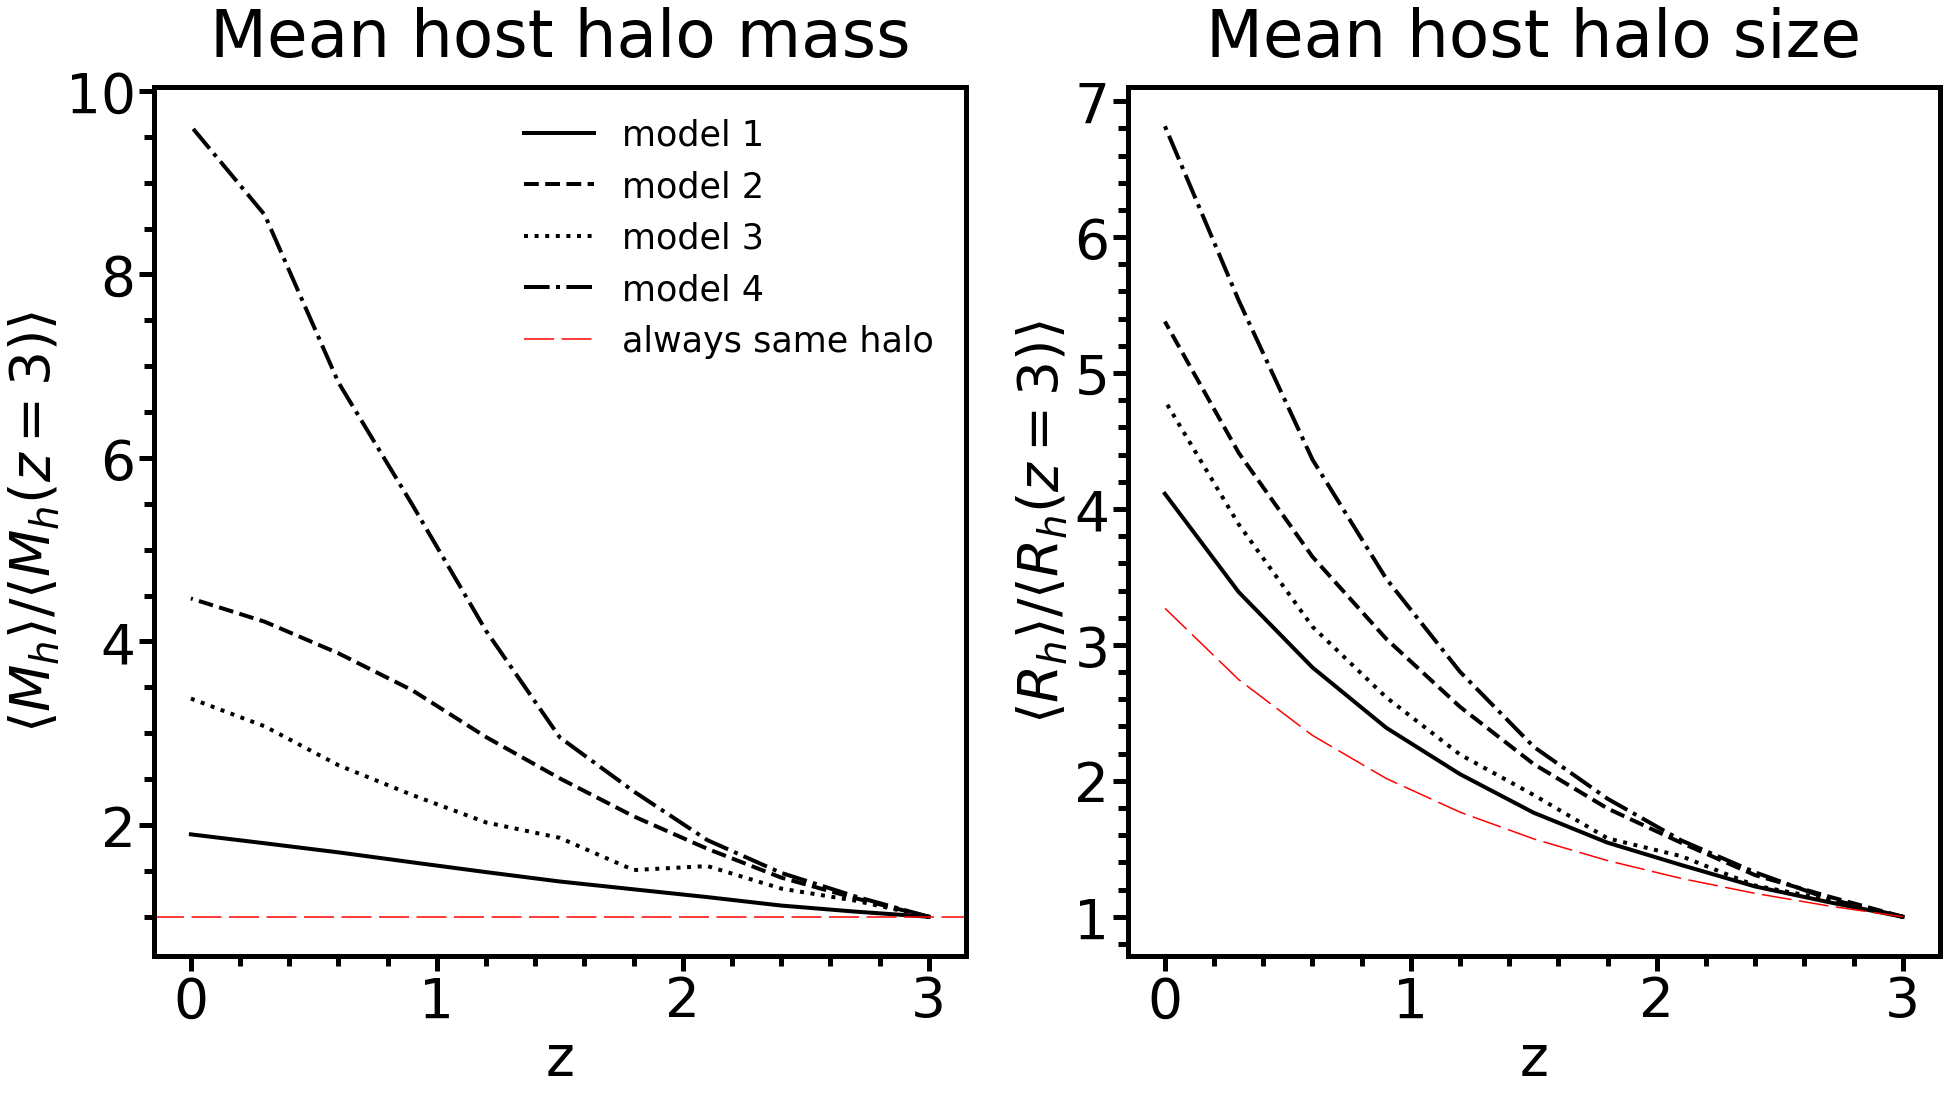

In [149]:
Vol=(400.)**3
z = 0.1
halos = utils.get_halos(z, Vol)

models = [orig,orig,new_gamma0,new_gamma0]#orig_gammaz,orig,orig_M11, orig, orig_N11]


redshifts = np.arange(0,3.3,0.3)
linestyles = ['-','--',':','-.']
colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
fig, (ax,ax2) = plt.subplots(1,2, figsize=(32,16))
x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


        
dict_0 = {}
dict_N_0 = {}

for j,(m,ls) in enumerate(zip(models,linestyles)):
    mean = []
    meanhalo = []
    for i,z in enumerate(redshifts):
        halos = utils.get_halos(z, Vol)
        halos_ = halos[halos>11.8]
        if j==0 or j==2:
            stars = m(halos,z,scatter=0.15)
        else:
            stars = m(halos,z,scatter=0.15, scatterevol=True)
            
        _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        
        mean.append(10**np.median(Re))
        mask = np.ma.masked_inside(stars,11.2,12).mask
        meanhalo.append(10**np.median(halos[mask]))
    mean = np.array(mean)
    meanhalo= np.array(meanhalo)
    ax.plot(redshifts[::-1],meanhalo[::-1]/meanhalo[::-1][0], color='black',ls=ls,lw=4, label='model {}'.format(j+1))
    ax2.plot(redshifts[::-1],mean[::-1]/mean[::-1][0], color='black',ls=ls,lw=4,)
    ax2.set_ylabel(r'$\langle R_h \rangle / \langle R_h(z=3) \rangle$')
    ax.set_ylabel(r'$\langle M_h \rangle / \langle M_h(z=3) \rangle$')
    
#f = (1+redshifts)**-0.8
#f1 = (1+redshifts)**-1.2
#ax.fill_between(redshifts,f1/f1[0],f/f[0], color='cyan',label=r'$\propto(1+z)^{-\alpha}$' '\n' r'$0.8< \alpha <1.2$', lw=4)
individual_halo = mass_so.M_to_R(10**12,mdef='vir', z=redshifts)
ax.axhline(1, color='red', dashes=[20,5,20,5],label='always same halo')
ax2.plot(redshifts[::-1], individual_halo[::-1]/individual_halo[::-1][0], color='red', dashes=[20,5,20,5])
ax2.legend(frameon=False)
ax.set_title('Mean host halo mass', pad=30)
ax2.set_title('Mean host halo size', pad=30)
ax.legend(frameon=False, fontsize=35)
#ax.set_title('Mean size evolution')
ax.set_xlabel('z')
ax2.set_xlabel('z')

plt.savefig('cartoon_cosmology_Rh.pdf', bbox_inches='tight')

# ncompact in SDSS

In [21]:
Vol = (500**3)
halos = utils.get_halos(0.1,Vol)
halos_ = halos[halos>11.7]
z=0.1
smhm = grylls19()
stars = smhm(halos,z,scatter=0.15)

bins, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                          stars=stars, masslow=11.3-0.025,massup=12.1)


n = sizefunct[1]
R = sizefunct[0]- np.mean(Re)
mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
ncompact = n[mask]



In [120]:
stars = stars[(stars>11.3) & (stars<12)]

In [ ]:
bins=np.arange(11,12.5,0.1)
H =

In [22]:
ncompact_SDSS = np.sum(n[mask])*0.05
n_SDSS_cat = cumtrapz(n,R)[-1]

In [23]:
n_SDSS, n_SDSS_cat

(0.0002165939809415441, 0.00020869600000000005)

# cmodel

In [29]:
Vol = (500**3)
halos = utils.get_halos(0.1,Vol)
halos_ = halos[halos>11.7]
z=0.1
smhm = utils.get_SMHM()
cmodel = smhm.grylls19(cmodel=True)
stars = cmodel(halos,z)

bins, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                          stars=stars, masslow=11.3-0.025,massup=12.1)


n_cmodel = sizefunct[1]
R_cmodel = sizefunct[0]- np.mean(Re)
mask_cmodel = np.ma.masked_less(R_cmodel,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
ncompact_cmodel = n_cmodel[mask_cmodel]


cmodel


In [30]:
ncompact_cmodel_integrated = np.sum(ncompact_cmodel)*0.05
n_cmodel_integrated = np.sum(n_cmodel)*0.05

In [32]:
ncompact_cmodel_integrated

7.199999999999995e-07

# progenitor bias - compact

### how quickly do compact galaxies appear and disappear?

dict_keys(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])
[2.093749999999998e-06, 1.3359374999999991e-05, 3.1812499999999974e-05, 3.704687499999997e-05, 2.7328124999999978e-05, 1.398437499999999e-05, 6.3593749999999945e-06]
dict_keys(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])
[2.156249999999998e-06, 1.5749999999999986e-05, 4.454687499999997e-05, 6.098437499999995e-05, 5.610937499999995e-05, 4.0671874999999964e-05, 2.8312499999999977e-05]
dict_keys(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])
[7.812499999999994e-08, 5.312499999999995e-07, 1.9999999999999986e-06, 3.281249999999997e-06, 2.9218749999999978e-06, 1.5781249999999988e-06, 6.406249999999995e-07]
dict_keys(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])
[9.374999999999992e-08, 8.906249999999992e-07, 6.0156249999999954e-06, 1.4437499999999987e-05, 2.0171874999999984e-05, 2.087499999999998e-05, 1.854687499999998e-05]


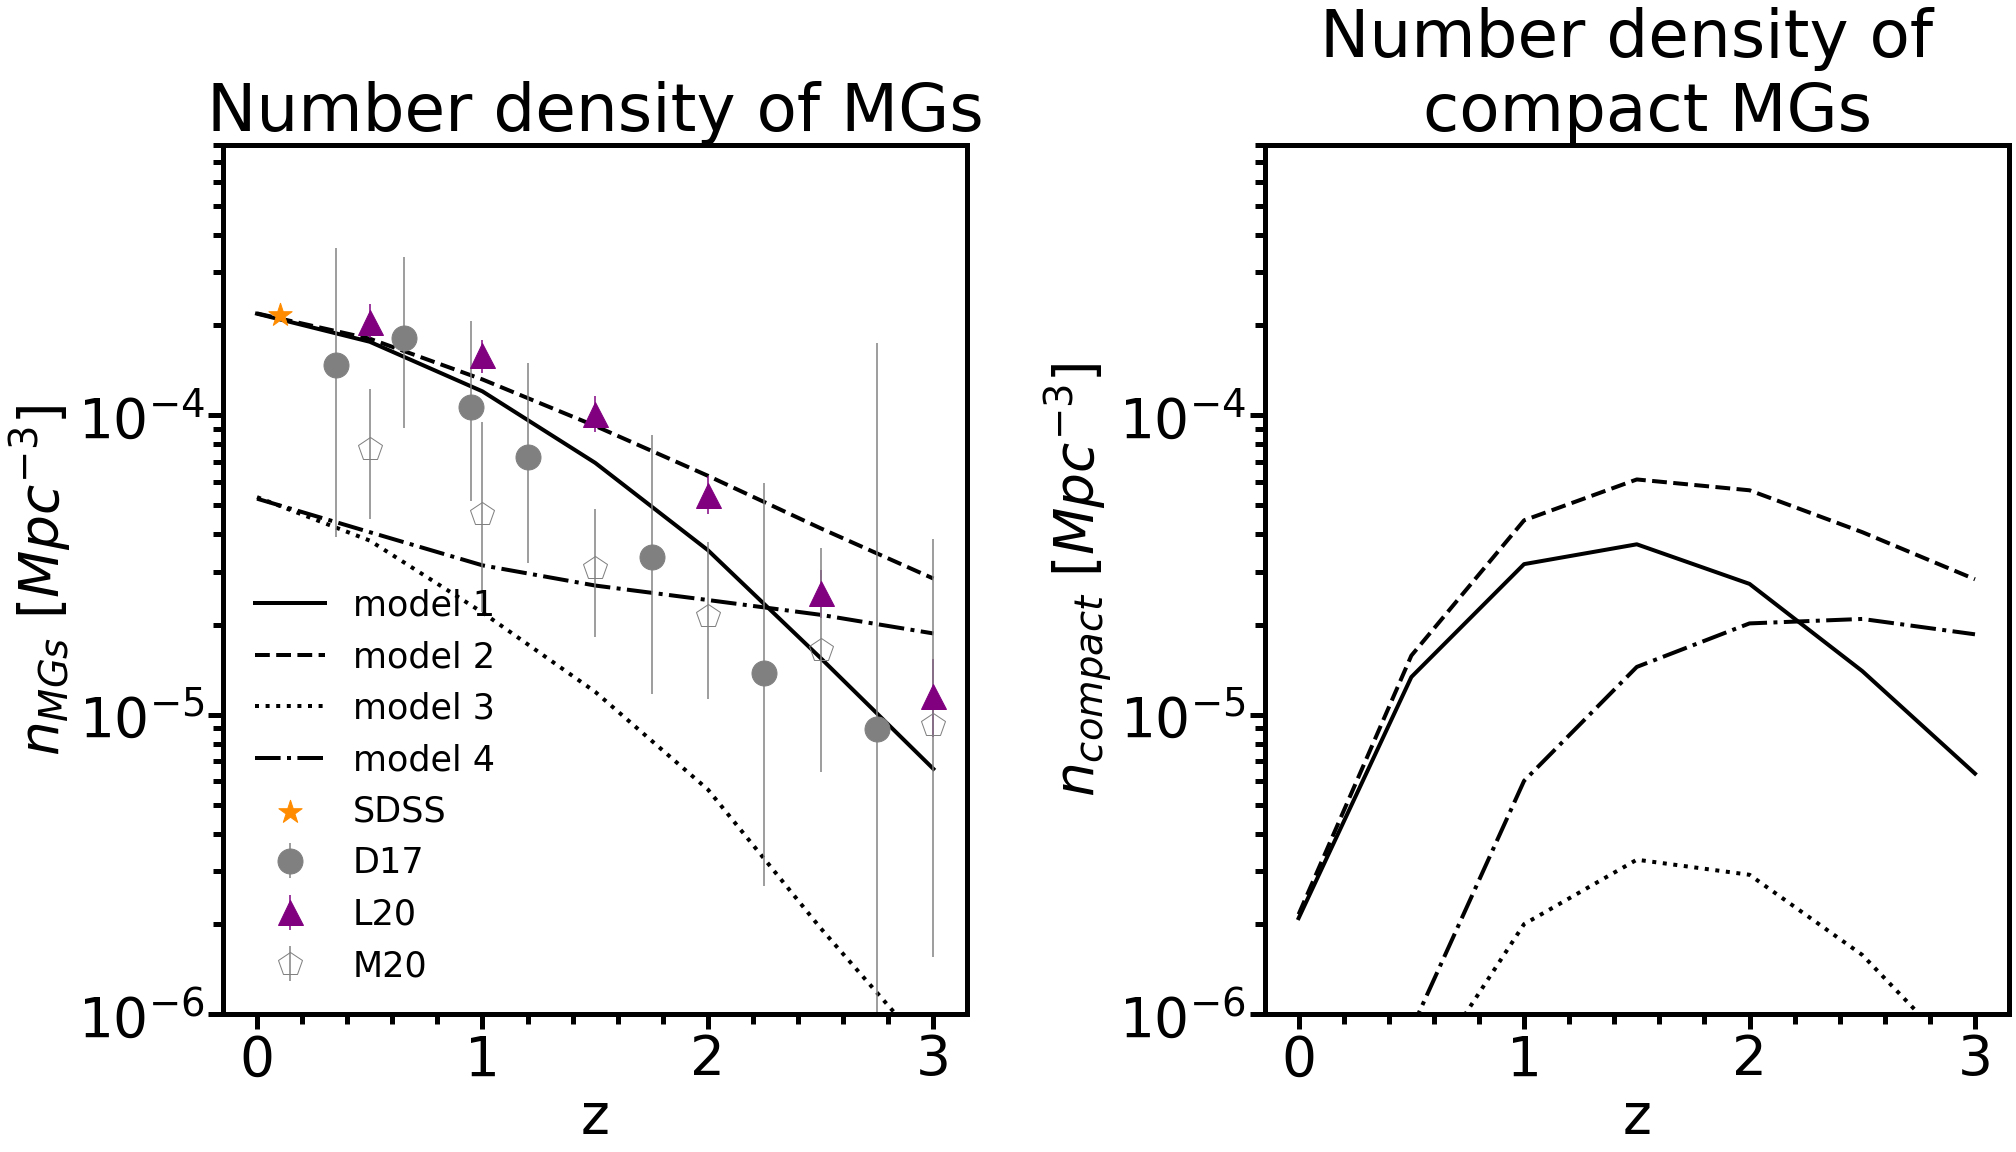

In [21]:
Vol = (400)**3
zwidth = 0.5
models = [orig]#,orig,new_gamma0,new_gamma0]
vanDerWel = True
Cassata = False
Gargiulo = False
linestyles = ['-','--',':','-.']
redshifts = np.arange(0,3.5,0.5)
fig, (ax1,ax2,) = plt.subplots(1,2,sharex=True, figsize=(32,16))
models = [orig,orig,new_gamma0,new_gamma0]
for j,(m,ls) in enumerate(zip(models, linestyles)):
    mean = []
    dict_new = {}
    for i,(z,halos) in enumerate(zip(redshifts, Halos_arr)):

        if j==0 or j==2:
            stars = m(halos,z,scatter=0.15)
        else:
            stars = m(halos,z,scatter=0.15, scatterevol=True)
            
        if Cassata:
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.3,massup=12.1)
            text = 'Cassata'
        elif vanDerWel:
            _, Re, sizefunct = utils.get_gammafunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.3,massup=12.1)
            text= 'vanderwel'
        elif Gargiulo:
            _, Re, sizefunct = utils.get_SigmaGargiulofunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.3,massup=12.1)
            text = 'Gargiulo'
        if i==0:
            new_norm = np.median(Re)
        if Cassata:
            sizefunct[0] -= new_norm        
        elif vanDerWel:
            pass
        elif Gargiulo:
            pass
        dict_new.update({str(z):sizefunct })
    N = []
    frac_compact = [] 
    Ntot = []
    print(dict_new.keys())
    for l,key in enumerate(dict_new.keys()):
        n = dict_new[key][1]
        R = dict_new[key][0]
        if Cassata:
            mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
        elif vanDerWel:
            mask = np.ma.masked_less(R,np.log10(2.5)).mask # R/(logM-11)^0.75<1.5 kpc
        elif Gargiulo:
            
            mask = np.ma.masked_greater(R,3.3).mask # M/(2piR^2)>2000 Musn/pc^2
        ncompact = n[mask]
        if l==0:
            store = ncompact.copy()
        else:
            store = ncompact.copy()
        N.append(np.sum(store)*0.05)
        Ntot.append(np.sum(n)*0.05)
        frac_compact.append(N[l]/Ntot[l])
    print(N)
    ax2.plot(redshifts, N,color='black',ls=ls, lw=4, label=f'model {j+1}',zorder=1)
    ax2.set_ylabel('$n_{compact} \ [Mpc^{-3}]$')
    ax2.set_yscale('log')

 #   ax3.plot(redshifts,frac_compact, color='black',ls=ls, lw=4, label=f'model {j+1}')
 #   ax3.set_ylabel("frac_compact")
 #   ax3.set_xlabel('z')
    
    ax1.plot(redshifts,Ntot, color='black',ls=ls, lw=4, label=f'model {j+1}',zorder=1)
    ax1.set_xlabel('z')
    ax1.set_ylabel('$n_{MGs} \ [Mpc^{-3}]$')
    ax1.set_yscale('log')
    ax1.set_ylim(1e-6,8.e-4)
    ax2.set_ylim(1e-6,8.e-4)
    #plt.yscale('log')
    ax2.set_xlabel('z')
plt.subplots_adjust(wspace=0.4)    
ax1.scatter(0.1,n_SDSS,marker='*',s=600, color='darkorange', label='SDSS',zorder=2)
ax1.errorbar(n_davidzon[:,0], n_davidzon[:,2], yerr=[n_davidzon[:,2]-n_davidzon[:,1],n_davidzon[:,3]-n_davidzon[:,2]], markersize=25, marker='o', color='gray', label='D17',ls='none')
ax1.errorbar(n_leja[:,0], n_leja[:,2], yerr=[n_leja[:,2]-n_leja[:,1],n_leja[:,3]-n_leja[:,2]], markersize=25, marker='^', color='purple', label='L20',ls='none')
ax1.errorbar(n_mcleod[:,0], n_mcleod[:,2], yerr=[n_mcleod[:,2]-n_mcleod[:,1],n_mcleod[:,3]-n_mcleod[:,2]], markersize=25, marker='p', fillstyle='none', color='gray', label='M20',ls='none')

#ax2.scatter(0.1,ncompact_SDSS,marker='*',s=600, color='darkorange', label='SDSS',zorder=2)
ax1.legend(frameon=False, fontsize=35)
ax1.set_title('Number density of MGs')
ax2.set_title('Number density of \n compact MGs')
#ax3.set_title('Fraction of compact UMGs')
fig.savefig(f'./cartoon_ncompact_{text}.pdf')

# comparison to data for size evo 

In [121]:
import pandas as pd
from astropy.stats import jackknife_stats
df = pd.read_csv('/home/lz1f17/PhD/data/SDSS/Catalog_SDSS_complete.dat', sep=' ')

In [122]:
Re_LTGs_nottrunc = df.query('MsMendSerExp>11.2 & TType>0 & logReSerExp>-1')['logReSerExpNotTrunc'].values
Re_ETGs_nottrunc = df.query('MsMendSerExp>11.2 & TType<0 & logReSerExp>-1')['logReSerExpNotTrunc'].sample(10000).values

Re_LTGs_trunc = df.query('MsMendSerExp>11.2 & TType>0 & logReSerExp>-1')['logReSerExp'].values
Re_ETGs_trunc = df.query('MsMendSerExp>11.2 & TType<0 & logReSerExp>-1')['logReSerExp'].sample(10000).values

LTGS_trunc_mean, bias, stderr, LTGS_trunc_ud = jackknife_stats(10**Re_LTGs_trunc, np.mean, 0.68)
ETGS_trunc_mean, bias, stderr, ETGS_trunc_ud = jackknife_stats(10**Re_ETGs_trunc, np.mean, 0.68)

LTGS_nottrunc_mean, bias, stderr, LTGS_nottrunc_ud = jackknife_stats(10**Re_LTGs_nottrunc, np.mean, 0.68)
ETGS_nottrunc_mean, bias, stderr, ETGS_nottrunc_ud = jackknife_stats(10**Re_ETGs_nottrunc, np.mean, 0.68)

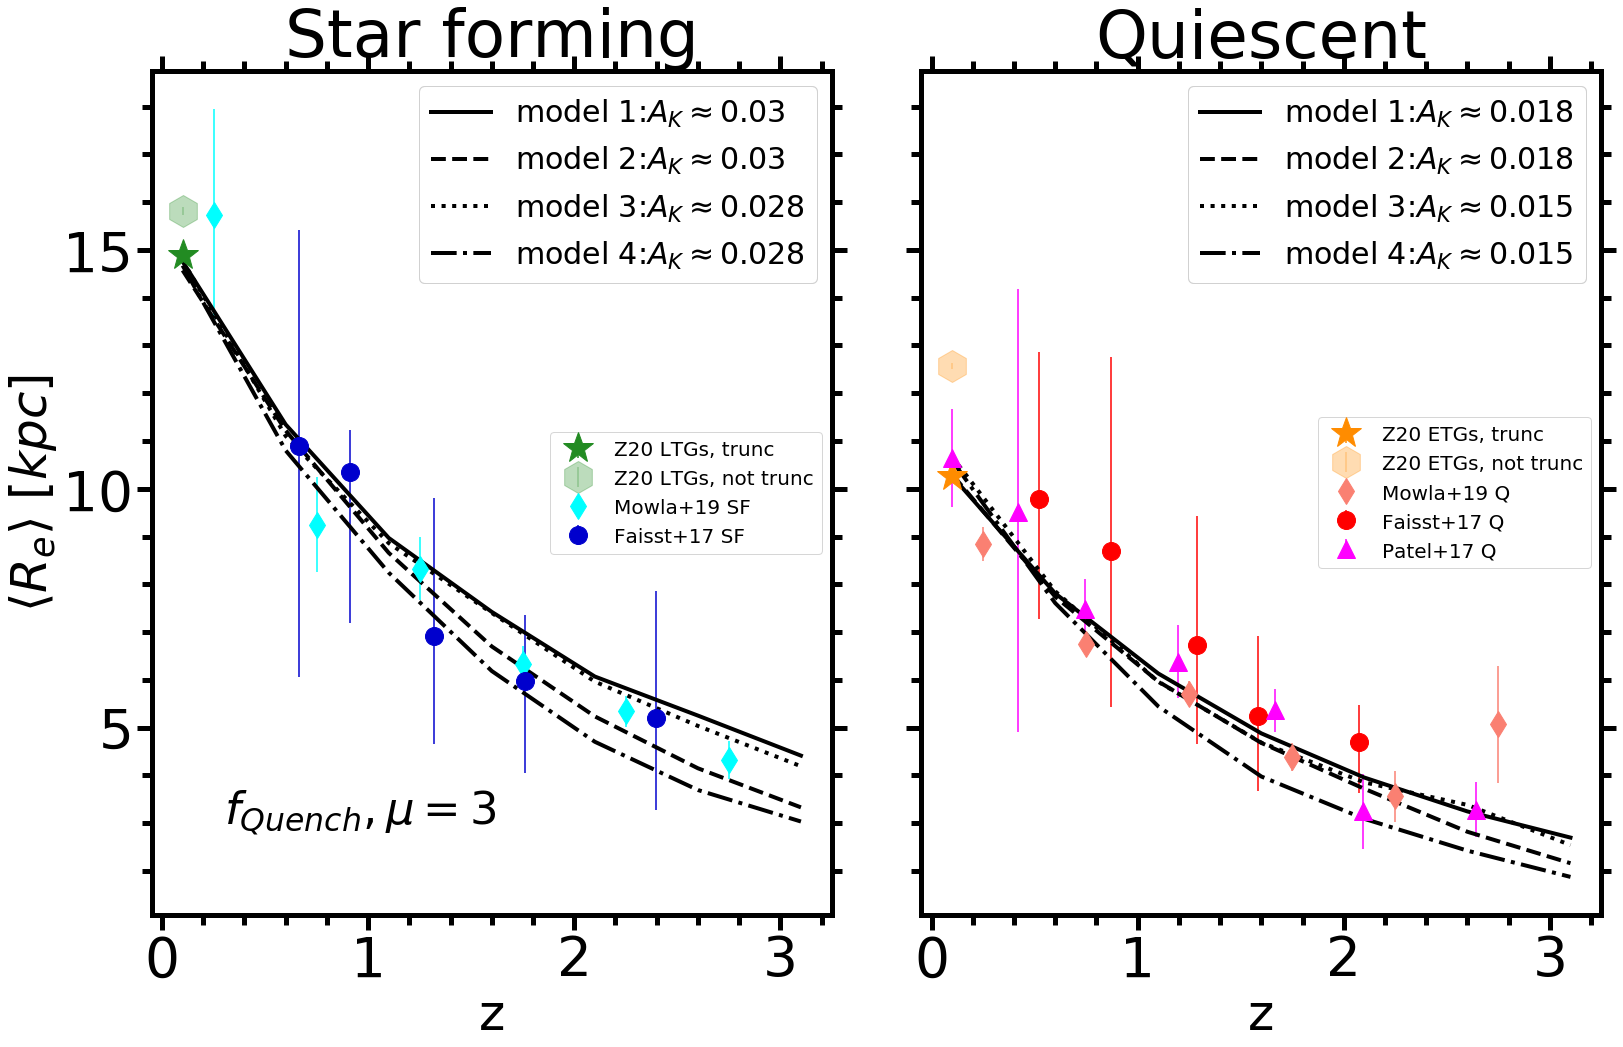

In [131]:
mu=3
def fred(x,z):
    def betaz(z):
        return 0.68+(1+(z-0.1))**mu
    beta = betaz(z)
    return 1./(1+beta*1.e12/10**x)

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(24,16), sharey=True)

Vol=(400.)**3


models = [orig,orig,new_gamma0,new_gamma0]#orig_gammaz,orig,orig_M11, orig, orig_N11]

redshifts = np.arange(0.1,3.5,0.5)
linestyles = ['-','--',':','-.']
x = np.arange(11,15,0.1)
       

for j,(m,ls) in enumerate(zip(models,linestyles)):
    
    
    ############################# blue ################
    
    mean = []
    
    for i,(z,halos) in enumerate(zip(redshifts, Halos_arr)):


        halodf = pd.DataFrame({'halos':halos})
        bl = halodf.apply(lambda x: np.random.uniform(size=len(halos)) >  fred(x,z)).values.T[0] 
        halos = halos[bl]
        if j==0 or j==2:
            stars = m(halos,z,scatter=0.15)
        else:
            stars = m(halos,z,scatter=0.15, scatterevol=True)
            
        if j==0 or j==1:
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.0215, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        elif j==2 or j==3:
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.02, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        
        mean.append(10**np.median(Re))
    mean = np.array(mean)
    ax1.plot(redshifts,mean*1.45, color='black',ls=ls,lw=4)#, label='model {}'.format(j+1))
    
    ################################ red ################
    
    mean = []
    
    for i,(z,halos) in enumerate(zip(redshifts, Halos_arr)):


        halodf = pd.DataFrame({'halos':halos})
        bl = halodf.apply(lambda x: np.random.uniform(size=len(halos)) >  fred(x,z)).values.T[0] 
        red = np.logical_not(bl)
        halos = halos[red]
        if j==0 or j==2:
            stars = m(halos,z,scatter=0.15)
        else:
            stars = m(halos,z,scatter=0.15, scatterevol=True)
            
        if j==0 or j==1:
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.0175, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        elif j==2 or j==3:
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.0147, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        
        mean.append(10**np.median(Re))
    mean = np.array(mean)
    
    ax2.plot(redshifts,mean, color='black',ls=ls,lw=4)#, label='model {}'.format(j+1))
    
ax1.set_ylabel(r'$\langle R_e \rangle$')
    
ax2.errorbar([0.1], [ETGS_trunc_mean], yerr=[ [ETGS_trunc_mean-ETGS_trunc_ud[0]], [ETGS_trunc_ud[1]-ETGS_trunc_mean]], color='darkorange', fmt='*', label='Z20 ETGs, trunc', markersize=32)
ax2.errorbar([0.1], [ETGS_nottrunc_mean], yerr=[ [ETGS_nottrunc_mean-ETGS_nottrunc_ud[0]], [ETGS_nottrunc_ud[1]-ETGS_nottrunc_mean]], color='darkorange', fmt='h', label='Z20 ETGs, not trunc', markersize=32, alpha=0.3)

ax1.errorbar([0.1], [LTGS_trunc_mean], yerr=[ [LTGS_trunc_mean-LTGS_trunc_ud[0]], [LTGS_trunc_ud[1]-LTGS_trunc_mean]], color='forestgreen', fmt='*', label='Z20 LTGs, trunc', markersize=32)
ax1.errorbar([0.1], [LTGS_nottrunc_mean], yerr=[ [LTGS_nottrunc_mean-LTGS_nottrunc_ud[0]], [LTGS_nottrunc_ud[1]-LTGS_nottrunc_mean]], color='forestgreen', fmt='h', label='Z20 LTGs, not trunc', markersize=32, alpha=0.3)

z, med,sigma = np.loadtxt('/home/lz1f17/PhD/data/Mowla18/Mowla18_Q.txt', unpack=True)
ax2.errorbar(z, med, yerr=sigma, linestyle = 'None', color='salmon', marker='d', label = 'Mowla+19 Q', markersize=18)
z, med,down,up = np.loadtxt('/home/lz1f17/PhD/data/Faisst17_Data_Figure4/Faisst17_Data_Figure4_quiescent_M4.csv', delimiter=',',skiprows=1,
                           usecols=(0,1,3,4), unpack=True)
ax2.errorbar(z, med, yerr=[med-down,up-med], linestyle = 'None', color='red', marker='o', label = 'Faisst+17 Q ', markersize=18)
z,up, med,down = np.loadtxt('/home/lz1f17/PhD/data/Patel_vdw.dat', unpack=True)
ax2.errorbar(z, med, yerr=[med-down,up-med], linestyle = 'None', color='magenta', marker='^', label = 'Patel+17 Q', markersize=18)

z, med,sigma = np.loadtxt('/home/lz1f17/PhD/data/Mowla18/Mowla18_SF.txt', unpack=True)
ax1.errorbar(z, med, yerr=sigma, linestyle = 'None', color='cyan', marker='d', label = 'Mowla+19 SF', markersize=18)
z, med,down,up = np.loadtxt('/home/lz1f17/PhD/data/Faisst17_Data_Figure4/Faisst17_Data_Figure4_starforming_M4.csv', delimiter=',',skiprows=1,
                           usecols=(0,1,3,4), unpack=True)
ax1.errorbar(z, med, yerr=[med-down,up-med], linestyle = 'None', color='mediumblue', marker='o', label = 'Faisst+17 SF ', markersize=18)

leg1 = ax1.legend(fontsize=20, loc='center right')
leg1_2 = ax2.legend( fontsize=20, loc='center right')


lines = [Line2D([0], [0], color='black', linewidth=4, linestyle=ls) for ls in linestyles]
labels = [f'model {mod}:'+r'$A_K\approx$'+f'{ak}' for mod, ak in zip([1,2,3,4],[0.03,0.03,0.028,0.028])]

leg2 = ax1.legend(lines, labels, loc='upper right',  fontsize=30)    
ax1.add_artist(leg1)
ax1.add_artist(leg2)

labels = [f'model {mod}:'+r'$A_K\approx$'+f'{ak}' for mod, ak in zip([1,2,3,4],[0.018,0.018,0.015,0.015])]
leg2_2 = ax2.legend(lines, labels, loc='upper right',  fontsize=30)    
ax2.add_artist(leg1_2)
ax2.add_artist(leg2_2)



ax1.set_xlabel('z', fontsize=50)
ax2.set_xlabel('z', fontsize=50)
ax1.set_ylabel(r'$\langle R_e \rangle \ [kpc]$', fontsize=50)
ax1.set_title('Star forming')
ax2.set_title('Quiescent')
ax1.text(0.3,3, '$f_{Quench}, \mu=3$', fontsize=45)
for a in [ax1,ax2]:
    a.xaxis.set_ticks_position("both")
    a.yaxis.set_ticks_position("both")
fig.tight_layout()
plt.savefig('/home/lz1f17/Pictures/Paper/K13_SF_Q.pdf', bbox_inches='tight')

### test with evolving knee

KeyboardInterrupt: 

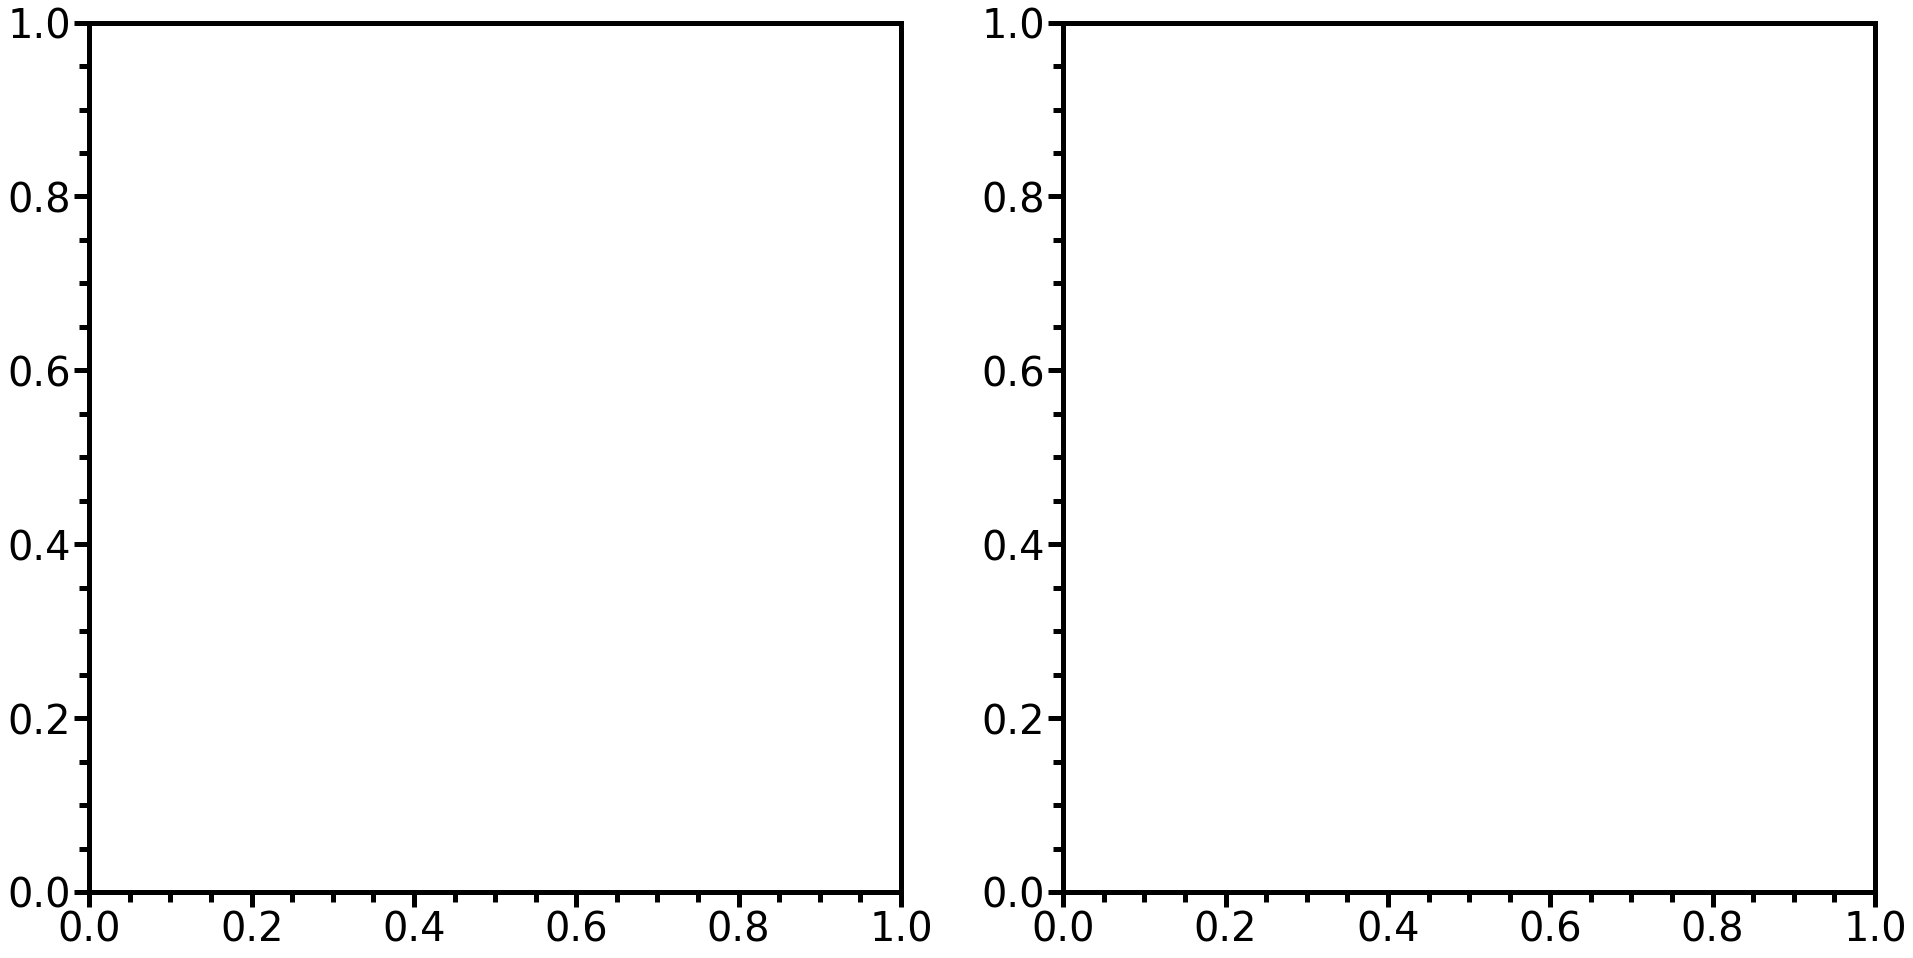

In [74]:
Vol = (400)**3
zwidth = 0.5
redshifts = np.arange(0,3.5,zwidth)
fig, (ax1,ax2,) = plt.subplots(1,2,sharex=True, figsize=(32,16))

g19 = grylls19()
models = [orig,orig, g19, g19]
model_names = ['model 1','model 2','G19','G19+$\sigma_{SMHM}$ evol.' ]
for j,(m,ls, mod_lab) in enumerate(zip(models, linestyles, model_names)):
    mean = []
    dict_new = {}
    for i,(z,halos) in enumerate(redshifts, Halos_arr):
        
        if j==0 or j==2:
            stars = m(halos,z,scatter=0.15)
        else:
            stars = m(halos,z,scatter=0.15, scatterevol=True)    
        
        _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        
        if i==0:
            new_norm = np.median(Re)
        
        sizefunct[0] -= new_norm        
        dict_new.update({str(z):sizefunct })
    N = []
    frac_compact = [] 
    Ntot = []
    print(dict_new.keys())
    for l,key in enumerate(dict_new.keys()):
        n = dict_new[key][1]
        R = dict_new[key][0]
        mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
        ncompact = n[mask]
        if l==0:
            store = ncompact.copy()
        else:
            store = ncompact.copy()
        N.append(np.sum(store)*0.05)
        Ntot.append(np.sum(n)*0.05)
        frac_compact.append(N[l]/Ntot[l])
    ax2.plot(redshifts, N,color='black',ls=ls, lw=4, label=mod_lab,zorder=1)
    ax2.set_ylabel('$n_{compact} \ [Mpc^{-3}]$')
    ax2.set_yscale('log')

 #   ax3.plot(redshifts,frac_compact, color='black',ls=ls, lw=4, label=f'model {j+1}')
 #   ax3.set_ylabel("frac_compact")
 #   ax3.set_xlabel('z')
    
    ax1.plot(redshifts,Ntot, color='black',ls=ls, lw=4, label=mod_lab,zorder=1)
    ax1.set_xlabel('z')
    ax1.set_ylabel('$n_{MGs} \ [Mpc^{-3}]$')
    ax1.set_yscale('log')
    ax1.set_ylim(1e-6,8.e-4)
    ax2.set_ylim(1e-6,8.e-4)
    #plt.yscale('log')
    ax2.set_xlabel('z')
ax1.scatter(0.1,n_SDSS,marker='*',s=600, color='darkorange', label='SDSS',zorder=2)
ax2.scatter(0.1,ncompact_SDSS,marker='*',s=600, color='darkorange', label='SDSS',zorder=2)
plt.subplots_adjust(wspace=0.4)    
ax1.legend(frameon=False, fontsize=35)
ax1.set_title('Number density of MGs')
ax2.set_title('Number density of \n compact MGs')
#ax3.set_title('Fraction of compact UMGs')
fig.savefig('./cartoon_ncompact_G19.pdf')

# cartoon f_quench

dict_keys(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])
dict_keys(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])
dict_keys(['0.0', '0.5', '1.0', '1.5', '2.0', '2.5', '3.0'])


/home/lz1f17/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:97: RuntimeWarning: divide by zero encountered in log10


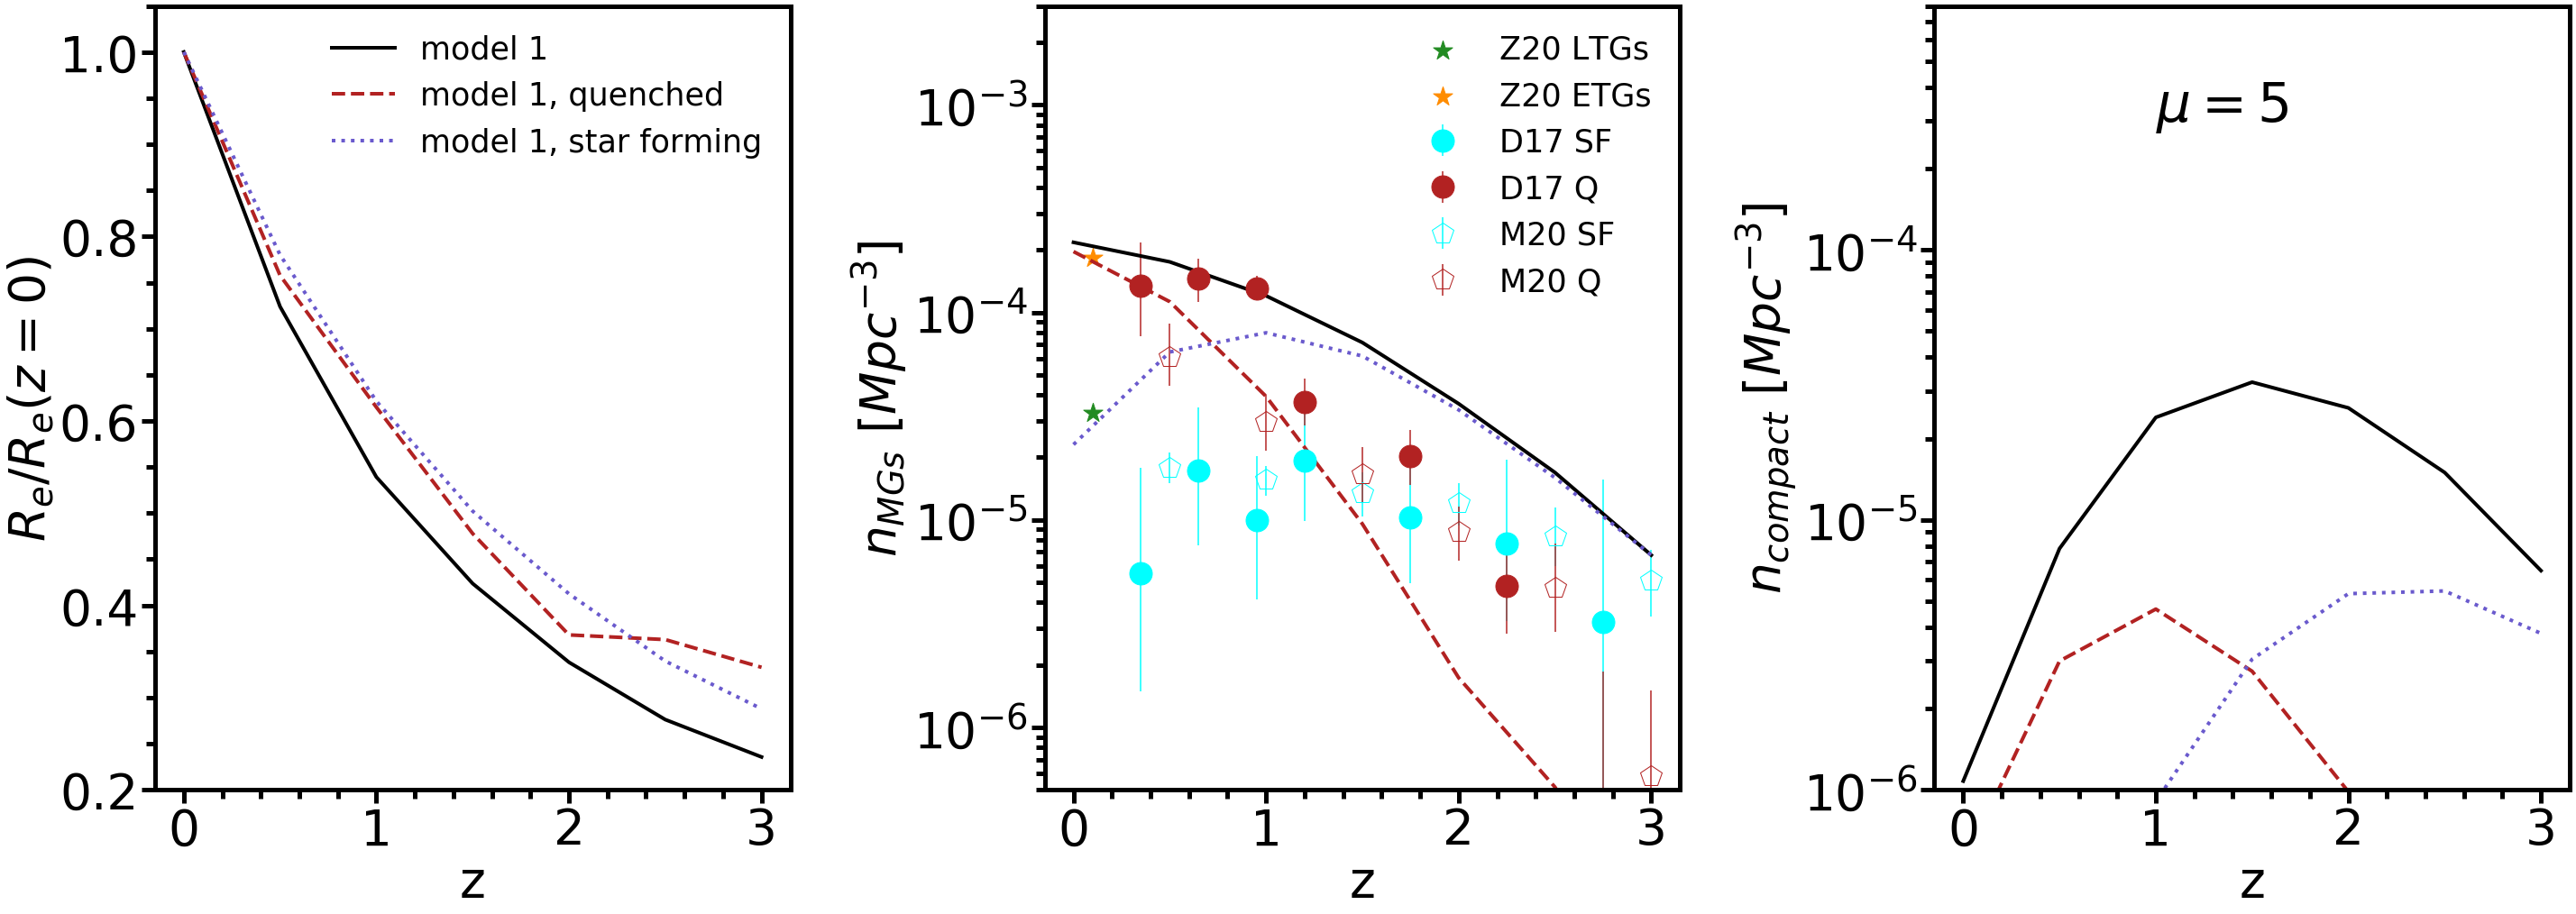

In [136]:
mu=5


def fred(x,z):
    def betaz(z):
        return 0.68+(1+z)**mu
    beta = betaz(z)
    return 1./(1+beta*1.e12/10**x)

Vol = (400)**3
models = [orig,orig,orig]#orig_gammaz,orig,orig_M11, orig, orig_N11]
linestyles = ['-','--',':']#,':','-.','-.']
model_colors = ['black','firebrick','slateblue']
zwidth = 0.5
redshifts = np.arange(0,3.5,zwidth)
fig, (a1,a2,a3) = plt.subplots(1,3, figsize=(48,16))
for j,(m,ls,model_color) in enumerate(zip(models, linestyles, model_colors)):
    mean = []
    
    if j==1:
        Re_mean_red = [] #save mean size of red galaxies
        
    dict_new = {}
    colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
    colors_blue = iter(plt.cm.Blues(np.linspace(0.2,1,len(redshifts))))
    colors_black = iter(plt.cm.Greys(np.linspace(0.2,1,len(redshifts))))

    for i,(z,halos,c,cb,cbl) in enumerate(zip(redshifts,Halos_arr,colors,colors_black,colors_blue)):

        if j==0:
            stars = m(halos,z,scatter=0.15)
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.3,massup=12.1)
        elif j==1:
            #fquench model
            halodf = pd.DataFrame({'halos':halos})
            bl = halodf.apply(lambda x: np.random.uniform(size=len(halos)) >  fred(x,z)).values.T[0] 
            red = np.logical_not(bl)
            halos = halos[red]
            stars = m(halos,z,scatter=0.15)
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.3,massup=12.1)
        elif j==2:
            #fquench model
            halodf = pd.DataFrame({'halos':halos})
            bl = halodf.apply(lambda x: np.random.uniform(size=len(halos)) >  fred(x,z)).values.T[0] 
            halos = halos[bl]
            stars = m(halos,z,scatter=0.15)
            _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.03, sigma_K=0.1,\
                                                  stars=stars, masslow=11.3,massup=12.1)
            
        
        
        
        if i==0:
            if j==0 or j==1:
                new_norm = np.median(Re)
                if  j ==1 :
                    Re_mean_red.append(new_norm)
            if j==2 :
                new_norm = Re_mean_red[0] # normalize according to the size-mass of QGs at z=0
        sizefunct[0] -= new_norm        
#        if i==0 or i==3 or i==5:
#            if j==0:
#                pass
#                #a2.plot(sizefunct[0],sizefunct[1],color=cb,ls=ls,lw=4,  )
#            elif j==1:
#                a2.plot(sizefunct[0],sizefunct[1],color=c,ls=ls,lw=4,  )
#            elif j==2:
#                a2.plot(sizefunct[0],sizefunct[1],color=cbl,ls=ls,lw=4,  )
#        a2.set_yscale('log')
        dict_new.update({str(z):sizefunct })
        mean.append(10**np.median(Re))
    
    mean = np.array(mean)
    if j==0:
        a1.plot(redshifts,mean/mean[0], color=model_color,ls='-',lw=4, label='model 1')
    elif j==1:
        a1.plot(redshifts,mean/mean[0], color=model_color,ls='--',lw=4, label=r'model 1, quenched')
    elif j==2:
        a1.plot(redshifts,mean/mean[0], color=model_color,ls=':',lw=4, label=r'model 1, star forming')
    
        
    grad = []
    N = []
    frac_compact = [] 
    Ntot = []
    print(dict_new.keys())
    for l,key in enumerate(dict_new.keys()):
        n = dict_new[key][1]
        R = dict_new[key][0]
        mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
        ncompact = n[mask]
        if l==0:
            store = ncompact.copy()
        else:
            grad.append(np.log10(np.sum(store*0.05))-np.log10(np.sum(ncompact*0.05)))
            store = ncompact.copy()
        Ntot.append(np.sum(n)*0.05)
        N.append(np.sum(store)*0.05)

    a2.plot(redshifts, Ntot,color=model_color,ls=ls, lw=4, )
    a3.plot(redshifts, N,color=model_color,ls=ls, lw=4, )
    a2.set_ylabel('$n_{MGs} \ [Mpc^{-3}]$')
    a3.set_ylabel('$n_{compact} \ [Mpc^{-3}]$')
    a3.set_yscale('log')

    a2.set_yscale('log')
    a3.set_ylim(1e-6,8.e-4)
    a2.set_ylim(5.e-7,3.e-3)
    #a2.set_xlim(-1.5,1)
    #plt.yscale('log')
    a1.set_ylim(0.2,1.05)
a2.scatter([0.1], n_LTGs_SDSS, color='forestgreen', marker='*', s=500, label='Z20 LTGs')
a2.scatter([0.1], n_ETGs_SDSS, color='darkorange', marker='*', s=500, label='Z20 ETGs')
#a2.scatter(0.1,n_SDSS,marker='*',s=600, color='darkorange', label='SDSS',zorder=2)
#a2.errorbar(n_davidzon[:,0], n_davidzon[:,2], yerr=[n_davidzon[:,2]-n_davidzon[:,1],n_davidzon[:,3]-n_davidzon[:,2]], markersize=15, marker='o', color='gray', label='D17')
#a2.errorbar(n_leja[:,0], n_leja[:,2], yerr=[n_leja[:,2]-n_leja[:,1],n_leja[:,3]-n_leja[:,2]], markersize=15, marker='^', color='purple', label='L20')
#a3.scatter(0.1,ncompact_SDSS,marker='*',s=600, color='darkorange', label='SDSS',zorder=2)
a2.errorbar(n_davidzon_SF[:,0], n_davidzon_SF[:,2], yerr=[n_davidzon_SF[:,2]-n_davidzon_SF[:,1],n_davidzon_SF[:,3]-n_davidzon_SF[:,2]], markersize=25, marker='o', color='cyan', label='D17 SF',ls='none')
a2.errorbar(n_davidzon_Q[:,0], n_davidzon_Q[:,2], yerr=[n_davidzon_Q[:,2]-n_davidzon_Q[:,1],n_davidzon_Q[:,3]-n_davidzon_Q[:,2]], markersize=25, marker='o', color='firebrick', label='D17 Q',ls='none')
#a2.errorbar(n_mcleod[:,0], n_mcleod[:,2], yerr=[n_mcleod[:,2]-n_mcleod[:,1],n_mcleod[:,3]-n_mcleod[:,2]], markersize=15, marker='p',fillstyle='none', color='gray', label='M20')
a2.errorbar(n_mcleod_SF[:,0], n_mcleod_SF[:,2], yerr=[n_mcleod_SF[:,2]-n_mcleod_SF[:,1],n_mcleod_SF[:,3]-n_mcleod_SF[:,2]], markersize=25, marker='p',fillstyle='none', color='cyan', label='M20 SF',ls='none')
a2.errorbar(n_mcleod_Q[:,0], n_mcleod_Q[:,2], yerr=[n_mcleod_Q[:,2]-n_mcleod_Q[:,1],n_mcleod_Q[:,3]-n_mcleod_Q[:,2]], markersize=25, marker='p',fillstyle='none', color='firebrick', label='M20 Q',ls='none')


a3.set_ylabel('$n_{compact} \ [Mpc^{-3}]$')
a1.set_ylabel('$R_e/R_e(z=0)$')
#a2.set_ylabel('$$')
a2.set_xlabel('z')
a1.set_xlabel('z')
a3.set_xlabel('z')
a3.text(1.,3.e-4,r'$\mu=$'+'{}'.format(mu), fontsize=60)
plt.subplots_adjust(wspace=0.4)    
a1.legend(frameon=False, fontsize=35)
a2.legend(frameon=False, fontsize=35)

fig.savefig(f'cartoon_fquench_mu{mu}_gamma05.pdf')

(0.00013989555962146214, 1.9194999727014246e-05, 0.0005927039999999995)

# continuity equation

In [23]:
def fred(x,z,mu):
    def betaz(z,mu):
        return 0.68+(1+z)**mu
    beta = betaz(z,mu)
    return 1./(1+beta*1.e12/10**x)

zwidth = 0.3
redshifts = np.arange(0,3.3,zwidth)

def continuity(mu):
    Vol = (700)**3
    models = [orig,orig]#orig_gammaz,orig,orig_M11, orig, orig_N11]
    linestyles = ['--',':']#,':','-.','-.']
    model_colors = ['firebrick','slateblue']

    #fig, a1 = plt.subplots(1,1, figsize=(16,16))
    for j,(m,ls,model_color) in enumerate(zip(models, linestyles, model_colors)):
        mean = []

        if j==0:
            Re_mean_red = [] #save mean size of red galaxies

        dict_new = {}
        colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
        colors_blue = iter(plt.cm.Blues(np.linspace(0.2,1,len(redshifts))))
        colors_black = iter(plt.cm.Greys(np.linspace(0.2,1,len(redshifts))))

        for i,(z,c,cb,cbl) in enumerate(zip(redshifts,colors,colors_black,colors_blue)):
            halos = utils.get_halos(z, Vol)
            halos_ = halos[halos>11.7]

            if j==0:
                #fquench model: red
                halodf = pd.DataFrame({'halos':halos})
                bl = halodf.apply(lambda x: np.random.uniform(size=len(halos)) >  fred(x,z,mu)).values.T[0] 
                red = np.logical_not(bl)
                halos = halos[red]
                stars = m(halos,z,scatter=0.15)#, scatterevol=True)
                _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                      stars=stars, masslow=11.2,massup=12)
            elif j==1:
                #fquench model: blue
                halodf = pd.DataFrame({'halos':halos})
                bl = halodf.apply(lambda x: np.random.uniform(size=len(halos)) >  fred(x,z,mu)).values.T[0] 
                halos = halos[bl]
                stars = m(halos,z,scatter=0.15)#, scatterevol=True)
                _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.024, sigma_K=0.1,\
                                                      stars=stars, masslow=11.2,massup=12)


            if i==0:
                if j==0:
                    new_norm = np.median(Re)
                    Re_mean_red.append(new_norm)
                if j==1 :
                    new_norm = Re_mean_red[0] # normalize according to the size-mass of QGs at z=0
            sizefunct[0] -= new_norm        

            dict_new.update({str(z):sizefunct })
            mean.append(10**np.median(Re))

        mean = np.array(mean)

        grad = []
        N = []
        frac_compact = [] 
        Ntot = []
        print(dict_new.keys())
        for l,key in enumerate(dict_new.keys()):
            n = dict_new[key][1]
            R = dict_new[key][0]
            mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
            ncompact = n[mask]
            if l==0:
                store = ncompact.copy()
            else:
                grad.append(np.sum(store*0.05)-np.sum(ncompact*0.05))
                store = ncompact.copy()
            Ntot.append(np.sum(n)*0.05)
            N.append(np.sum(store)*0.05)
        if j==0:
            grad_red = np.array(grad).copy()
            N_red = np.array(N).copy()
        if j==1:
            grad_blue = np.array(grad).copy()
            N_blue = np.array(N).copy()
    #Y = grad_red + grad_blue    
    return grad_red, grad_blue, N_red, N_blue
#plt.title(r'$\mu=1$')
#a1.plot(redshifts[1:]-zwidth/2., Y)
#plt.ylabel(r'$\frac{dn_{Q}}{dz}+ \frac{dn_{SF}}{dz}$')
#plt.yscale('symlog')
#plt.xlabel('z')
#plt.subplots_adjust(wspace=0.4)    
#a1.legend(frameon=False, fontsize=35)
#fig.savefig('continuity_mu1_gamma05.pdf')

In [24]:
#grad_red_1, grad_blue_1, N_red_1, N_blue_1 = continuity(mu=1)
grad_red_3, grad_blue_3, N_red_3, N_blue_3 = continuity(mu=3)

dict_keys(['0.0', '0.3', '0.6', '0.8999999999999999', '1.2', '1.5', '1.7999999999999998', '2.1', '2.4', '2.6999999999999997', '3.0'])
dict_keys(['0.0', '0.3', '0.6', '0.8999999999999999', '1.2', '1.5', '1.7999999999999998', '2.1', '2.4', '2.6999999999999997', '3.0'])


In [17]:
from matplotlib.ticker import Locator

class MinorSymLogLocator(Locator):
    """
    Dynamically find minor tick positions based on the positions of
    major ticks for a symlog scaling.
    """
    def __init__(self, linthresh):
        """
        Ticks will be placed between the major ticks.
        The placement is linear for x between -linthresh and linthresh,
        otherwise its logarithmically
        """
        self.linthresh = linthresh

    def __call__(self):
        'Return the locations of the ticks'
        majorlocs = self.axis.get_majorticklocs()

        # iterate through minor locs
        minorlocs = []

        # handle the lowest part
        for i in range(1, len(majorlocs)):
            majorstep = majorlocs[i] - majorlocs[i-1]
            if abs(majorlocs[i-1] + majorstep/2) < self.linthresh:
                ndivs = 10
            else:
                ndivs = 9
            minorstep = majorstep / ndivs
            locs = np.arange(majorlocs[i-1], majorlocs[i], minorstep)[1:]
            minorlocs.extend(locs)

        return self.raise_if_exceeds(np.array(minorlocs))

    def tick_values(self, vmin, vmax):
        raise NotImplementedError('Cannot get tick locations for a '
                                  '%s type.' % type(self))


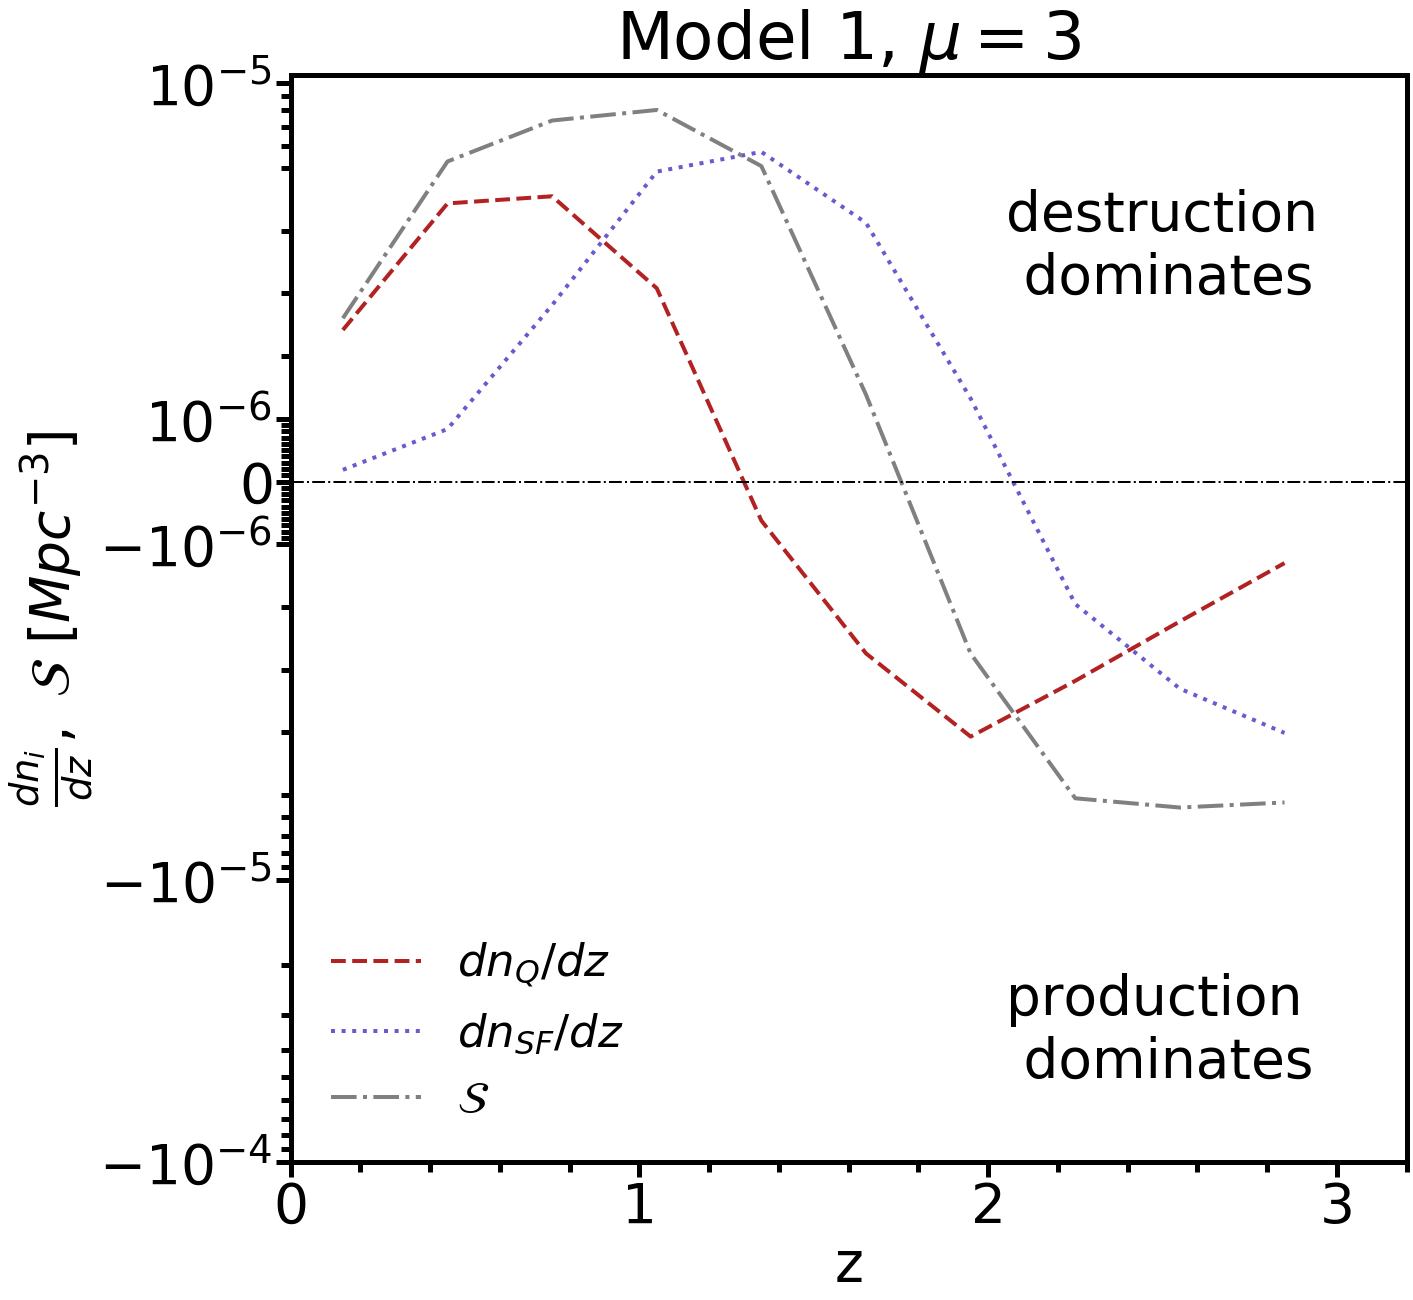

In [29]:
fig, (a2) = plt.subplots(1,1, figsize=(20,20))#, False=True)

#a1.set_title(r'$\mu=1$')
a2.plot(redshifts[1:]-zwidth/2., -grad_red_3,ls='--', color='firebrick', lw=4,  label=r'$dn_{Q}/dz$')
a2.plot(redshifts[1:]-zwidth/2., -grad_blue_3,ls=':', color='slateblue', lw=4,  label=r'$dn_{SF}/dz$')
a2.plot(redshifts[1:]-zwidth/2., -grad_blue_3-grad_red_3,ls='-.', color='gray', lw=4,  label=r'$\mathcal{S}$')


a2.set_ylabel(r'$\frac{dn_i}{dz}, \ \mathcal{S} \ [Mpc^{-3}]$')
a1.set_xlabel('z')
a1.set_yscale('symlog',linthreshy=1.e-4)
#a2.set_title(r'$\mu=3$')
#a2.plot(redshifts[1:]-zwidth/2., -grad_red_3,ls='--', color='salmon', lw=4)
#a2.plot(redshifts[1:]-zwidth/2., -grad_blue_3,ls=':', color='cyan', lw=4)
#a2.plot(redshifts, N_red_3,ls='--', color='firebrick', lw=8, label=r'$n_{compact}$ quenched')
#a2.plot(redshifts, N_blue_3,ls=':', color='slateblue', lw=8, label=r'$n_{compact}$ star forming')
#x = np.arange(1000,1000)


#plt.ylabel(r'$\frac{dn_{Q}}{dz}+ \frac{dn_{SF}}{dz}$')
a2.set_xlabel('z')
a2.set_yscale('symlog',linthreshy=5.e-6)
a1.set_yscale('log')#,linthreshy=5.e-6)

locmaj = tck.LogLocator(base=10,numticks=4) 

a1.yaxis.set_minor_locator(MinorSymLogLocator(5.e-6))
a2.yaxis.set_minor_locator(MinorSymLogLocator(5.e-6))
a2.set_ylim(-1.e-4)
a1.axhline(0, ls='-.', lw=2, color='black')
a2.axhline(0, ls='-.', lw=2, color='black')
fig.subplots_adjust(wspace=0.4)    
a1.legend(frameon=False, fontsize=45)
a2.legend(frameon=False, fontsize=45, loc='lower left')
a2.text(2.05,3.e-6, 'destruction\n dominates')
a2.text(2.05,-5.e-5, 'production\n dominates')
a2.set_title('Model 1, $\mu=3$')
a2.set_xlim(0,3.2)
plt.savefig('continuity_mu3_gamma05.png', bbox_inches='tight')

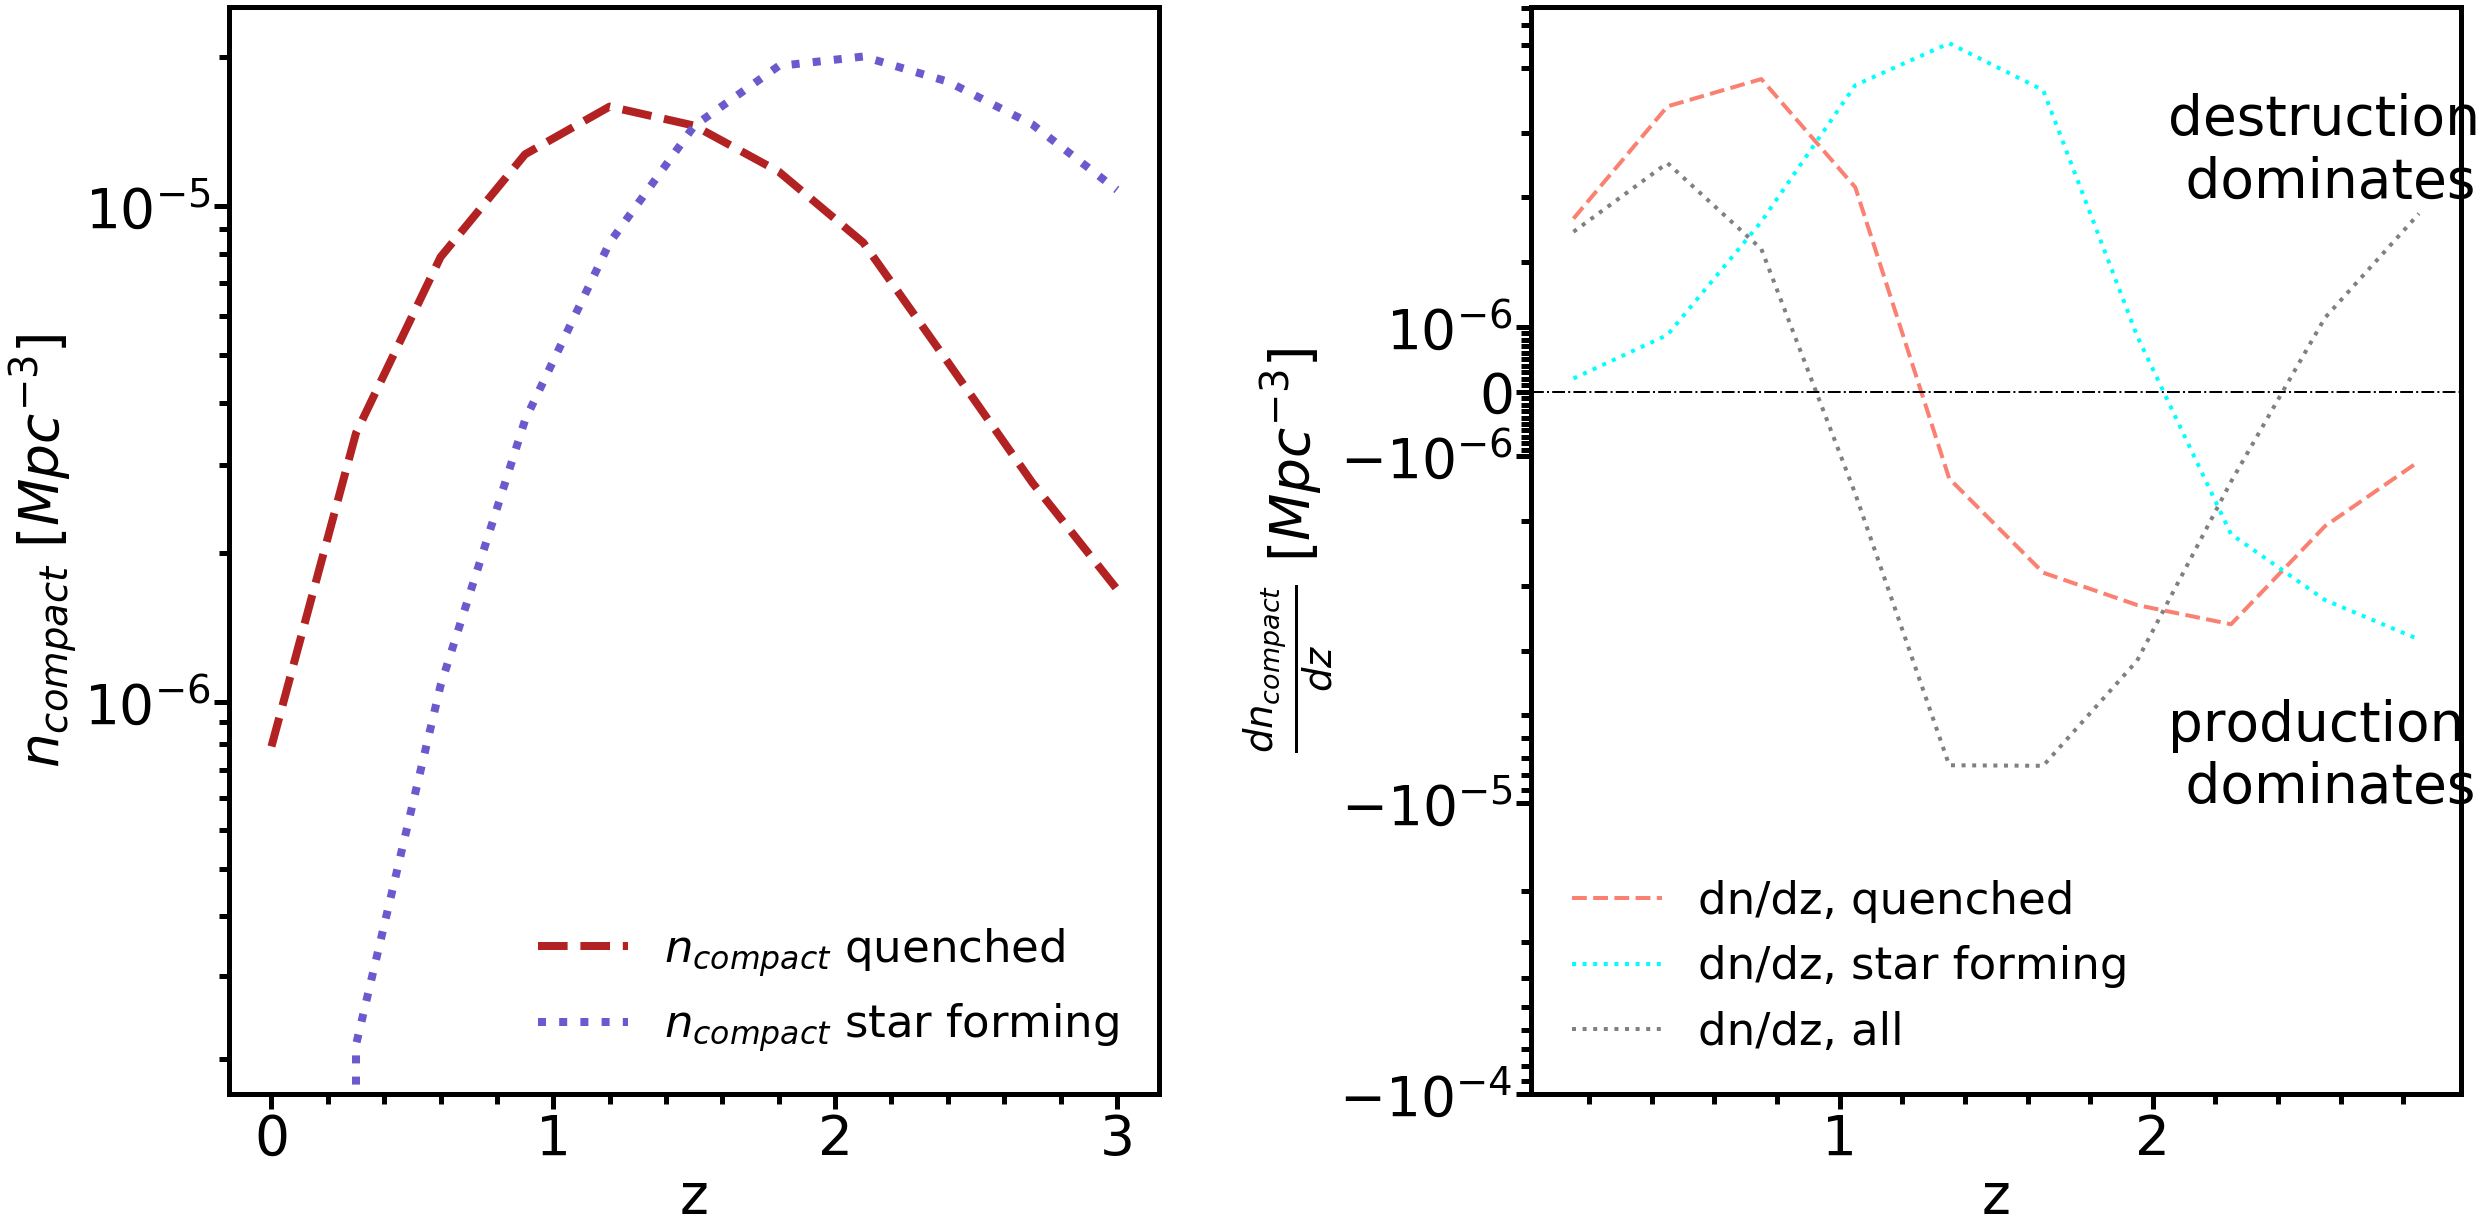

In [9]:
fig, (a1,a2) = plt.subplots(1,2, figsize=(40,20))#, False=True)

zwidth = 0.3
redshifts = np.arange(0,3.3,zwidth)
#a1.set_title(r'$\mu=1$')
a2.plot(redshifts[1:]-zwidth/2., -grad_red_3,ls='--', color='salmon', lw=4,  label='dn/dz, quenched')
a2.plot(redshifts[1:]-zwidth/2., -grad_blue_3,ls=':', color='cyan', lw=4,  label='dn/dz, star forming')
a2.plot(redshifts[1:]-zwidth/2., -grad_blue_3-grad_red_3,ls=':', color='gray', lw=4,  label='dn/dz, all')

a1.plot(redshifts, N_red_3,ls='--', color='firebrick', lw=8,label=r'$n_{compact}$ quenched')
a1.plot(redshifts, N_blue_3,ls=':', color='slateblue', lw=8,label=r'$n_{compact}$ star forming')
#plt.ylabel(r'$\frac{dn_{Q}}{dz}+ \frac{dn_{SF}}{dz}$')
a1.set_ylabel(r'$n_{compact} \ [Mpc^{-3}]$')
a2.set_ylabel(r'$\frac{dn_{compact}}{dz}  \ [Mpc^{-3}]$')
a1.set_xlabel('z')
a1.set_yscale('symlog',linthreshy=1.e-4)
#a2.set_title(r'$\mu=3$')
#a2.plot(redshifts[1:]-zwidth/2., -grad_red_3,ls='--', color='salmon', lw=4)
#a2.plot(redshifts[1:]-zwidth/2., -grad_blue_3,ls=':', color='cyan', lw=4)
#a2.plot(redshifts, N_red_3,ls='--', color='firebrick', lw=8, label=r'$n_{compact}$ quenched')
#a2.plot(redshifts, N_blue_3,ls=':', color='slateblue', lw=8, label=r'$n_{compact}$ star forming')
#x = np.arange(1000,1000)


#plt.ylabel(r'$\frac{dn_{Q}}{dz}+ \frac{dn_{SF}}{dz}$')
a2.set_xlabel('z')
a2.set_yscale('symlog',linthreshy=5.e-6)
a1.set_yscale('log')#,linthreshy=5.e-6)

locmaj = tck.LogLocator(base=10,numticks=4) 

a1.yaxis.set_minor_locator(MinorSymLogLocator(5.e-6))
a2.yaxis.set_minor_locator(MinorSymLogLocator(5.e-6))
a2.set_ylim(-1.e-4)
a1.axhline(0, ls='-.', lw=2, color='black')
a2.axhline(0, ls='-.', lw=2, color='black')
fig.subplots_adjust(wspace=0.4)    
a1.legend(frameon=False, fontsize=45)
a2.legend(frameon=False, fontsize=45)
a2.text(2.05,3.e-6, 'destruction\n dominates')
a2.text(2.05,-1.e-5, 'production\n dominates')
plt.savefig('continuity_mu3_gamma05_scatterevol.png')

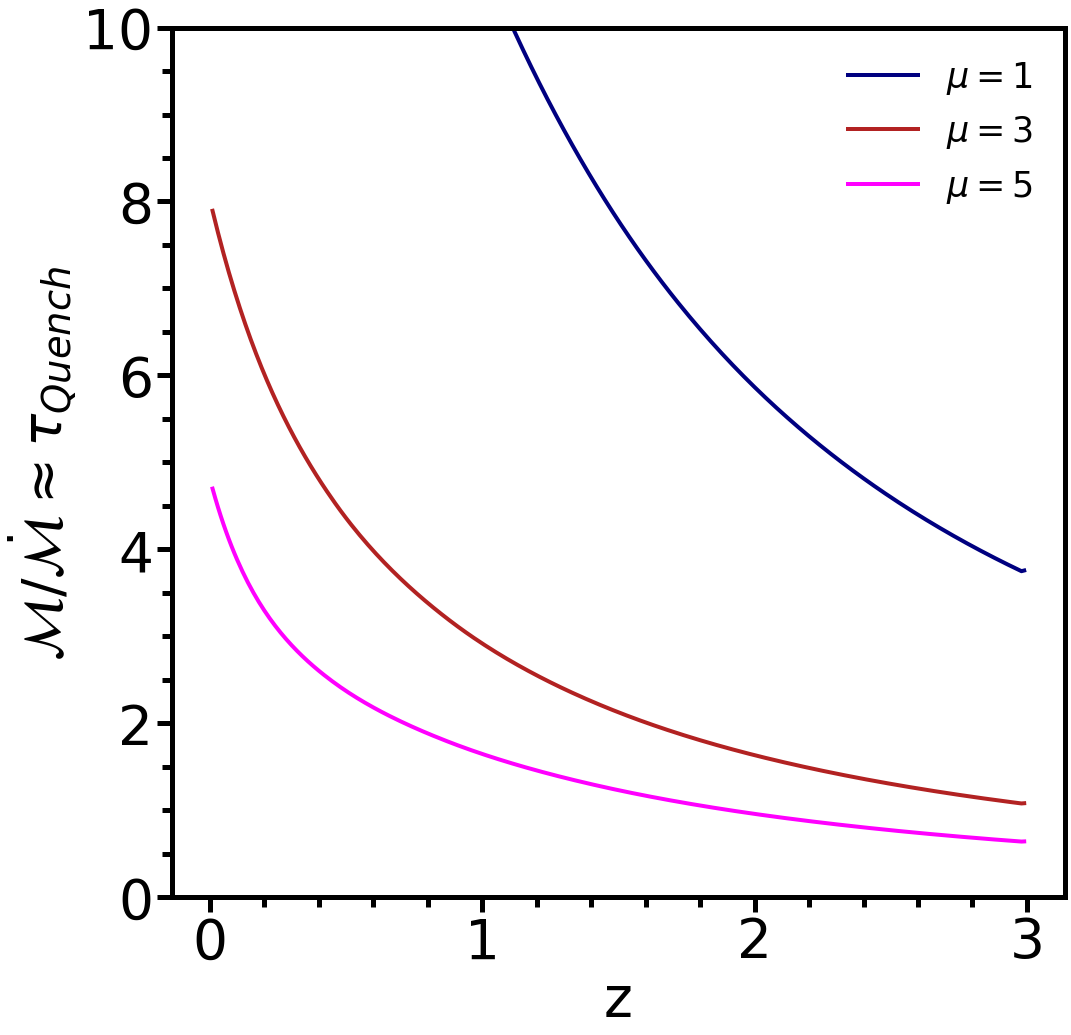

In [55]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

def fred(x,z,mu):
    def betaz(z,mu):
        return 0.68+(1+z)**mu
    beta = betaz(z,mu)
    return 1./(1+beta*1.e12/10**x)
def betaz(z,mu):
    return np.log10((0.68+(1+z)**mu)) + 12
def dbetaz(z,mu):
    
    dt = t[1:] - t[:-1]
    dt = np.insert(dt, -1, dt[-1])
    dz = x[1:]-x[:-1]
    dz = np.insert(dz, -1, dz[-1])
    dlogM_dz = (mu*(1+z)**(mu-1))/(0.68+(1+z)**mu) 
    dlogM_dt = dlogM_dz*dz/dt
    
    return 1/dlogM_dt # returns M/Mdot=timescale of quenching
plt.rcParams['figure.figsize'] = (16,16)

x = np.arange(0.01,3,0.01)
t = cosmol.age(x)
lookback = cosmol.age(0.01)-t # the derivative of the lookback is the negative of the derivative of the age
plt.plot(x, -dbetaz(x,mu=1), label=r'$\mu=1$', color='navy', lw=4)
plt.plot(x, -dbetaz(x,mu=3), label=r'$\mu=3$', color='firebrick', lw=4)
plt.plot(x, -dbetaz(x,mu=5), label=r'$\mu=4$', color='magenta', lw=4)
#plt.plot(x, dbetaz(x,mu=1), label='der, mu=1')
plt.ylabel(r'$\mathcal{M}/\dot{\mathcal{M}}\approx \tau_{Quench}$')
plt.legend(frameon=False, fontsize=35)
plt.xlabel('z')
plt.ylim(0,10)
plt.savefig('cartoon_tauQuench.pdf', bbox_inches='tight')

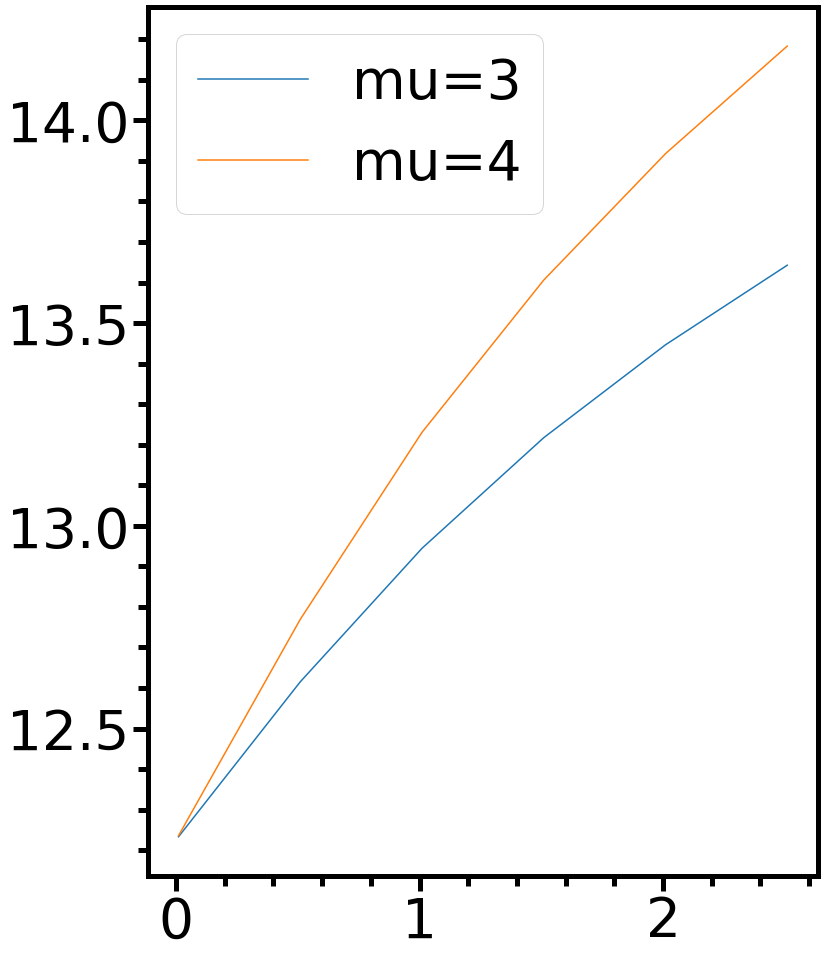

In [197]:
x = np.arange(0.01,3,0.5)

plt.plot(x, betaz(x,mu=3), label='mu=3')
plt.plot(x, betaz(x,mu=4),label='mu=4')
plt.legend()

# concentration

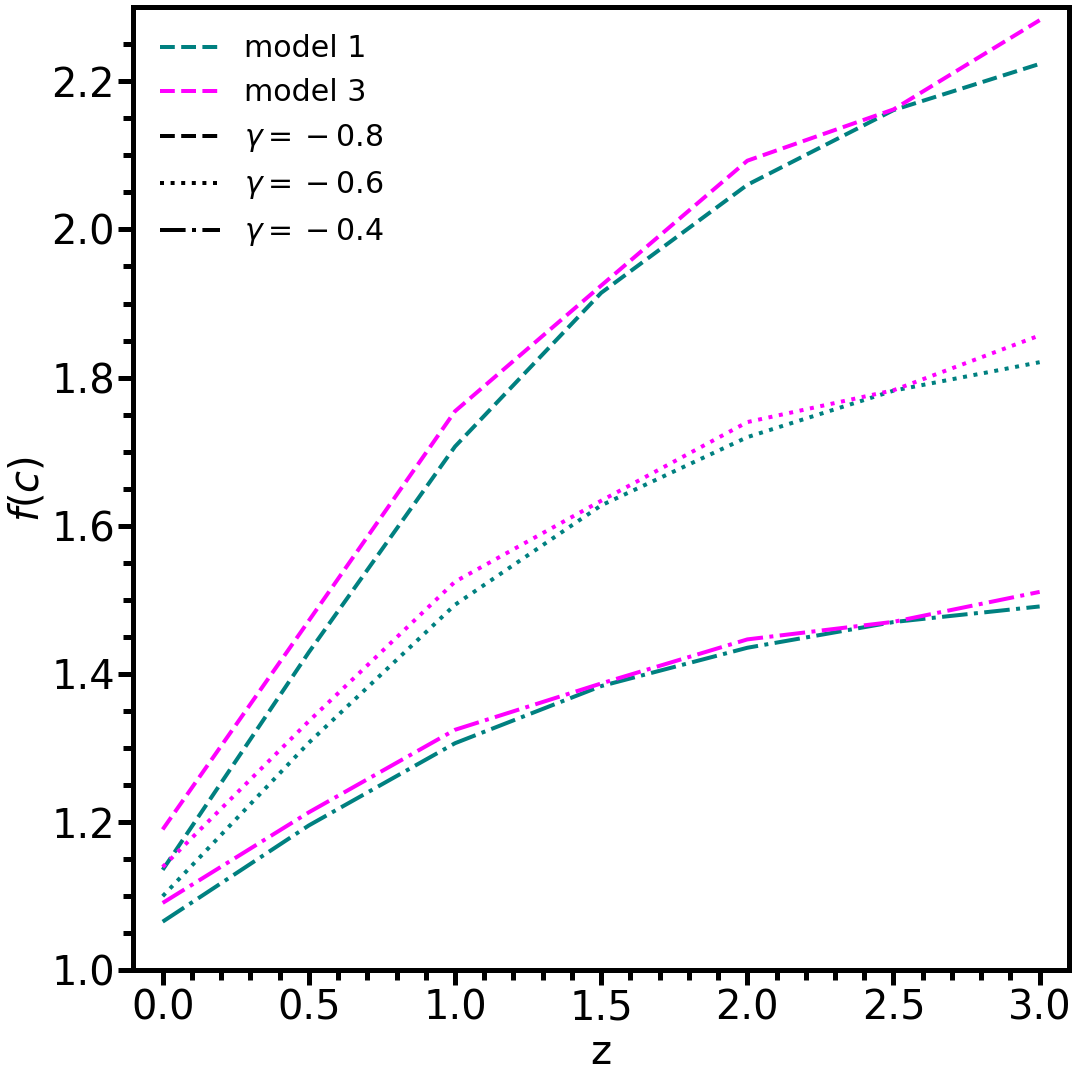

In [59]:
def concentrationDuttonMaccio14(x,z):
    '''accepts M/h'''
    
    x = 10**(x+np.log10(0.7))
    b =-0.097 +0.024*z
    a=0.537 + (1.025-0.537)*np.e**(-0.718*z**1.08)

    logc = a+b*(np.log10(x)-12)

  
    sc = 0.11

    c  = 10**(np.random.normal(logc,scale=sc))
    return c

redshifts = np.arange(0,3.5,0.5)
SMHM_ = utils.get_SMHM()
SMHMs = [orig,new_gamma0]
labels = ['model 1','model 3']
colors = ['teal','magenta']
plt.rcParams['figure.figsize'] = (16,16)
for SMHM, (lab, c) in zip(SMHMs, zip(labels, colors)):
    conc06 = []
    conc08 = []
    conc04 = []
    for z in redshifts:
        Vol=(350.)**3
        halos = utils.get_halos(z, Vol)
        halos = halos[halos>11.7]
        
        if lab=='model 1':
            stars = SMHM(halos, z, scatter=0.15)
        else:
            stars = SMHM(halos, z, scatter=0.15)#, scatterevol=True)
            
        mask = np.ma.masked_greater(stars, 11.2).mask
        halos_ = halos[mask]
        conc = concentrationDuttonMaccio14(halos_,z)
        
        conc08_ = (conc/10)**(-0.8)
        conc06_ = (conc/10)**(-0.6)
        conc04_ = (conc/10)**(-0.4)
        
        conc06.append(np.median(conc06_))
        conc08.append(np.median(conc08_))
        conc04.append(np.median(conc04_))
    plt.plot(redshifts, conc08, color=c, ls='--', label=lab, lw=4)
    plt.plot(redshifts, conc06, color=c, ls=':', lw=4)
    plt.plot(redshifts, conc04, color=c, ls='-.', lw=4)
plt.plot(1000*np.arange(100,1000), 1000*np.arange(100,1000), lw=4, ls='--', label='$\gamma=-0.8$', color='black')
plt.plot(1000*np.arange(100,1000), 1000*np.arange(100,1000), lw=4, ls=':', label='$\gamma=-0.6$', color='black')
plt.plot(1000*np.arange(100,1000), 1000*np.arange(100,1000), lw=4, ls='-.', label='$\gamma=-0.4$', color='black')
plt.xlabel('z')
plt.ylabel('$f(c)$')
plt.xlim(-0.1,3.1)
plt.ylim(1.,2.3)
plt.legend(frameon=False, fontsize=30)
plt.tight_layout()
plt.savefig('fc_model1_model3.pdf')

0.15
0.15811388300841897
0.18027756377319948
0.21213203435596428
0.25


No handles with labels found to put in legend.


0.291547594742265
0.33541019662496846


No handles with labels found to put in legend.


0.15
0.15811388300841897
0.18027756377319948
0.21213203435596428
0.25


No handles with labels found to put in legend.


0.291547594742265
0.33541019662496846


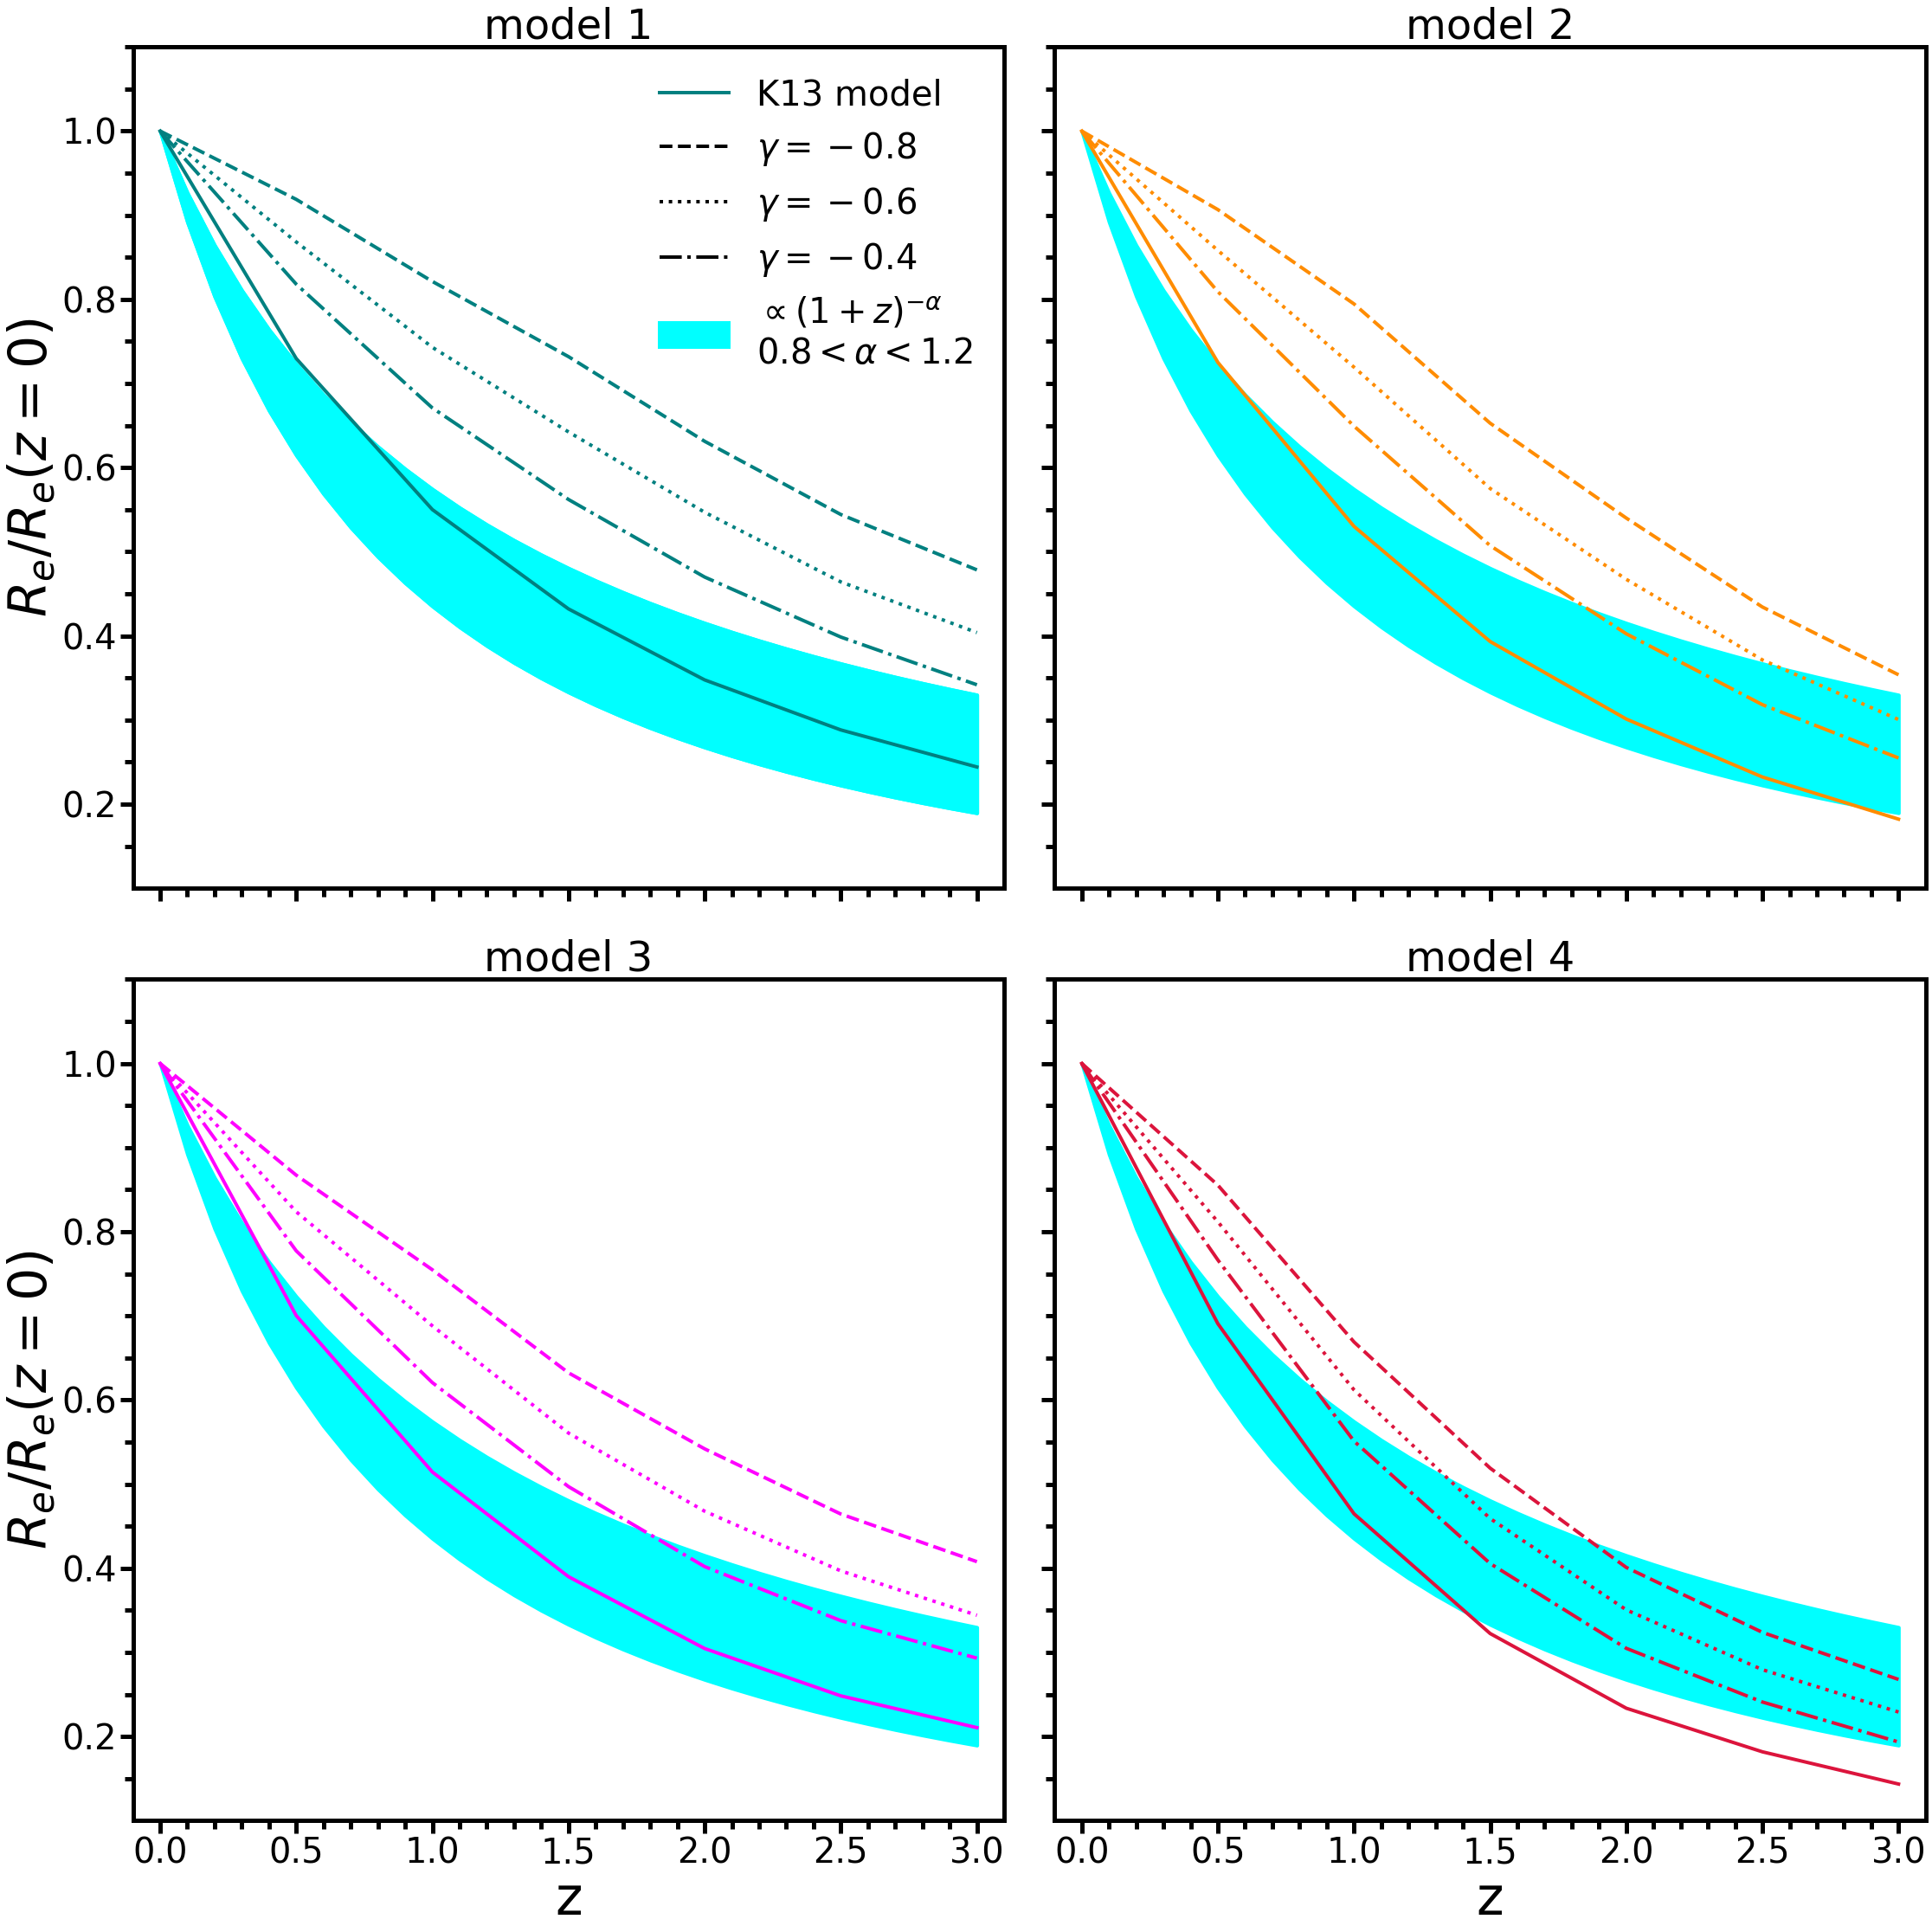

In [57]:
def concentrationDuttonMaccio14(x,z):
    '''accepts M/h'''
    
    x = 10**(x+np.log10(0.7))
    b =-0.097 +0.024*z
    a=0.537 + (1.025-0.537)*np.e**(-0.718*z**1.08)

    logc = a+b*(np.log10(x)-12)

  
    sc = 0.11

    c  = 10**(np.random.normal(logc,scale=sc))
    return c

redshifts = np.arange(0,3.5,0.5)
SMHM_ = utils.get_SMHM()
SMHMs = [orig,orig,new_gamma0,new_gamma0]
labels = ['model 1','model 2','model 3','model 4']
colors = ['teal','darkorange','magenta','crimson']
fig,ax = plt.subplots(2,2,figsize=(32,32),sharex=True, sharey=True)
for SMHM, (lab, c,a) in zip(SMHMs, zip(labels, colors,ax.ravel())):
    conc06 = []
    conc08 = []
    conc04 = []
    Rmean = []
    for z in redshifts:
        Vol=(350.)**3
        halos = utils.get_halos(z, Vol)
        halos = halos[halos>11.7]
        
        if lab=='model 1' or lab=='model 3':
            stars = SMHM(halos, z, scatter=0.15)
        else:
            stars = SMHM(halos, z, scatter=0.15, scatterevol=True)
            
        mask = np.ma.masked_greater(stars, 11.2).mask
        halos_ = halos[mask]
        R = utils.get_Rh(halos_,z)
        conc = concentrationDuttonMaccio14(halos_,z)
        
        conc08_ = R*(conc/10)**(-0.8)
        conc06_ = R*(conc/10)**(-0.6)
        conc04_ = R*(conc/10)**(-0.4)
        
        conc06.append(np.median(conc06_))
        conc08.append(np.median(conc08_))
        conc04.append(np.median(conc04_))
        Rmean.append(np.median(R))
    if lab=='model 1':
        a.plot(redshifts,Rmean/Rmean[0], color=c, label='K13 model',ls='-', lw=4)
    else:
        a.plot(redshifts,Rmean/Rmean[0], color=c, ls='-', lw=4)
    a.plot(redshifts, conc08/conc08[0], color=c, ls='--',  lw=4)
    a.plot(redshifts, conc06/conc06[0], color=c, ls=':', lw=4)
    a.plot(redshifts, conc04/conc04[0], color=c, ls='-.', lw=4)
    a.set_xlim(-0.1,3.1)
    a.set_ylim(0.1,1.1)
    xx = np.arange(0,3.1,0.1)
    f = (1+xx)**-0.8
    f1 = (1+xx)**-1.2
    a.fill_between(xx,f1/f1[0],f/f[0], color='cyan', lw=4)
    if lab=='model 1':
        a.fill_between(xx,f1/f1[0],f/f[0], color='cyan',label=r'$\propto(1+z)^{-\alpha}$' '\n' r'$0.8< \alpha <1.2$', lw=4)
        a.plot(1000*np.arange(100,1000), 1000*np.arange(100,1000), lw=4, ls='--', label='$\gamma=-0.8$', color='black')
        a.plot(1000*np.arange(100,1000), 1000*np.arange(100,1000), lw=4, ls=':', label='$\gamma=-0.6$', color='black')
        a.plot(1000*np.arange(100,1000), 1000*np.arange(100,1000), lw=4, ls='-.', label='$\gamma=-0.4$', color='black')

    a.legend(frameon=False, fontsize=40)
    a.set_title(lab)

ax[1][0].set_xlabel('z',fontsize=60)
ax[1][1].set_xlabel('z',fontsize=60)
ax[0][0].set_ylabel('$R_e/R_e(z=0)$',fontsize=60)
ax[1][0].set_ylabel('$R_e/R_e(z=0)$',fontsize=60)

fig.tight_layout()
fig.savefig('concmodel.pdf')

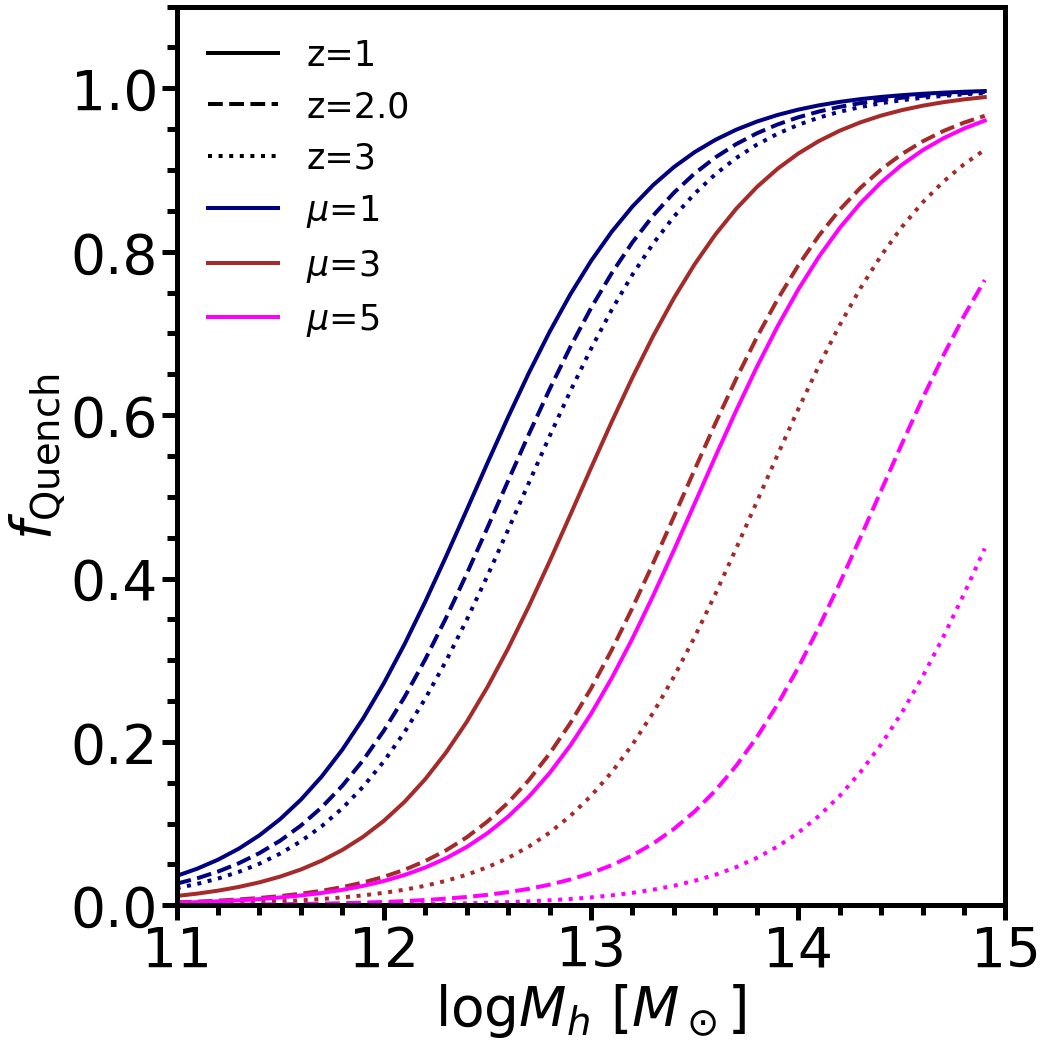

In [54]:
def fred(x,z,mu):
    def betaz(z):
        return 0.68+(1+z)**mu
    beta = betaz(z)
    return 1./(1+beta*1.e12/10**x)

zz = [1,2.,3]
mu = [1,3,5]
hh = np.arange(11,15,0.1)
colors = ['navy','brown','magenta']
ls = ['-','--',':','-.']
plt.rcParams['figure.figsize'] = (16,16)
for m,c in zip(mu,colors):
    for z,l in zip(zz,ls):
        plt.plot(hh,fred(hh,z,m), color=c,lw=4,ls=l)
        if m==1:
            plt.plot(1000*hh,1000*hh,color='black',lw=4,ls=l, label=f'z={z}')
    plt.plot(1000*hh,1000*hh,color=c,lw=4,ls='-',label=r'$\mu$='+str(m))
plt.xlim(11,15)
plt.ylim(0,1.1)
plt.legend(frameon=False, fontsize=35)
plt.xlabel('$\log{M_h} \ [M_\odot]$')
plt.ylabel(r'$f_{\rm Quench}$')
plt.tight_layout()
plt.savefig('fquench_mu1_3_5.pdf', bbox_inches='tight')

# explore adding covariance between SMHM and K13 relation


AttributeError: module 'matplotlib.pylab' has no attribute 'y'

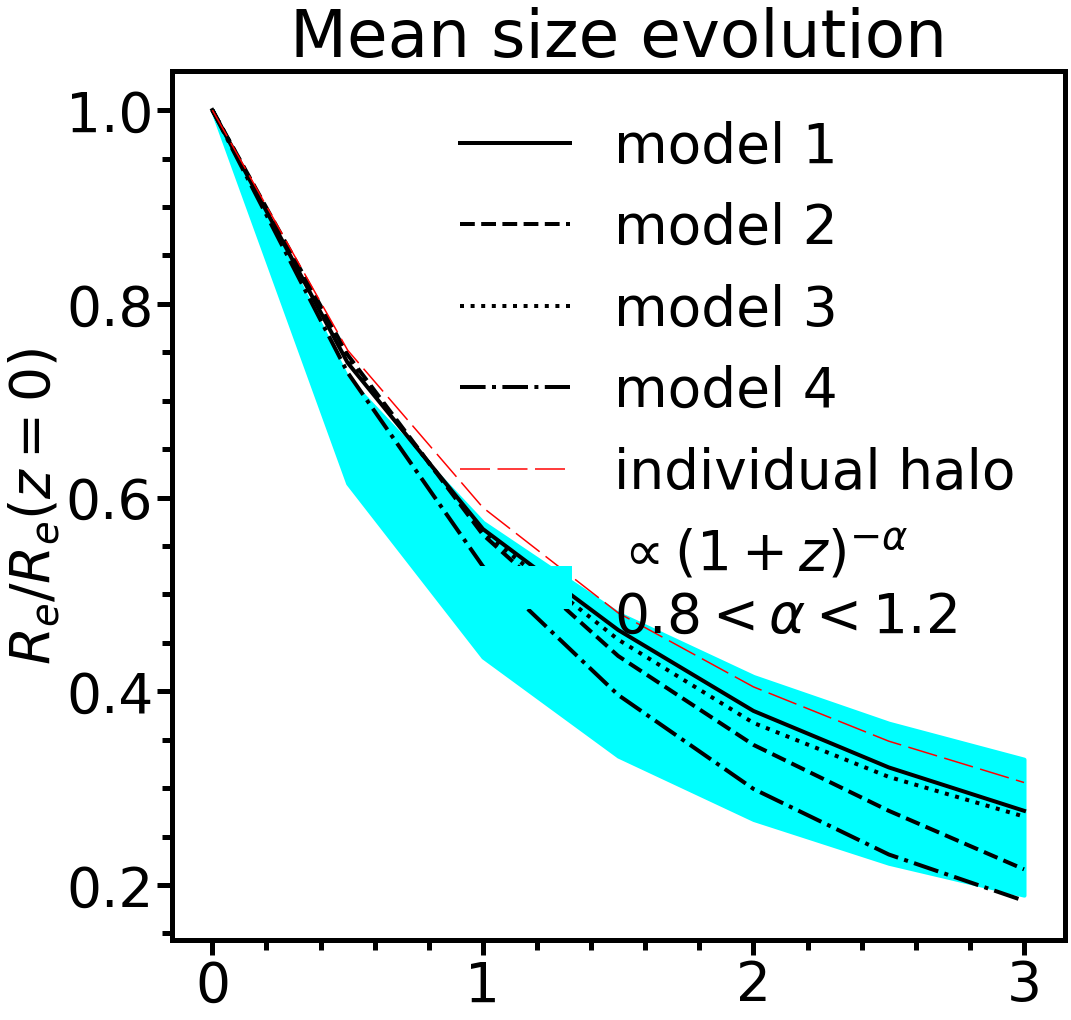

In [73]:
Vol=(250.)**3
z = 0.1
halos = utils.get_halos(z, Vol)

models = [orig,orig,new_gamma0,new_gamma0]#orig_gammaz,orig,orig_M11, orig, orig_N11]


redshifts = np.arange(0,3.5,0.5)
linestyles = ['-','--',':','-.']
colors = iter(plt.cm.Reds(np.linspace(0.2,1,len(redshifts))))
fig, ax = plt.subplots(1,1, figsize=(16,16))
x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


        
dict_0 = {}
dict_N_0 = {}

for j,(m,ls) in enumerate(zip(models,linestyles)):
    mean = []
    
    for i,z in enumerate(redshifts):
        halos = utils.get_halos(z, Vol)
        halos_ = halos[halos>11.7]
        cov = [[(0.15)**2,0.015],[0.015,(0.15)**2]]    #need cov>-sigma1*sigma2=-0.015 or cov<sigma1*sigma2=0.015 in order to be positive definite
        stars = m(halos,z,scatter=0)
        Rh = np.log10(0.018*utils.get_Rh(redshift=z, halos=halos))

        if j==0 or j==2:
            cov = [[(0.15)**2,0.015],[0.015,(0.15)**2]]    #need cov>-sigma1*sigma2=-0.015 or cov<sigma1*sigma2=0.015 in order to be positive definite
        if j==1 or j==3:
            cov = [[(0.15)**2,0.015],[0.015, (0.1*(z-0.1))**2+0.15**2]]
                   
        M = np.array([Rh,stars])
        
        def comp(x):
            return np.random.multivariate_normal(x,cov)
        with Pool() as p:
            d = p.map(comp, M.T)    
                   
        d = np.array(d)
        stars = d[:,1]
        Re = d[:,0]
        mask = np.ma.masked_inside(stars,11,12).mask
        Re = Re[mask]
                   
        mean.append(10**np.median(Re))
    mean = np.array(mean)
    ax.plot(redshifts,mean/mean[0], color='black',ls=ls,lw=4, label='model {}'.format(j+1))
    ax.set_ylabel('$R_e/R_e(z=0)$')
    ax.legend(frameon=False)
f = (1+redshifts)**-0.8
f1 = (1+redshifts)**-1.2
ax.fill_between(redshifts,f1/f1[0],f/f[0], color='cyan',label=r'$\propto(1+z)^{-\alpha}$' '\n' r'$0.8< \alpha <1.2$', lw=4)
individual_halo = mass_so.M_to_R(10**12,mdef='vir', z=redshifts)
ax.plot(redshifts, individual_halo/individual_halo[0], color='red', dashes=[20,5,20,5],label='individual halo')
ax.legend(frameon=False)
ax.set_title('Mean size evolution')
fig.savefig('cartoon_sizeevo_Cov015sigmaK015.pdf', bbox_inches='tight')

In [288]:
from scipy.stats import binned_statistic_2d
from scipy.stats import binned_statistic
from multiprocessing import Pool

In [321]:
Vol=300**3
halos = utils.get_halos(0.1,Vol)
halos = halos[halos>11.7]
z=0
smhm = grylls19()#gamma10=0.3)
stars = smhm(halos,z,scatter=0)

#mask = np.ma.masked_inside(stars,11.2,12).mask
#stars = stars[mask]
#halos = halos[mask]

Rh = np.log10(0.018*utils.get_Rh(redshift=z, halos=halos))


In [338]:
cov = [[(0.15)**2,0.015],[0.015,(0.15)**2]]    #need cov>-sigma1*sigma2=-0.015 or cov<sigma1*sigma2=0.015 in order to be positive definite

In [339]:
mean = np.array([Rh,stars])
d = []
def comp(x):
    return np.random.multivariate_normal(x,cov)
with Pool() as p:
    d = p.map(comp, mean.T)
    #d.append(np.random.multivariate_normal(M, cov))

In [340]:
d = np.array(d)
stars_new = d[:,1]
Rh_new = d[:,0]

In [341]:
stars_orig = smhm(halos,z,scatter=0.15)
Rh_orig = np.log10(utils.get_Rh(redshift=z, halos=halos))
Rh_orig = np.random.normal(Rh,scale=0.1)

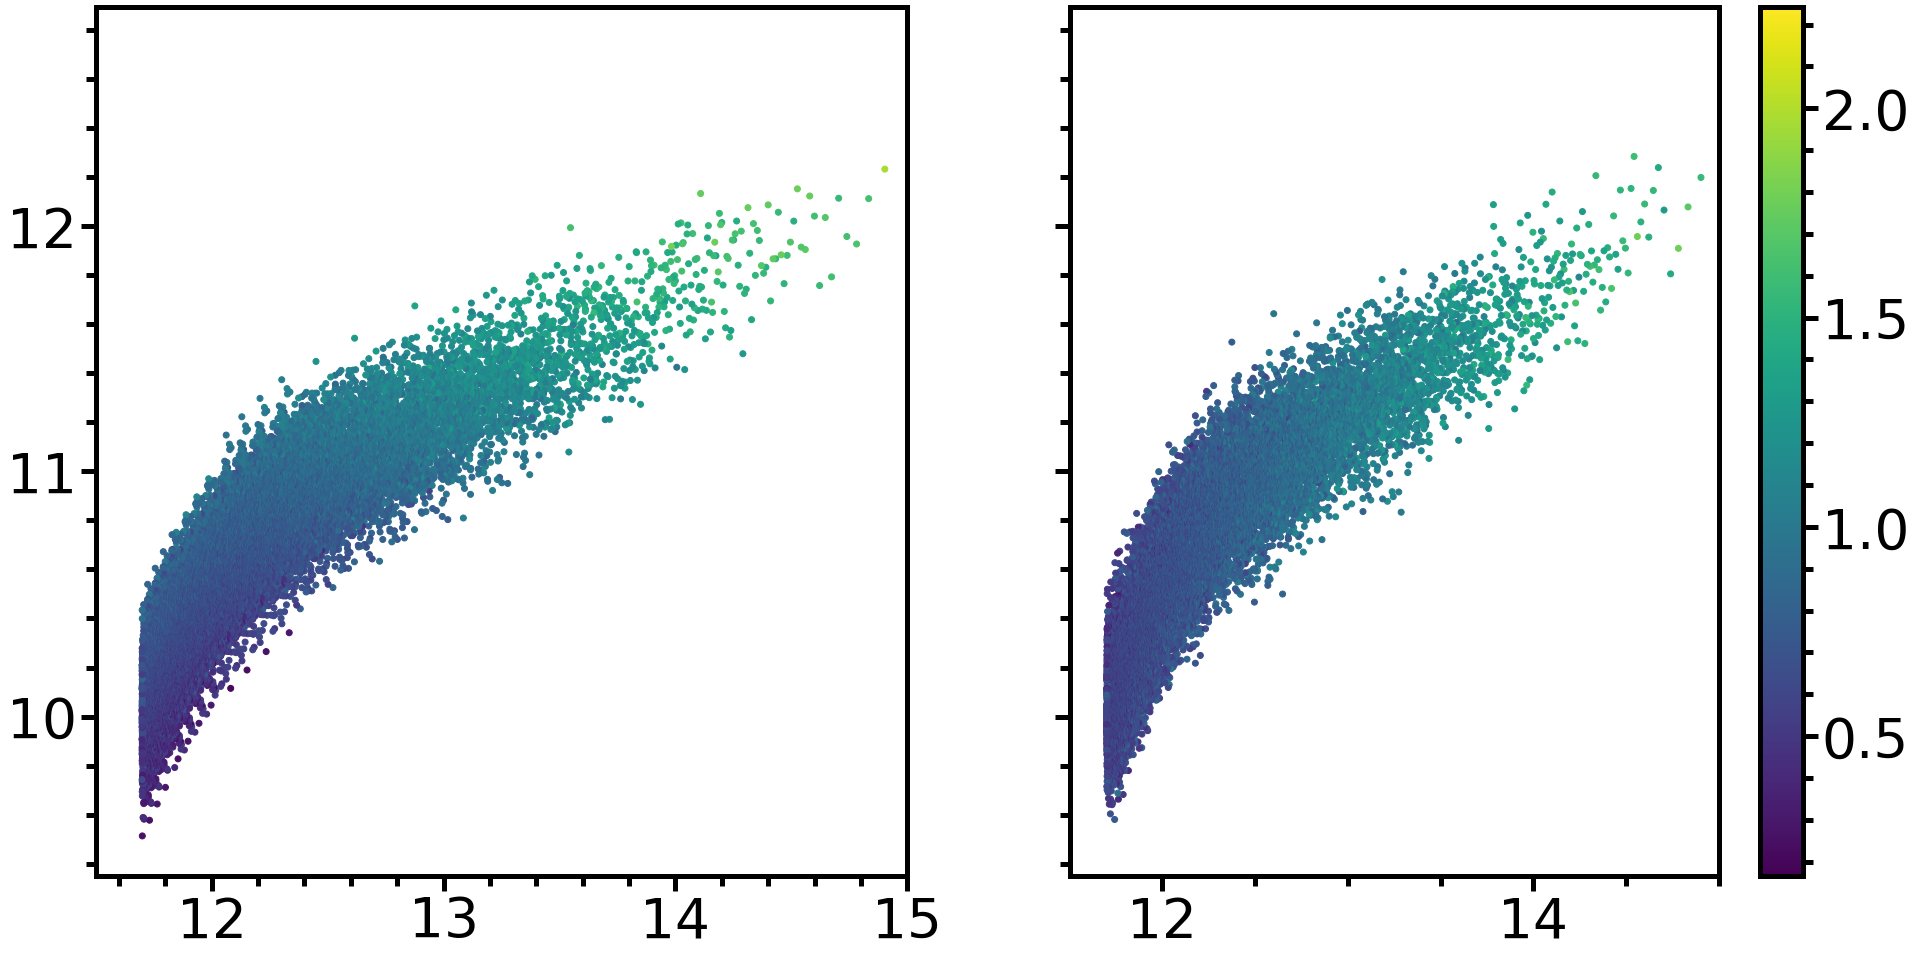

In [243]:
fig, (ax1,ax2) = plt.subplots(1,2, sharey=True, figsize=(32,16))
ax1.scatter(halos,d[:,1], c=d[:,0])#, c=Rh)
im = ax2.scatter(halos, stars_orig, c=Rh_orig)
ax1.set_xlim(11.5,15)
ax2.set_xlim(11.5,15)
fig.colorbar(im)

In [342]:
mask_new = np.ma.masked_inside(stars_new,11.2,12).mask
stars_new = stars_new[mask_new]
Rh_new = Rh_new[mask_new]
halos_new = halos[mask_new]

mask_orig = np.ma.masked_inside(stars_orig,11.2,12).mask
stars_orig = stars_orig[mask_orig]
Rh_orig = Rh_orig[mask_orig]
halos_orig = halos[mask_orig]

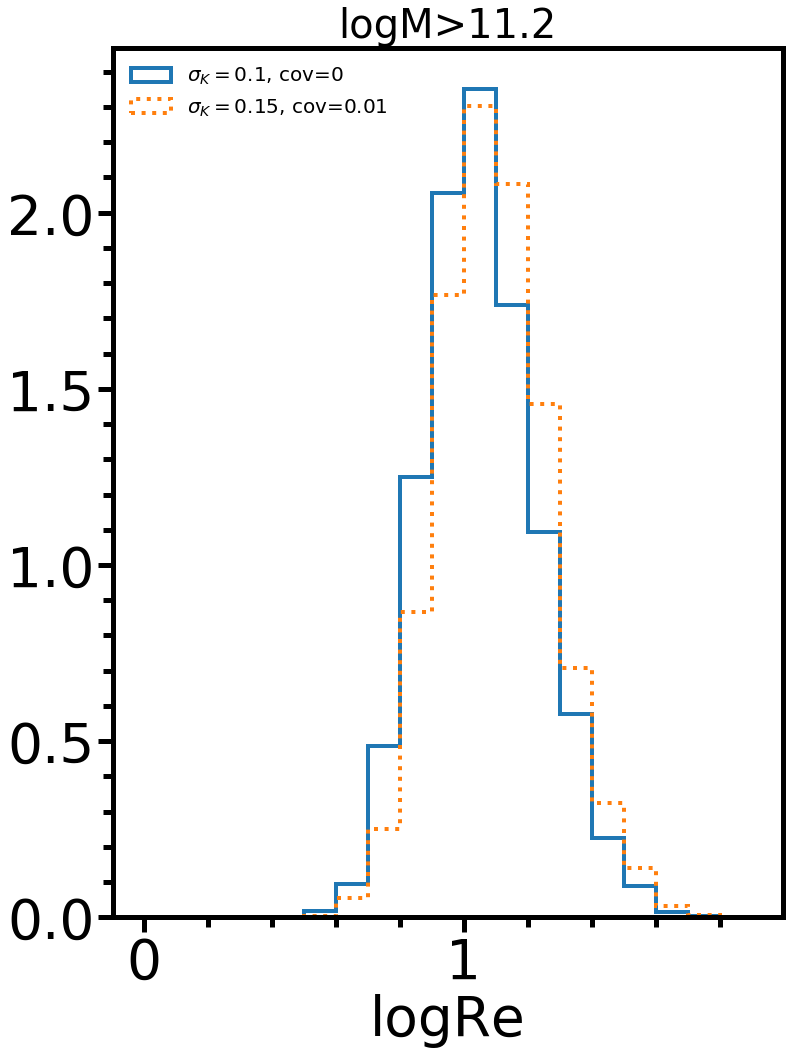

In [309]:
bins = np.arange(0,2,0.1)
plt.hist(Rh_orig,bins=bins, histtype='step',lw=4, ls='-', density=True, label='$\sigma_K=0.1$, cov=0')
plt.hist(Rh_new,bins=bins, histtype='step',lw=4, ls=':', density=True, label='$\sigma_K=0.15$, cov=0.01')
plt.title('logM>11.2', fontsize=40)
plt.legend( frameon=False, fontsize=20, loc='upper left')
plt.xlabel('logRe')
plt.savefig('./environment/correlatedscatterSizefunct.png', bbox_inches='tight')

In [343]:
M0 = 11
gamma_orig = Rh_orig+0.83*(M0-stars_orig)
gamma_new = Rh_new+0.83*(M0-stars_new)

mask = np.ma.masked_inside(halos_orig,12.5,13).mask
gamma_orig = gamma_orig/np.mean(gamma_orig[mask])

mask = np.ma.masked_inside(halos_new,12.5,13).mask
gamma_new = gamma_new/np.mean(gamma_new[mask])

In [344]:
bins=np.arange(11,15,0.1)
s_orig = binned_statistic(halos_orig,gamma_orig, statistic='mean',bins=bins)[0]
s_new = binned_statistic(halos_new,gamma_new, statistic='mean',bins=bins)[0]

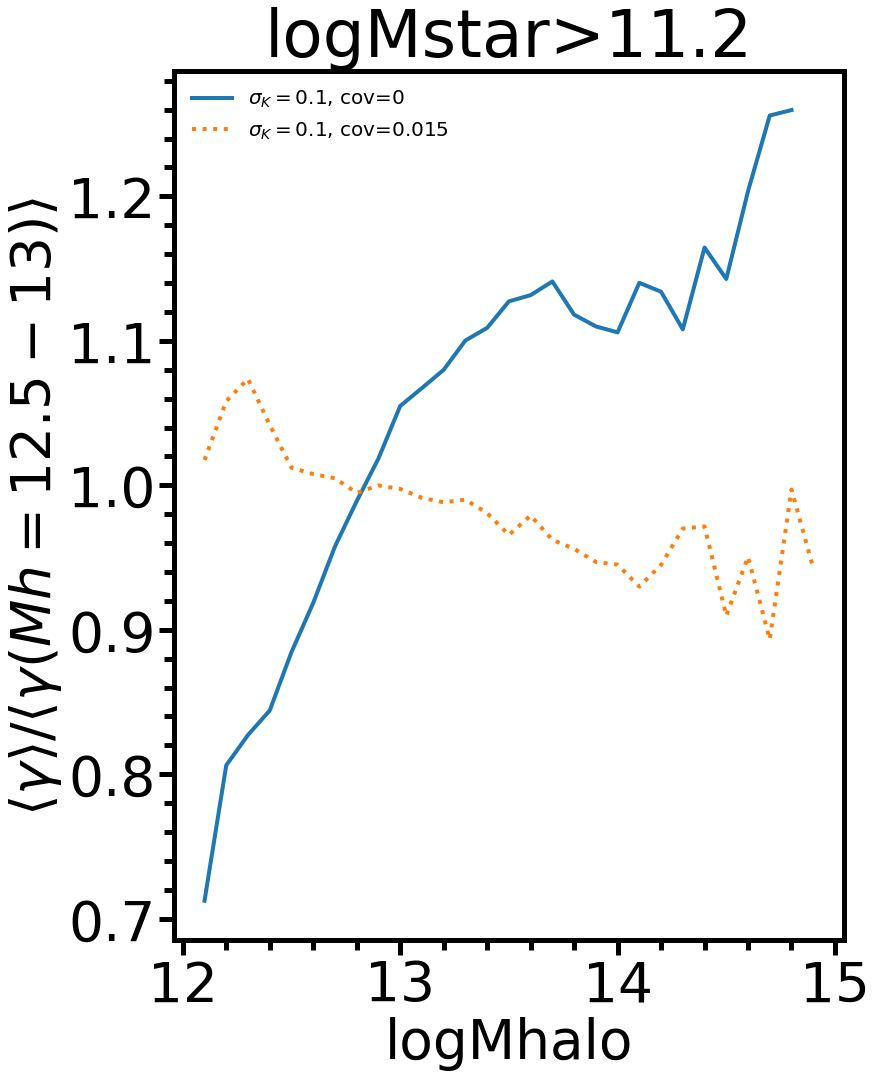

In [345]:
plt.plot(bins[1:],s_orig, lw=4, ls='-',label='$\sigma_K=0.1$, cov=0')

plt.plot(bins[1:],s_new, lw=4, ls=':', label='$\sigma_K=0.1$, cov=0.015')

plt.ylabel(r'$\langle \gamma \rangle/ \langle \gamma(Mh=12.5-13) \rangle$')
plt.xlabel('logMhalo')
plt.title('logMstar>11.2')
plt.legend(frameon=False, fontsize=20)
#plt.savefig('./environment/correlatedscatterGamma.png', bbox_inches='tight')

## test R_1

In [57]:
from scipy.stats import norm
from scipy.integrate import cumtrapz
from astropy.io import fits
from astropy.table import Table
import pandas as pd

In [6]:
Vol=500**3
halos = utils.get_halos(0.1,Vol)
halos_ = halos[halos>11.7]
z=0
smhm = grylls19()#gamma10=0.3)
stars = smhm(halos,z,scatter=0.15)
bins, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                          stars=stars, masslow=11.2,massup=12)

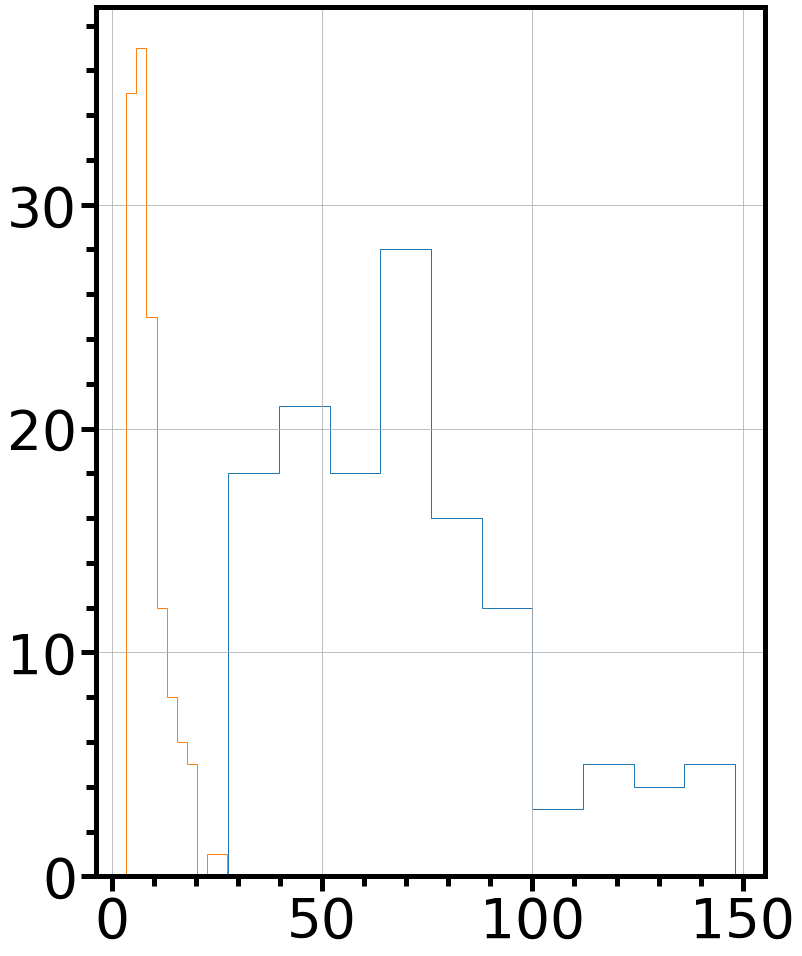

In [67]:
R1_cat = Table(fits.open('/home/lz1f17/PhD/data/galaxy_sizes_TCK2020_erratum.fits')[1].data).to_pandas()
R1_cat = R1_cat.query('LOGMASS_CORR>11.2 & TType<0')
R1_cat['R1'].hist(histtype='step')
R1_cat['Re'].hist(histtype='step')

In [73]:
np.mean(R1_cat['R1'])/np.mean(R1_cat['Re']),

(7.841575772242492,)

(0.01, 10)

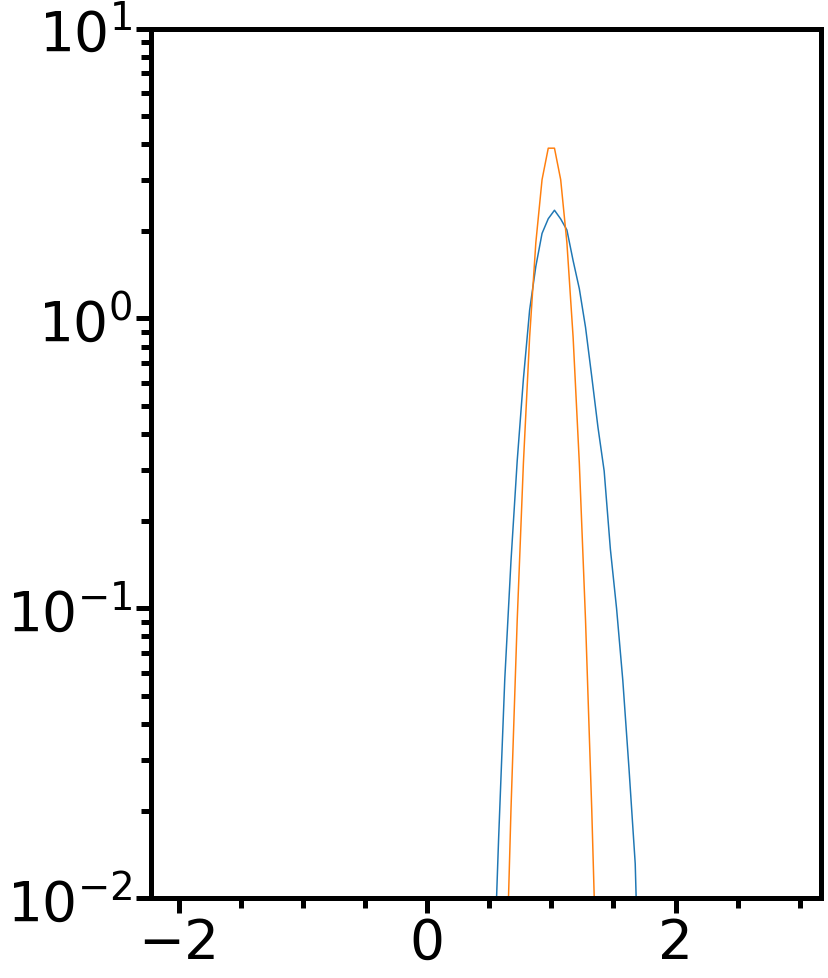

In [10]:
x = sizefunct[0]
S = cumtrapz(sizefunct[1],x)[-1]
S = sizefunct[1]/S
plt.plot(x,S)
plt.plot(x, norm.pdf(x=x,loc=1,scale=0.1), label='data')
plt.yscale('log')
plt.ylim(1.e-2,10)

In [3]:
#from Trujillo 2020
import numpy as np
beta = 0.58
s=0.094

M = np.repeat(np.arange(11.2,12,0.05),1000)
M = np.random.normal(M*beta,scale=s)

# R80

In [33]:
import pandas as pd
df = pd.read_csv('/home/lz1f17/PhD/data/SDSS/Catalog_SDSS_complete.dat', sep=' ')

In [42]:
df.query('MsMendSerExp>11.2')['logR80NotTrunc'].apply(lambda x: 10**x).mean()/ df.query('MsMendSerExp>11.2')['logReSerExp'].apply(lambda x: 10**x).mean()

4.235744762671525

In [153]:

orig = grylls19(gamma11=0, SHMnorm11=0, M11=0, gamma10=0.5)

new_gamma0 = grylls19(gamma10=0.7,gamma11=0, SHMnorm11=0, M11=0)

orig_gammaz = grylls19(SHMnorm11=0, M11=0)
new_gammaz = grylls19(gamma11=0.3, SHMnorm11=0, M11=0)

new_M10 = grylls19(M10 = 11.5, gamma11=0, SHMnorm11=0, M11=0)

orig_M11= grylls19( gamma11=0, SHMnorm11=0)
new_M11= grylls19( gamma11=0, SHMnorm11=0, M11=0.35)

new_N10 = grylls19(SHMnorm10 = 0.02, gamma11=0, SHMnorm11=0, M11=0)

orig_N11 = grylls19(gamma11=0,  M11=0)
new_N11 = grylls19(SHMnorm11 = -0.02, gamma11=0,  M11=0)


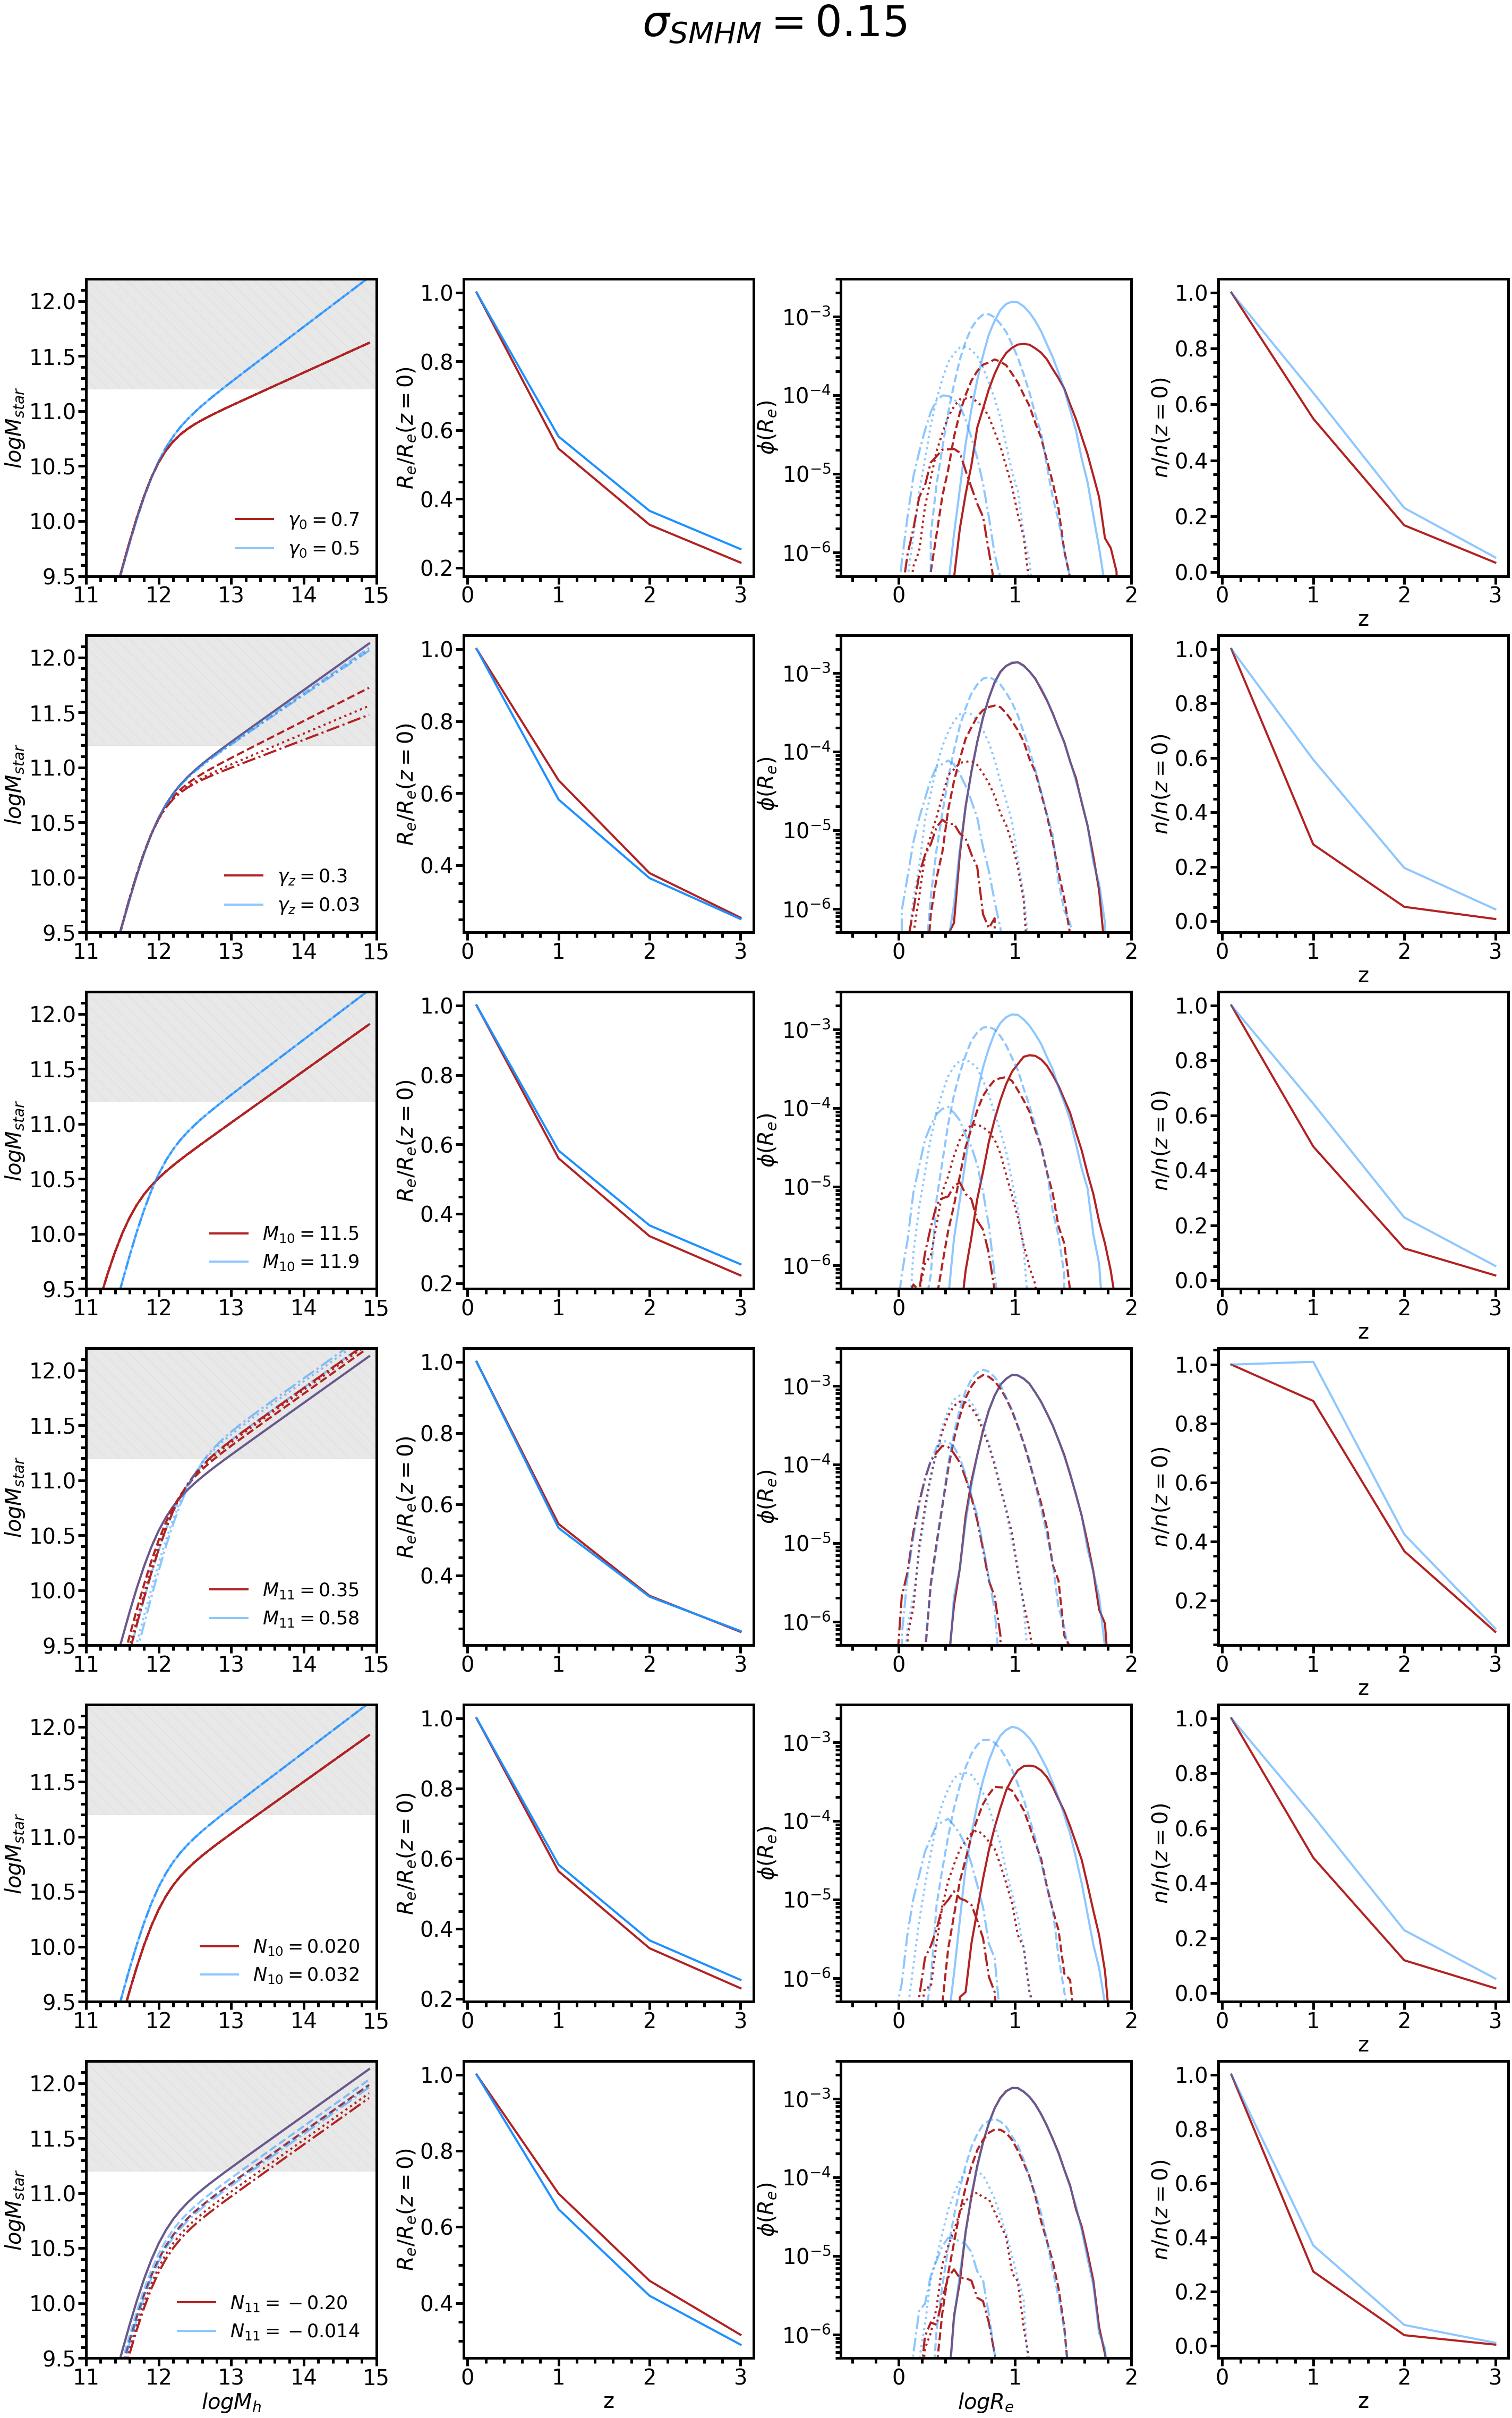

In [54]:
Vol=(750.)**3
z = 0.1
halos = utils.get_halos(z, Vol)

models_orig = [orig,orig_gammaz,orig,orig_M11, orig, orig_N11]
models_new = [new_gamma0,new_gammaz,new_M10,new_M11,new_N10,new_N11]

models_labels =['$\gamma_0=0.7$','$\gamma_z=0.3$','$M_{10} = 11.5$','$M_{11}=0.35$','$N_{10}=0.020$','$N_{11}=-0.20$']
origs_labels =['$\gamma_0=0.5$','$\gamma_z=0.03$','$M_{10} = 11.9$','$M_{11}=0.58$','$N_{10}=0.032$','$N_{11}=-0.014$']


redshifts = [0.1,1,2,3]
linestyles = ['-','--',':','-.']

fig, ax = plt.subplots(6,4, figsize=(48,72))
#@#x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


for m,(orig,a,orig_lab, mod_lab) in zip(models_new, zip(models_orig, ax.T[0].ravel(),origs_labels, models_labels)):
    
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        y_orig = orig(x,z, scatter=0)
        y = m(x,z, scatter=0)
        if i==0:
            a.plot(x,y, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a.plot(x,y_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
        else:
            a.plot(x,y, color='firebrick',ls=ls, lw=4)
            a.plot(x,y_orig, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
    a.axhspan(11.2, 12.2, alpha=0.5, color='lightgray',hatch='\\')
    a.legend(frameon=False, fontsize=35)
    a.set_xlim(11,15)
    a.set_ylim(9.5,12.2)
    a.set_ylabel('$logM_{star}$')



for m,(orig,a1,a2,a3,orig_lab,mod_lab) in zip(models_new,zip(models_orig,ax.T[1].ravel(),ax.T[2].ravel(),ax.T[3].ravel(),origs_labels,models_labels )):
    
    dict_orig = {}
    dict_new = {}
    mean = []
    mean_orig = []
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        halos = utils.get_halos(z, Vol)
        halos = halos[halos>12]
        stars = m(halos,z,scatter=0.15)
        stars_orig = orig(halos,z,scatter=0.15)
        _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        _, Re_orig, sizefunct_orig = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars_orig, masslow=11.2,massup=12)
        
        mean.append(10**np.median(Re))
        mean_orig.append(10**np.median(Re_orig))
        
        dict_orig.update({str(z):sizefunct_orig })
        dict_new.update({str(z):sizefunct })
        
        Re = sizefunct[0]
        sizefunct = sizefunct[1]
        Re_orig = sizefunct_orig[0]
        sizefunct_orig = sizefunct_orig[1]
        if i==0:
            a2.plot(Re,sizefunct, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a2.plot(Re_orig,sizefunct_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
        else:
            a2.plot(Re,sizefunct, color='firebrick',ls=ls, lw=4)
            a2.plot(Re_orig,sizefunct_orig, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
        a2.set_ylabel('$\phi(R_e)$')
      #  a.yaxis.set_label_position("right")
      #  a.yaxis.tick_right()
        a2.set_yscale('log')
        a2.set_xlim(-0.5,2)
        a2.set_ylim(5.e-7,3.e-3)
        
        
    a1.plot(redshifts,mean/mean[0], color='firebrick',lw=4)
    a1.plot(redshifts,mean_orig/mean_orig[0], color='dodgerblue',lw=4)
    a1.set_ylabel('$R_e/R_e(z=0)$')
#    dndz_orig = []
#    dndz_new = []
#    for j,key in enumerate(dict_orig.keys()):
#        if j==0:
#            store_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            store_new = np.log10(np.sum(dict_new[key][1]*0.05))
#        else:
#            app_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            app_new = np.log10(np.sum(dict_new[key][1]*0.05))
#            dndz_orig.append(app_orig-store_orig)
#            dndz_new.append(app_new-store_new)
#            store_orig = app_orig
#            store_new = app_new
    N_orig = []
    N_new = []
    for j,key in enumerate(dict_orig.keys()):
        N_orig.append(np.sum(dict_orig[key][1]*0.05))
        N_new.append(np.sum(dict_new[key][1]*0.05))
        
   # zz = [0.5,1.5,2.5]
    a3.plot(redshifts,N_new/N_new[0], color='firebrick',ls='-', lw=4)
    a3.plot(redshifts,N_orig/N_orig[0], color='dodgerblue', ls='-', lw=4,alpha=0.5)
 #   a2.yaxis.set_label_position("right")
 #   a2.yaxis.tick_right()
    a3.set_xlabel('z')#
    a3.set_ylabel('$n/n(z=0)$')
plt.subplots_adjust(wspace=0.3)            

ax[5][2].set_xlabel('$log R_e$')
ax[5][3].set_xlabel('z')
ax[5][1].set_xlabel('z')
ax[5][0].set_xlabel('$logM_h$')
fig.suptitle('$\sigma_{SMHM}=0.15$', fontsize=80)
fig.savefig('./cartoon_paper2_costsigma.pdf', bbox_inches='tight')

In [103]:
orig = grylls19(gamma11=0, SHMnorm11=0, M11=0, gamma10=0.5)

new_gamma0 = grylls19(gamma10=0.7,gamma11=0, SHMnorm11=0, M11=0)

orig_gammaz = grylls19(SHMnorm11=0, M11=0)
new_gammaz = grylls19(gamma11=0.3, SHMnorm11=0, M11=0)

new_M10 = grylls19(M10 = 11.5, gamma11=0, SHMnorm11=0, M11=0)

orig_M11= grylls19( gamma11=0, SHMnorm11=0)
new_M11= grylls19( gamma11=0, SHMnorm11=0, M11=0.35)

new_N10 = grylls19(SHMnorm10 = 0.02, gamma11=0, SHMnorm11=0, M11=0)

orig_N11 = grylls19(gamma11=0,  M11=0)
new_N11 = grylls19(SHMnorm11 = -0.02, gamma11=0,  M11=0)


0.15033296378372907
0.18027756377319948
0.25
0.33541019662496846
0.15033296378372907
0.18027756377319948
0.25
0.33541019662496846
0.15033296378372907
0.18027756377319948
0.25
0.33541019662496846
0.15033296378372907
0.18027756377319948
0.25
0.33541019662496846
0.15033296378372907
0.18027756377319948
0.25
0.33541019662496846
0.15033296378372907
0.18027756377319948
0.25
0.33541019662496846


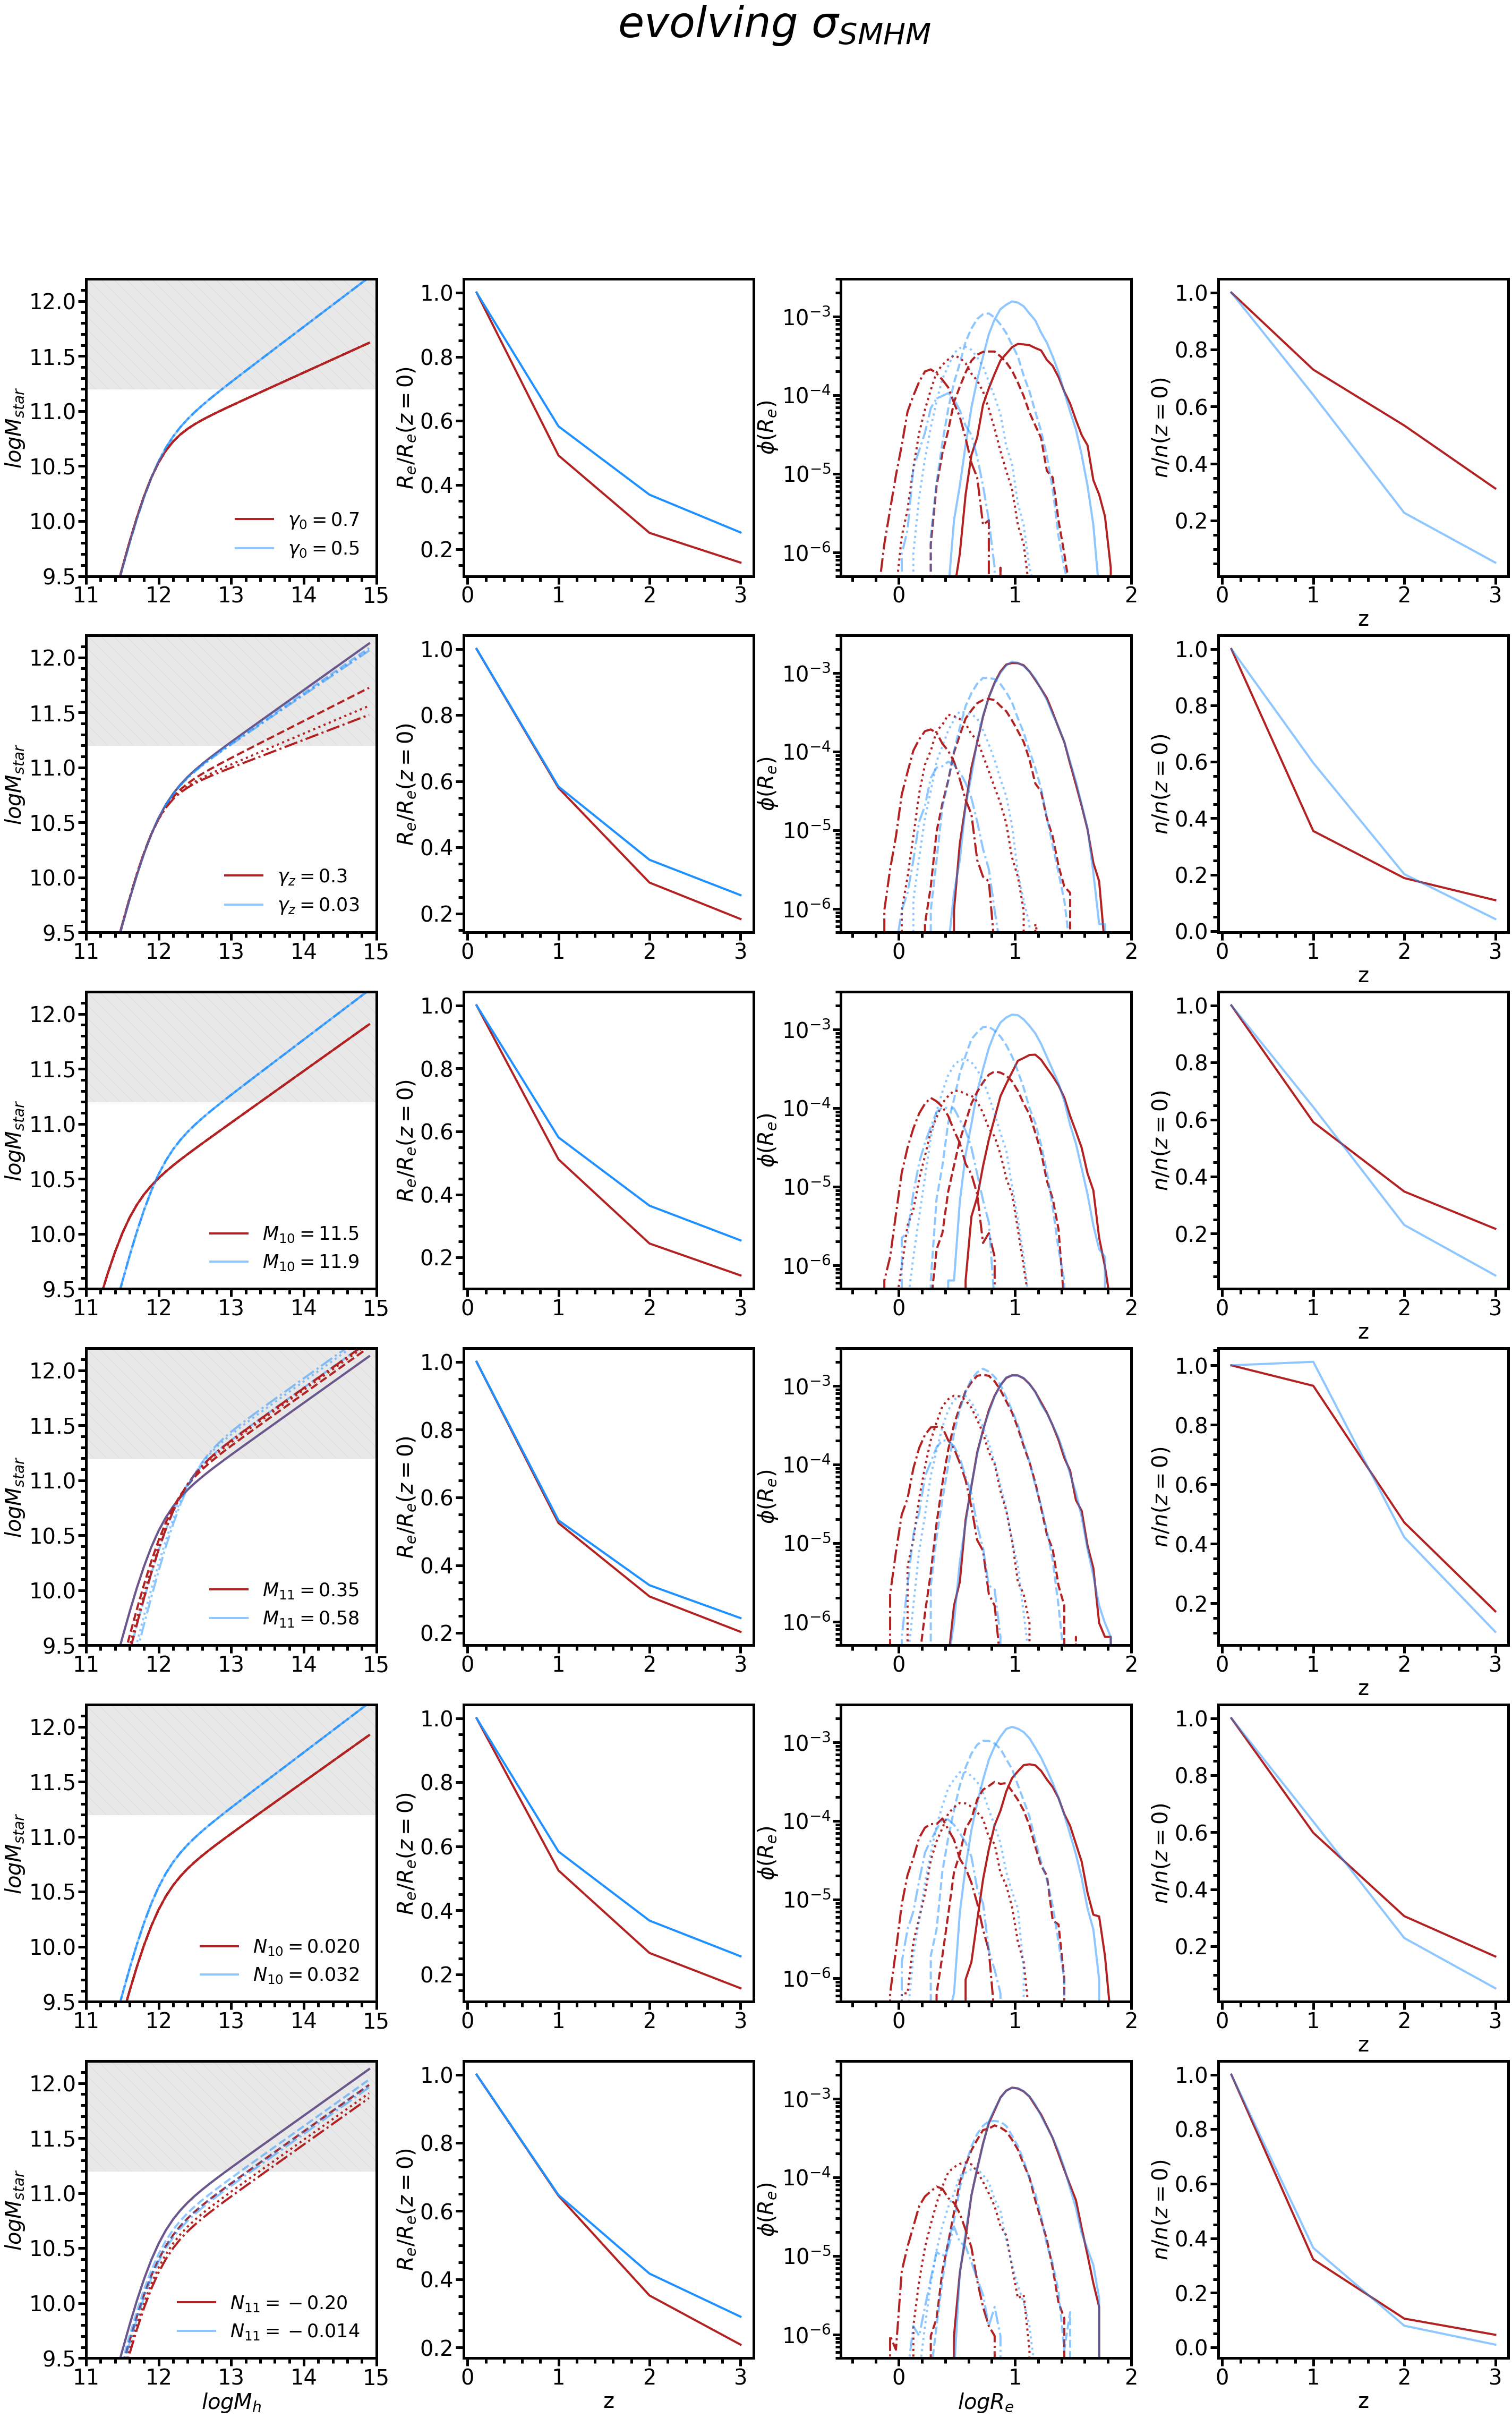

In [104]:
Vol=(500.)**3


models_orig = [orig,orig_gammaz,orig,orig_M11, orig, orig_N11]
models_new = [new_gamma0,new_gammaz,new_M10,new_M11,new_N10,new_N11]

models_labels =['$\gamma_0=0.7$','$\gamma_z=0.3$','$M_{10} = 11.5$','$M_{11}=0.35$','$N_{10}=0.020$','$N_{11}=-0.20$']
origs_labels =['$\gamma_0=0.5$','$\gamma_z=0.03$','$M_{10} = 11.9$','$M_{11}=0.58$','$N_{10}=0.032$','$N_{11}=-0.014$']


redshifts = [0.1,1.,2.,3.]
linestyles = ['-','--',':','-.']

fig, ax = plt.subplots(6,4, figsize=(48,72))
x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


for m,(orig,a,orig_lab, mod_lab) in zip(models_new, zip(models_orig, ax.T[0].ravel(),origs_labels, models_labels)):
    
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        y_orig = orig(x,z, scatter=0, scatterevol=False)
        y = m(x,z, scatter=0, scatterevol=False)
        if i==0:
            a.plot(x,y, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a.plot(x,y_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
        else:
            a.plot(x,y, color='firebrick',ls=ls, lw=4)
            a.plot(x,y_orig, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
    
    a.axhspan(11.2, 12.2, alpha=0.5, color='lightgray',hatch='\\')
    a.legend(frameon=False, fontsize=35)
    a.set_xlim(11,15)
    a.set_ylim(9.5,12.2)
    a.set_ylabel('$logM_{star}$')



for m,(orig,a1,a2,a3,orig_lab,mod_lab) in zip(models_new,zip(models_orig,ax.T[1].ravel(),ax.T[2].ravel(),ax.T[3].ravel(),origs_labels,models_labels )):
    
    dict_orig = {}
    dict_new = {}
    mean = []
    mean_orig = []
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        halos = utils.get_halos(z, Vol)
        halos = halos[halos>12]
        stars = m(halos,z=z,scatter=0.15, scatterevol=True)
        stars_orig = orig(halos,z=z,scatter=0.15)
        _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)
        _, Re_orig, sizefunct_orig = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars_orig, masslow=11.2,massup=12)
        
        mean.append(10**np.median(Re))
        mean_orig.append(10**np.median(Re_orig))
        
        dict_orig.update({str(z):sizefunct_orig })
        dict_new.update({str(z):sizefunct })
        
        Re = sizefunct[0]
        sizefunct = sizefunct[1]
        Re_orig = sizefunct_orig[0]
        sizefunct_orig = sizefunct_orig[1]
        if i==0:
            a2.plot(Re,sizefunct, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a2.plot(Re_orig,sizefunct_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
        else:
            a2.plot(Re,sizefunct, color='firebrick',ls=ls, lw=4)
            a2.plot(Re_orig,sizefunct_orig, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
        a2.set_ylabel('$\phi(R_e)$')
      #  a.yaxis.set_label_position("right")
      #  a.yaxis.tick_right()
        a2.set_yscale('log')
        a2.set_xlim(-0.5,2)
        a2.set_ylim(5.e-7,3.e-3)
        
        
    a1.plot(redshifts,mean/mean[0], color='firebrick',lw=4)
    a1.plot(redshifts,mean_orig/mean_orig[0], color='dodgerblue',lw=4)
    a1.set_ylabel('$R_e/R_e(z=0)$')
#    dndz_orig = []
#    dndz_new = []
#    for j,key in enumerate(dict_orig.keys()):
#        if j==0:
#            store_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            store_new = np.log10(np.sum(dict_new[key][1]*0.05))
#        else:
#            app_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            app_new = np.log10(np.sum(dict_new[key][1]*0.05))
#            dndz_orig.append(app_orig-store_orig)
#            dndz_new.append(app_new-store_new)
#            store_orig = app_orig
#            store_new = app_new
    N_orig = []
    N_new = []
    for j,key in enumerate(dict_orig.keys()):
        N_orig.append(np.sum(dict_orig[key][1]*0.05))
        N_new.append(np.sum(dict_new[key][1]*0.05))
        
   # zz = [0.5,1.5,2.5]
    a3.plot(redshifts,N_new/N_new[0], color='firebrick',ls='-', lw=4)
    a3.plot(redshifts,N_orig/N_orig[0], color='dodgerblue', ls='-', lw=4,alpha=0.5)
 #   a2.yaxis.set_label_position("right")
 #   a2.yaxis.tick_right()
    a3.set_xlabel('z')#
    a3.set_ylabel('$n/n(z=0)$')
plt.subplots_adjust(wspace=0.3)            

ax[5][2].set_xlabel('$log R_e$')
ax[5][3].set_xlabel('z')
ax[5][1].set_xlabel('z')
ax[5][0].set_xlabel('$logM_h$')
fig.suptitle('$evolving \ \sigma_{SMHM}$', fontsize=80)
fig.savefig('./cartoon_paper2_evolvingsigma.pdf', bbox_inches='tight')

# cartoons for body of the paper

In [16]:
orig = grylls19(gamma11=0, SHMnorm11=0, M11=0, gamma10=0.5)

new_gamma0 = grylls19(gamma10=0.7,gamma11=0, SHMnorm11=0, M11=0)

orig_gammaz = grylls19(SHMnorm11=0, M11=0)
new_gammaz = grylls19(gamma11=0.1, SHMnorm11=0, M11=0)



0.15033296378372907
0.15033296378372907
0.18027756377319948
0.18027756377319948
0.25
0.25
0.33541019662496846
0.33541019662496846
[0.90909091 0.5        0.33333333 0.25      ]
[0.90909091 0.5        0.33333333 0.25      ]


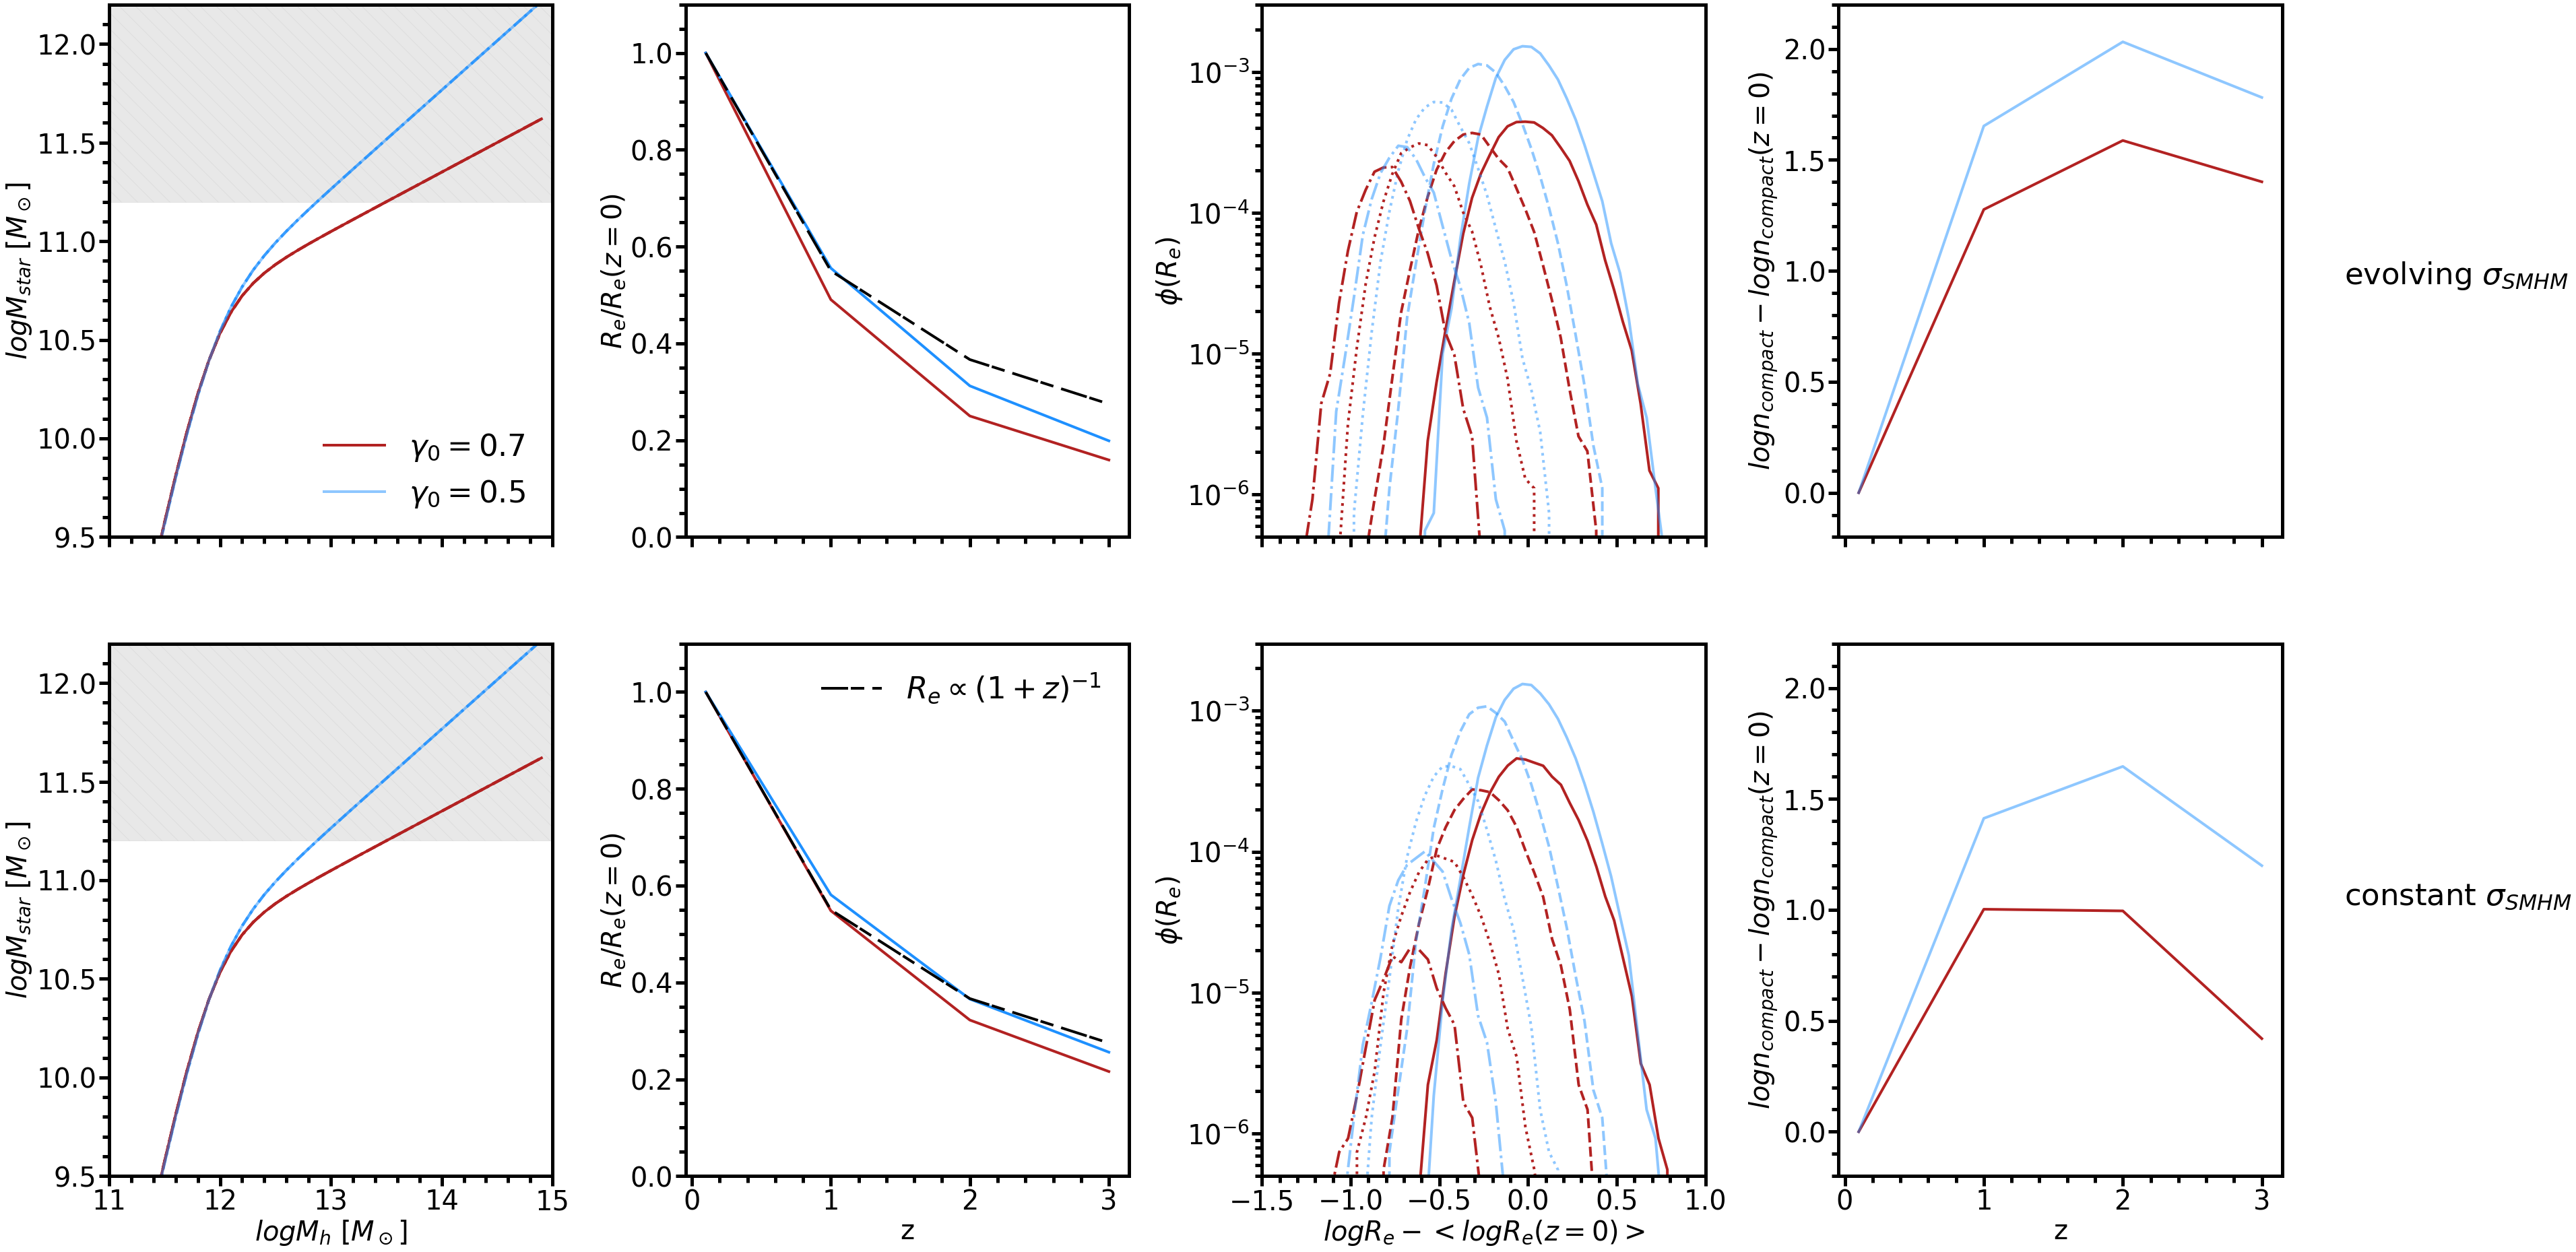

In [17]:
Vol=(600.)**3


models_scatt = [orig,orig]#,orig,orig_M11, orig, orig_N11]
models_noscatt = [new_gamma0,new_gamma0]#,new_M10,new_M11,new_N10,new_N11]

models_labels_noscatt =['$\gamma_0=0.5$','$\gamma_0=0.7$']#,'$M_{10} = 11.5$','$M_{11}=0.35$','$N_{10}=0.020$','$N_{11}=-0.20$']
models_labels_scatt =['$\gamma_0=0.7 $','$\gamma_0=0.5$']#,'$M_{10} = 11.9$','$M_{11}=0.58$','$N_{10}=0.032$','$N_{11}=-0.014$']


redshifts = np.array([0.1,1.,2.,3.])
linestyles = ['-','--',':','-.']

fig, ax = plt.subplots(2,4, figsize=(64,32))
x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


for m,(orig,a,orig_lab, mod_lab) in zip(models_noscatt, zip(models_scatt, ax.T[0].ravel(),models_labels_noscatt, models_labels_scatt)):
    
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        y_orig = orig(x,z, scatter=0, scatterevol=False)
        y = m(x,z, scatter=0, scatterevol=False)
        if i==0:
            a.plot(x,y, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a.plot(x,y_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
        else:
            a.plot(x,y, color='firebrick',ls=ls, lw=4)
            a.plot(x,y_orig, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
    
    a.axhspan(11.2, 12.2, alpha=0.5, color='lightgray',hatch='\\')
  #  a.legend(frameon=False, fontsize=35)
    a.set_xlim(11,15)
    a.set_ylim(9.5,12.2)
    a.set_ylabel('$logM_{star} \ [M_\odot]$')


    
    

for m,(orig,a1,a2,a3,orig_lab,mod_lab,evol) in zip(models_noscatt,zip(models_scatt,ax.T[1].ravel(),ax.T[2].ravel(),ax.T[3].ravel(),models_labels_scatt,models_labels_noscatt,[True,False] )):
    
    dict_orig = {}
    dict_new = {}
    mean = []
    mean_orig = []
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        halos = utils.get_halos(z, Vol)
        halos = halos[halos>12]
        stars = m(halos,z=z,scatter=0.15, scatterevol=evol)
        stars_orig = orig(halos,z=z,scatter=0.15,scatterevol=evol)
        _, Re_orig, sizefunct_orig = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars_orig, masslow=11.2,massup=12)
        _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)

        
        if i==0:
            orig_norm = np.median(Re_orig)
            orig_var = np.std(Re_orig)
            new_norm = np.median(Re)
            orig_var = np.std(Re)

            
        mean.append(10**np.median(Re))
        mean_orig.append(10**np.median(Re_orig))
        
        sizefunct_orig[0] -= orig_norm
        sizefunct[0] -= new_norm
        dict_orig.update({str(z):sizefunct_orig })
        dict_new.update({str(z):sizefunct })
        
        Re = sizefunct[0]
        sizefunct = sizefunct[1]
        Re_orig = sizefunct_orig[0]
        sizefunct_orig = sizefunct_orig[1]
        if i==0:
            a2.plot(Re,sizefunct, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a2.plot(Re_orig,sizefunct_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
            
            
        else:
            a2.plot(Re,sizefunct, color='firebrick',ls=ls, lw=4)
            a2.plot(Re_orig,sizefunct_orig, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
        a2.set_ylabel('$\phi(R_e)$')
      #  a.yaxis.set_label_position("right")
      #  a.yaxis.tick_right()
        a2.set_yscale('log')
        a2.set_xlim(-1.5,1)
        a2.set_ylim(5.e-7,3.e-3)
        
        
    a1.plot(redshifts,mean/mean[0], color='firebrick',lw=4)
    a1.plot(redshifts,mean_orig/mean_orig[0], color='dodgerblue',lw=4)
    y = (1+redshifts)**-1
    print(y)
    a1.plot(redshifts,y/y[0] , lw=4, color='black', dashes=[10,1,5,3], label=r'$R_e\propto(1+z)^{-1}$')
    
    a1.set_ylabel('$R_e/R_e(z=0)$')
    a1.set_ylim(0,1.1)
#    dndz_orig = []
#    dndz_new = []
#    for j,key in enumerate(dict_orig.keys()):
#        if j==0:
#            store_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            store_new = np.log10(np.sum(dict_new[key][1]*0.05))
#        else:
#            app_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            app_new = np.log10(np.sum(dict_new[key][1]*0.05))
#            dndz_orig.append(app_orig-store_orig)
#            dndz_new.append(app_new-store_new)
#            store_orig = app_orig
#            store_new = app_new
    N_orig = []
    N_new = []
    for j,key in enumerate(dict_orig.keys()):
        n = dict_orig[key][1]
        R = dict_orig[key][0]
        mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
        ncompact = n[mask]
        N_orig.append(np.sum(ncompact*0.05))
        
        n = dict_new[key][1]
        R = dict_new[key][0]
        mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
        ncompact = n[mask]        
        N_new.append(np.sum(ncompact*0.05))
        
   # zz = [0.5,1.5,2.5]
    a3.plot(redshifts,np.log10(N_new/N_new[0] ),color='firebrick',ls='-', lw=4)
    a3.plot(redshifts,np.log10(N_orig/N_orig[0]), color='dodgerblue', ls='-', lw=4,alpha=0.5)
 #   a2.yaxis.set_label_position("right")
 #   a2.yaxis.tick_right()
    a3.set_ylabel('$logn_{compact}-logn_{compact}(z=0)$')
    a3.set_ylim(-0.2,2.2)
plt.subplots_adjust(wspace=0.3,right=0.8,left=0.1)
fig.text(0.82,0.7, 'evolving $\sigma_{SMHM}$', fontsize=45)
fig.text(0.82,0.3, 'constant $\sigma_{SMHM}$', fontsize=45)
ax[1][2].set_xlabel('$log R_e- <log R_e(z=0)>$')
ax[1][3].set_xlabel('z')
ax[1][1].set_xlabel('z')
ax[1][0].set_xlabel('$logM_h \ [M_\odot]$')
ax[1][1].legend(frameon=False, fontsize=45)
ax[0][0].legend(frameon=False, fontsize=45)

for a in ax[0].ravel():
    a.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
  #  bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
#fig.suptitle('$evolving \ \sigma_{SMHM}$', fontsize=80)
fig.savefig('./cartoon_paper2_gamma0.pdf', bbox_inches='tight')

# same as above but with fquench

In [12]:
def fred(x,z):
    def betaz(z):
        return 0.68+(1+z)**2
    beta = betaz(z)
    return 1./(1+beta*1.e12/10**x)

orig = grylls19(gamma11=0, SHMnorm11=0, M11=0, gamma10=0.5)

new_gamma0 = grylls19(gamma10=0.7,gamma11=0, SHMnorm11=0, M11=0)

orig_gammaz = grylls19(SHMnorm11=0, M11=0)
new_gammaz = grylls19(gamma11=0.1, SHMnorm11=0, M11=0)


0.15033296378372907
0.15033296378372907
0.18027756377319948
0.18027756377319948
0.25
0.25
0.33541019662496846
0.33541019662496846
[0.90909091 0.5        0.33333333 0.25      ]
[0.90909091 0.5        0.33333333 0.25      ]


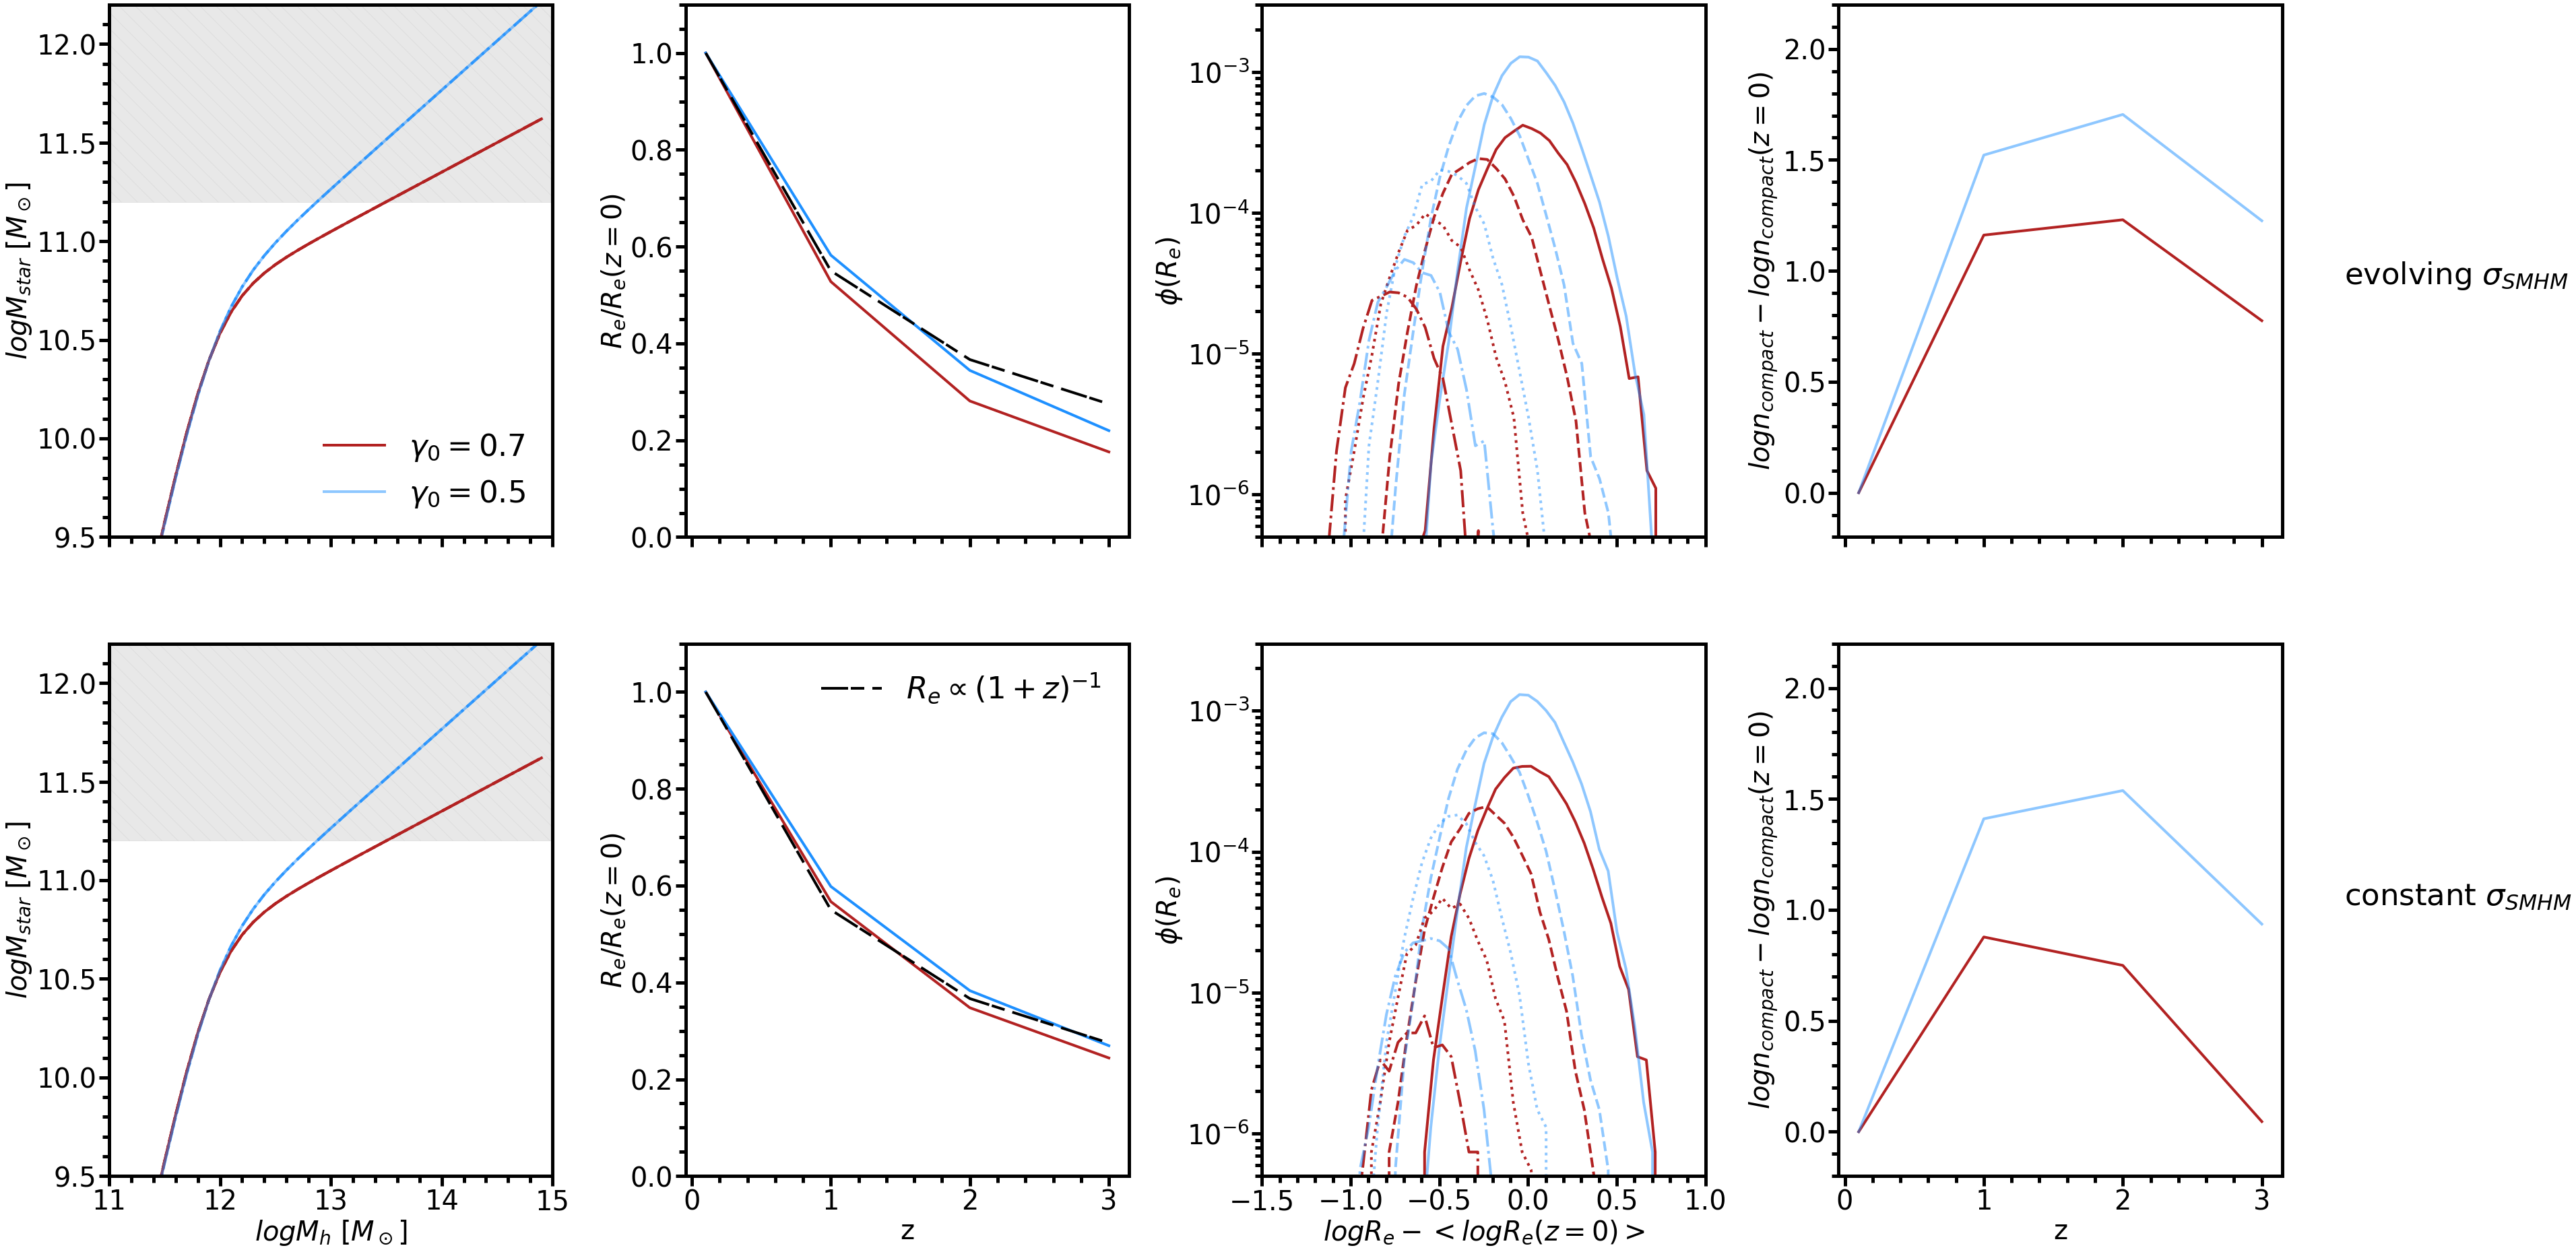

In [15]:
Vol=(600.)**3


models_scatt = [orig,orig]#,orig,orig_M11, orig, orig_N11]
models_noscatt = [new_gamma0,new_gamma0]#,new_M10,new_M11,new_N10,new_N11]

models_labels_noscatt =['$\gamma_0=0.5$','$\gamma_0=0.7$']#,'$M_{10} = 11.5$','$M_{11}=0.35$','$N_{10}=0.020$','$N_{11}=-0.20$']
models_labels_scatt =['$\gamma_0=0.7 $','$\gamma_0=0.5$']#,'$M_{10} = 11.9$','$M_{11}=0.58$','$N_{10}=0.032$','$N_{11}=-0.014$']


redshifts = np.array([0.1,1.,2.,3.])
linestyles = ['-','--',':','-.']

fig, ax = plt.subplots(2,4, figsize=(64,32))
x = np.arange(11,15,0.1)
#f#or z, ls in zip(redshifts, linestyles):
 #   ax[1][1].plot(1000*x,1000*x, ls=ls, label='z={}'.format(z), color='black',lw=4)
#a#x[0][1].legend(frameon=False, fontsize=35)


for m,(orig,a,orig_lab, mod_lab) in zip(models_noscatt, zip(models_scatt, ax.T[0].ravel(),models_labels_noscatt, models_labels_scatt)):
    
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        y_orig = orig(x,z, scatter=0, scatterevol=False)
        y = m(x,z, scatter=0, scatterevol=False)
        if i==0:
            a.plot(x,y, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a.plot(x,y_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
        else:
            a.plot(x,y, color='firebrick',ls=ls, lw=4)
            a.plot(x,y_orig, color='dodgerblue', ls=ls, lw=4, alpha=0.5)
    
    a.axhspan(11.2, 12.2, alpha=0.5, color='lightgray',hatch='\\')
  #  a.legend(frameon=False, fontsize=35)
    a.set_xlim(11,15)
    a.set_ylim(9.5,12.2)
    a.set_ylabel('$logM_{star} \ [M_\odot]$')


    
    

for m,(orig,a1,a2,a3,orig_lab,mod_lab,evol) in zip(models_noscatt,zip(models_scatt,ax.T[1].ravel(),ax.T[2].ravel(),ax.T[3].ravel(),models_labels_scatt,models_labels_noscatt,[True,False] )):
    
    dict_orig = {}
    dict_new = {}
    mean = []
    mean_orig = []
    for i,(z,ls) in enumerate(zip(redshifts,linestyles)):
        halos = utils.get_halos(z, Vol)
        halos = halos[halos>12]
        
        # add fquench
        halodf = pd.DataFrame({'halos':halos})
        bl = halodf.apply(lambda x: np.random.uniform(size=len(halos)) >  fred(x,z)).values.T[0] 
        red = np.logical_not(bl)
        halos = halos[red]
        stars = m(halos,z=z,scatter=0.15, scatterevol=evol)
        stars_orig = orig(halos,z=z,scatter=0.15,scatterevol=evol)
        _, Re_orig, sizefunct_orig = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars_orig, masslow=11.2,massup=12)
        _, Re, sizefunct = utils.get_sizefunction(halos, z, Vol,A_K=0.018, sigma_K=0.1,\
                                                  stars=stars, masslow=11.2,massup=12)

        
        if i==0:
            orig_norm = np.median(Re_orig)
            orig_var = np.std(Re_orig)
            new_norm = np.median(Re)
            orig_var = np.std(Re)

            
        mean.append(10**np.median(Re))
        mean_orig.append(10**np.median(Re_orig))
        
        sizefunct_orig[0] -= orig_norm
        sizefunct[0] -= new_norm
        dict_orig.update({str(z):sizefunct_orig })
        dict_new.update({str(z):sizefunct })
        
        Re = sizefunct[0]
        sizefunct = sizefunct[1]
        Re_orig = sizefunct_orig[0]
        sizefunct_orig = sizefunct_orig[1]
        if i==0:
            a2.plot(Re,sizefunct, label=mod_lab, color='firebrick', ls=ls,lw=4)
            a2.plot(Re_orig,sizefunct_orig, label=orig_lab, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
            
            
        else:
            a2.plot(Re,sizefunct, color='firebrick',ls=ls, lw=4)
            a2.plot(Re_orig,sizefunct_orig, color='dodgerblue', ls=ls, lw=4,alpha=0.5)
        a2.set_ylabel('$\phi(R_e)$')
      #  a.yaxis.set_label_position("right")
      #  a.yaxis.tick_right()
        a2.set_yscale('log')
        a2.set_xlim(-1.5,1)
        a2.set_ylim(5.e-7,3.e-3)
        
        
    a1.plot(redshifts,mean/mean[0], color='firebrick',lw=4)
    a1.plot(redshifts,mean_orig/mean_orig[0], color='dodgerblue',lw=4)
    y = (1+redshifts)**-1
    print(y)
    a1.plot(redshifts,y/y[0] , lw=4, color='black', dashes=[10,1,5,3], label=r'$R_e\propto(1+z)^{-1}$')
    
    a1.set_ylabel('$R_e/R_e(z=0)$')
    a1.set_ylim(0,1.1)
#    dndz_orig = []
#    dndz_new = []
#    for j,key in enumerate(dict_orig.keys()):
#        if j==0:
#            store_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            store_new = np.log10(np.sum(dict_new[key][1]*0.05))
#        else:
#            app_orig = np.log10(np.sum(dict_orig[key][1]*0.05))
#            app_new = np.log10(np.sum(dict_new[key][1]*0.05))
#            dndz_orig.append(app_orig-store_orig)
#            dndz_new.append(app_new-store_new)
#            store_orig = app_orig
#            store_new = app_new
    N_orig = []
    N_new = []
    for j,key in enumerate(dict_orig.keys()):
        n = dict_orig[key][1]
        R = dict_orig[key][0]
        mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
        ncompact = n[mask]
        N_orig.append(np.sum(ncompact*0.05))
        
        n = dict_new[key][1]
        R = dict_new[key][0]
        mask = np.ma.masked_less(R,-0.4).mask #select only ultra-compact objects as in Cassata+11, 0.4 dex below local relation. NB. R has been normalized to local above
        ncompact = n[mask]        
        N_new.append(np.sum(ncompact*0.05))
        
   # zz = [0.5,1.5,2.5]
    a3.plot(redshifts,np.log10(N_new/N_new[0] ),color='firebrick',ls='-', lw=4)
    a3.plot(redshifts,np.log10(N_orig/N_orig[0]), color='dodgerblue', ls='-', lw=4,alpha=0.5)
 #   a2.yaxis.set_label_position("right")
 #   a2.yaxis.tick_right()
    a3.set_ylabel('$logn_{compact}-logn_{compact}(z=0)$')
    a3.set_ylim(-0.2,2.2)
plt.subplots_adjust(wspace=0.3,right=0.8,left=0.1)
fig.text(0.82,0.7, 'evolving $\sigma_{SMHM}$', fontsize=45)
fig.text(0.82,0.3, 'constant $\sigma_{SMHM}$', fontsize=45)
ax[1][2].set_xlabel('$log R_e- <log R_e(z=0)>$')
ax[1][3].set_xlabel('z')
ax[1][1].set_xlabel('z')
ax[1][0].set_xlabel('$logM_h \ [M_\odot]$')
ax[1][1].legend(frameon=False, fontsize=45)
ax[0][0].legend(frameon=False, fontsize=45)

for a in ax[0].ravel():
    a.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
  #  bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
#fig.suptitle('$evolving \ \sigma_{SMHM}$', fontsize=80)
fig.savefig('./cartoon_paper2_gamma0_fquench_mu2.pdf', bbox_inches='tight')

In [73]:
def R80(r,n):
    return r*(0.0012*n**3 - 0.0123*n**2+ 0.5092*n+ 1.2646)

Text(0, 0.5, 'R/R(z=0)')

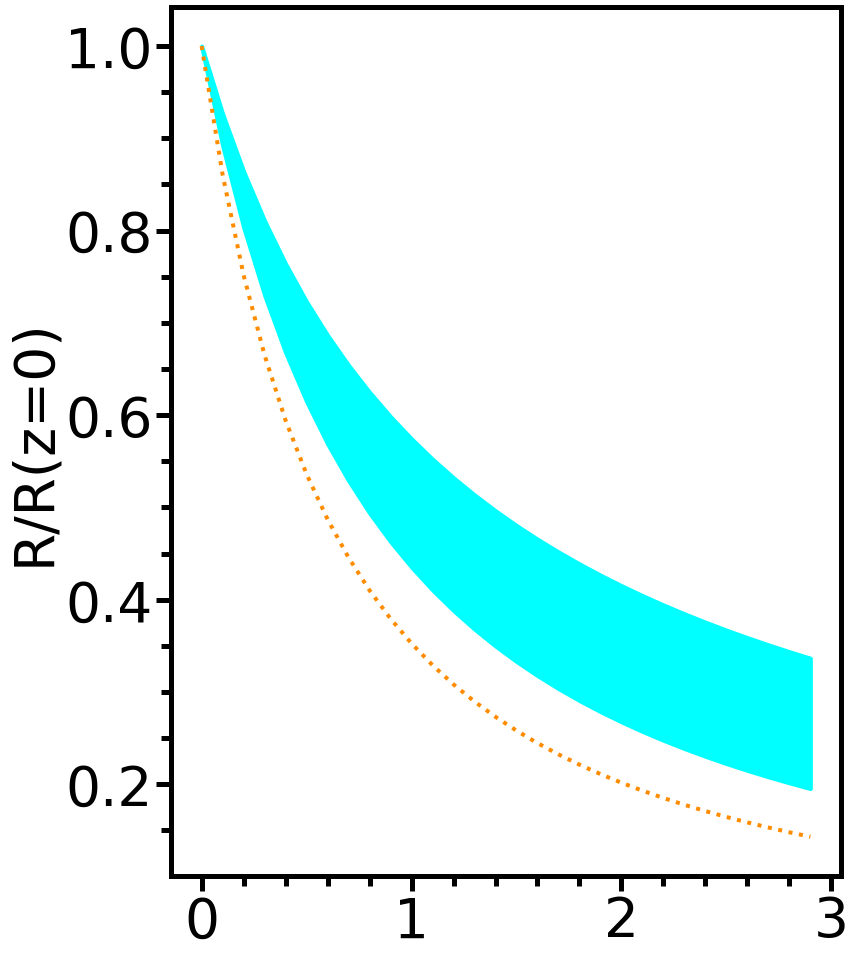

In [84]:
x = np.arange(0,3,0.1)
R = 10*(1+x)**(-1)
n = 4*(1+x)**(-1)
RR = R80(R,n)
f = (1+x)**-0.8
f1 = (1+x)**-1.2
plt.fill_between(x,f1/f1[0],f/f[0], color='cyan',label=r'$\propto(1+z)^{-\alpha}$' '\n' r'$0.8< \alpha <1.2$', lw=4)#plt.plot(x,R/R[0],lw=4, ls='--', label='$R_e$', color)
plt.plot(x,RR/RR[0], lw=4,ls=':', label='$R_{80}$',color='darkorange')
plt.ylabel('R/R(z=0)')


In [78]:
RR, R

(array([0.        , 0.30112927, 0.57394222, 0.82496289, 1.05881493,
        1.27887778, 1.487685  , 1.68717693, 1.87886683, 2.06395356,
        2.2434    , 2.41798893, 2.58836358, 2.75505764, 2.91851778,
        3.0791208 , 3.23718685, 3.39298976, 3.54676513, 3.69871684,
        3.84902222, 3.99783625, 4.145295  , 4.29151841, 4.43661264,
        4.58067201, 4.72378058, 4.86601352, 5.00743827, 5.14811552]),
 array([10.        ,  9.09090909,  8.33333333,  7.69230769,  7.14285714,
         6.66666667,  6.25      ,  5.88235294,  5.55555556,  5.26315789,
         5.        ,  4.76190476,  4.54545455,  4.34782609,  4.16666667,
         4.        ,  3.84615385,  3.7037037 ,  3.57142857,  3.44827586,
         3.33333333,  3.22580645,  3.125     ,  3.03030303,  2.94117647,
         2.85714286,  2.77777778,  2.7027027 ,  2.63157895,  2.56410256]))

In [44]:
All(halos)

array([11.97802836, 11.73533632, 11.42134257, ...,  6.91490627,
        6.91452513,  6.90122344])

In [31]:
SMHM = utils.get_SMHM()


In [41]:
LTGs = SMHM.Z19_LTGs_ETGs(choice='LTGs')
All = LTGs = SMHM.Z19_LTGs_ETGs(choice='All')

ETGs = SMHM.Z19_LTGs_ETGs(choice='ETGs')

In [67]:
halos = utils.get_halos(z=0, Vol=600**3)
halos = halos[halos>11.7]
LTGs_ms = LTGs(halos)
ETGs_ms = ETGs(halos)
all_ms = All(halos)

In [68]:
maskL = np.ma.masked_greater(LTGs_ms, 11.2).mask
maskE = np.ma.masked_greater(ETGs_ms, 11.2).mask
maskAll = np.ma.masked_greater(all_ms, 11.2).mask

In [69]:
halosL = halos[maskL]
halosE = halos[maskE]
halosAll = halos[maskAll]

In [70]:
RhL = utils.get_Rh(halos=halosL, redshift=0)
RhE = utils.get_Rh(halos=halosE, redshift=0)
RhAll = utils.get_Rh(halos=halosAll, redshift=0)

In [71]:
np.mean(RhL), np.mean(RhE), np.mean(RhAll)

(783.1016261853557, 811.0054562316956, 784.138759272396)

0.4156099680850697

In [51]:
0.6**3

0.21599999999999997

In [53]:
(0.018/0.025)**3

0.3732479999999998